Questions pour Pierre:
    - dfApplicationTest, pas de flag donc pour tester le dashboard
    - équivalent de AUC pour courbe precision-rappel?
    - A. Géron: plutôt courbe précision-rappel si la classe positive est rare (inbalanced classification) ou si on attache plus d'importance aux faux positifs qu'aux faux négatifs
    - cas flagués 0, quid pour eux de la proba de faire défaut? ne faudrait-il pas avoir une proba plutôt que 0 en label?
    - Comment est modélisé un client qui a deux crédits actifs en cours (on a deux lignes dans application_train)
    - GridSearchCV: cherche le meilleur paramètre en terme de métrique mais pas de temps de traitement
    - OneHotEncoding: et si de nouvelles valeurs apparaissent en production?

In [1308]:
# https://www.kaggle.com/mathchi/home-credit-risk-with-detailed-feature-engineering
# https://www.kaggle.com/ngainoriko/home-credit-bureau-feature-engineering

In [1309]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1310]:
import os
import datetime
import time
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from myTools import *

from sklearn.model_selection import train_test_split

In [1311]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

# Import des fichiers

In [1312]:
time1 = time.time()
dfApplicationTest = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv',",")
dfApplicationTrain = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv',",")
dfBureau = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv',",")
dfBureauBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv',",")
dfPreviousApplication = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv',",")
dfPosCashBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv',",")
dfInstallmentsPayments = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv',",")
dfCreditCardBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv',",")
time2 = time.time()
print(time2-time1)

28.09325623512268


# Préparation d'un set de validation

In [1313]:
dfApplication, dfApplicationVal = train_test_split(dfApplicationTrain, test_size=0.98, random_state=1)

In [1314]:
dfPreviousApplication = dfPreviousApplication.merge(dfApplication[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')
dfPosCashBalance = dfPosCashBalance.merge(dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV']], left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])
dfInstallmentsPayments = dfInstallmentsPayments.merge(dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV']], left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])
dfCreditCardBalance = dfCreditCardBalance.merge(dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV']], left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])
dfBureau = dfBureau.merge(dfApplication[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')
dfBureauBalance = dfBureauBalance.merge(dfBureau[['SK_ID_BUREAU']], left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU')

# Marquage des valeurs manquantes

In [1315]:
dfApplication = dfApplication.replace('XNA', np.nan)
dfPreviousApplication = dfPreviousApplication.replace('XNA', np.nan)
dfBureau = dfBureau.replace('XNA', np.nan)
dfApplication = dfApplication.replace('XAP', np.nan)
dfPreviousApplication = dfPreviousApplication.replace('XAP', np.nan)
dfBureau = dfBureau.replace('XAP', np.nan)
dfBureauBalance = dfBureauBalance.replace('X', np.nan)

# Exploration de application_train

## Suppression de champs non pertinents

In [1316]:
col_to_del = [
'FLAG_MOBIL', # Did client provide mobile phone
'FLAG_EMP_PHONE',
'FLAG_WORK_PHONE',
'FLAG_CONT_MOBILE',
'FLAG_PHONE',
'FLAG_EMAIL',

# ininéressant
'NAME_TYPE_SUITE',  # Who was accompanying client when he was applying for the loan
'DAYS_ID_PUBLISH', # How many days before the application did client change the identity document with which he applied for the loan,time only relative to the application
'DAYS_REGISTRATION', # How many days before the application did client change his registration,time only relative to the application
'WEEKDAY_APPR_PROCESS_START', # On which day of the week did the client apply for the loan
'HOUR_APPR_PROCESS_START', # Approximately at what hour did the client apply for the loan,rounded
'DAYS_LAST_PHONE_CHANGE', # How many days before application did client change phone

# flags de comparaison de donnée
'REG_REGION_NOT_LIVE_REGION', # Flag if client's permanent address does not match contact address
'REG_REGION_NOT_WORK_REGION', # Flag if client's permanent address does not match contact address
'LIVE_REGION_NOT_WORK_REGION', # Flag if client's contact address does not match work address
'REG_CITY_NOT_LIVE_CITY', # Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)
'REG_CITY_NOT_WORK_CITY', # Flag if client's permanent address does not match work address (1=different, 0=same, at city level)
'LIVE_CITY_NOT_WORK_CITY', # Flag if client's contact address does not match work address (1=different, 0=same, at city level)
    
]

for col in col_to_del:
    del dfApplication[col]
    
for col in dfApplication:
    if col[0:13] == 'FLAG_DOCUMENT':  # Did client provide document
        del dfApplication[col]

## Aperçu des valeurs manquantes

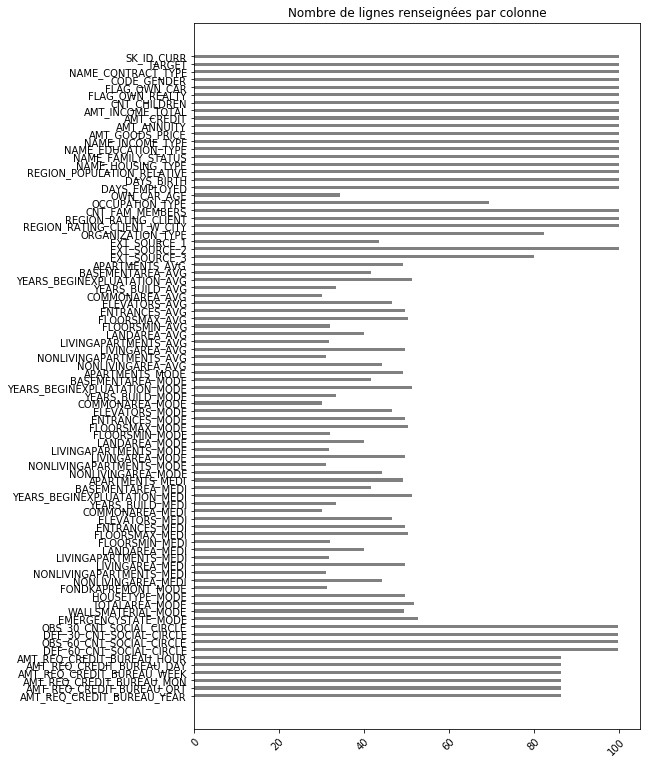

In [1317]:
myDf(dfApplication).ColCountLinesChart(typeChart='barh', displayColName=True)

## Recherche de corrélations

### Requests

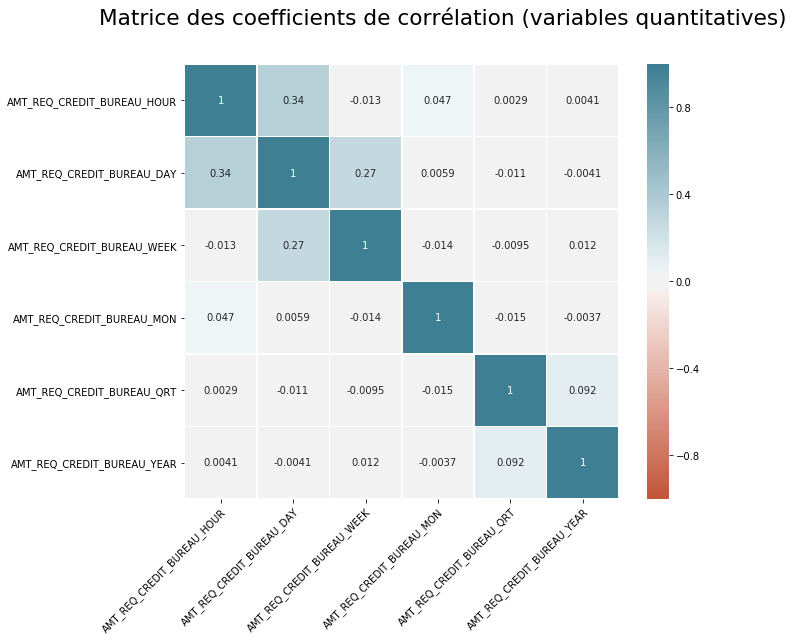

In [1318]:
myDf(dfApplication).Stat(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'], typeStat='biv',typeFeature='continue',bivThresholdCorr=2)

In [1319]:
dfApplication['AMT_REQ_CREDIT_BUREAU_YEAR'] = dfApplication.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_WEEK + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_MON + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_QRT + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_YEAR, axis=1)
dfApplication['AMT_REQ_CREDIT_BUREAU_QRT'] = dfApplication.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_WEEK + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_MON + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_QRT, axis=1)
dfApplication['AMT_REQ_CREDIT_BUREAU_MON'] = dfApplication.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_WEEK + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_MON, axis=1)
dfApplication['AMT_REQ_CREDIT_BUREAU_WEEK'] = dfApplication.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_WEEK, axis=1)
dfApplication['AMT_REQ_CREDIT_BUREAU_DAY'] = dfApplication.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_DAY, axis=1)

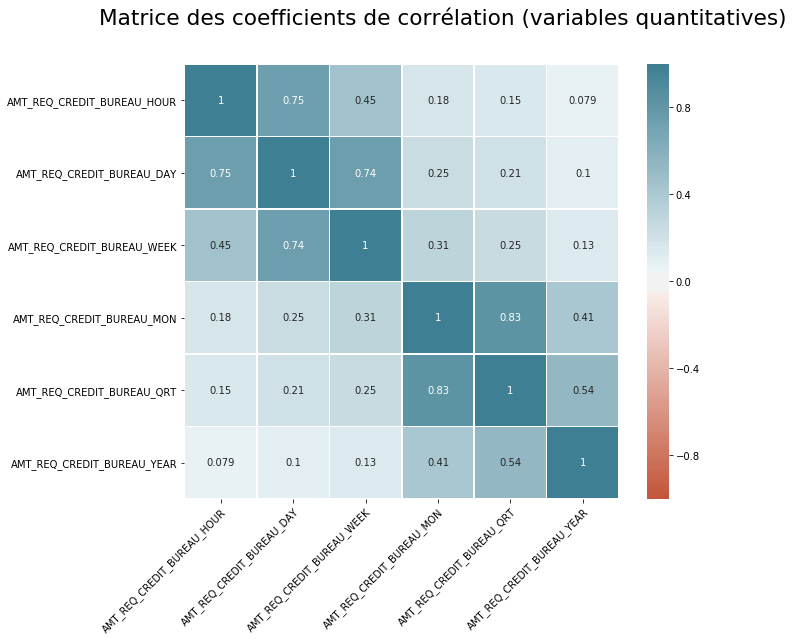

In [1320]:
myDf(dfApplication).Stat(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'], typeStat='biv',typeFeature='continue',bivThresholdCorr=2)

In [1321]:
del dfApplication['AMT_REQ_CREDIT_BUREAU_HOUR']
del dfApplication['AMT_REQ_CREDIT_BUREAU_DAY']
del dfApplication['AMT_REQ_CREDIT_BUREAU_MON']
del dfApplication['AMT_REQ_CREDIT_BUREAU_QRT']

### External source

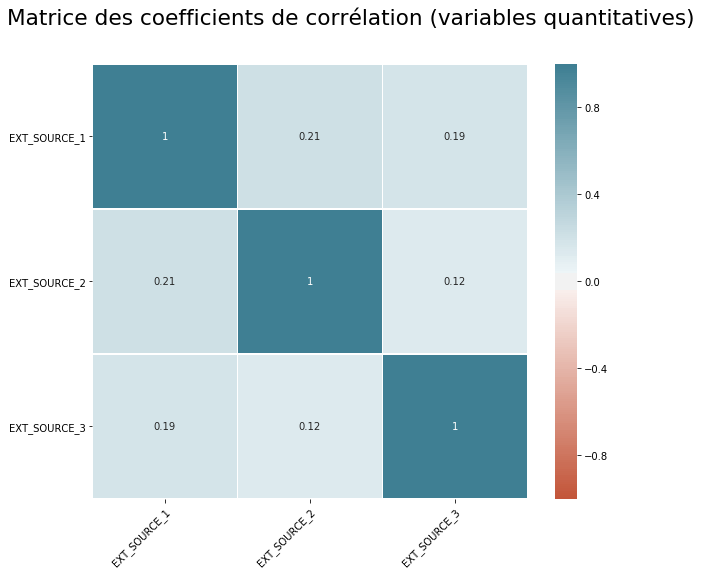

In [1322]:
myDf(dfApplication).Stat(['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3'], typeStat='biv',typeFeature='continue',bivThresholdCorr=2)

### External source 1 & days birth

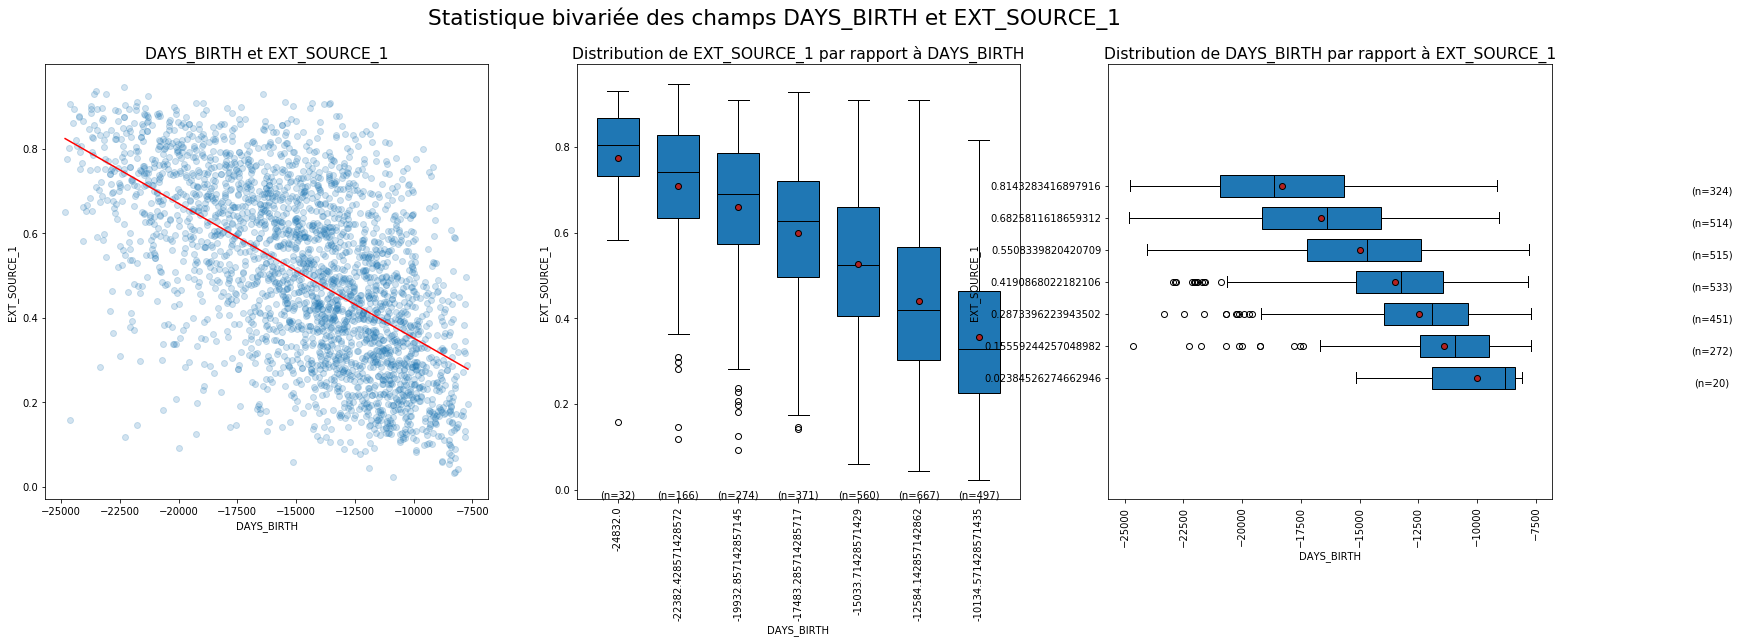

Covariance entre DAYS_BIRTH et EXT_SOURCE_1 : -477.7229393151401 
Covariance débiaisée entre DAYS_BIRTH et EXT_SOURCE_1 : -477.9017947772573 
Coefficient de correlation linéaire entre DAYS_BIRTH et EXT_SOURCE_1 : -0.5923481801857199 
Régression linéaire entre DAYS_BIRTH et EXT_SOURCE_1: y = -3.1832133423170505e-05x + 0.03363100512410937
Coefficient de détermination entre DAYS_BIRTH et EXT_SOURCE_1 : 0.3508763665693341 


In [1323]:
myDf(dfApplication).Stat(['EXT_SOURCE_1','DAYS_BIRTH'], typeStat='biv')

In [1324]:
print('Nombre de lignes avec le champ vide:')
(dfApplication[['EXT_SOURCE_1', 'DAYS_BIRTH']].isnull()).sum()

Nombre de lignes avec le champ vide:


EXT_SOURCE_1    3478
DAYS_BIRTH         0
dtype: int64

In [1325]:
del dfApplication['EXT_SOURCE_1']

### Social circle

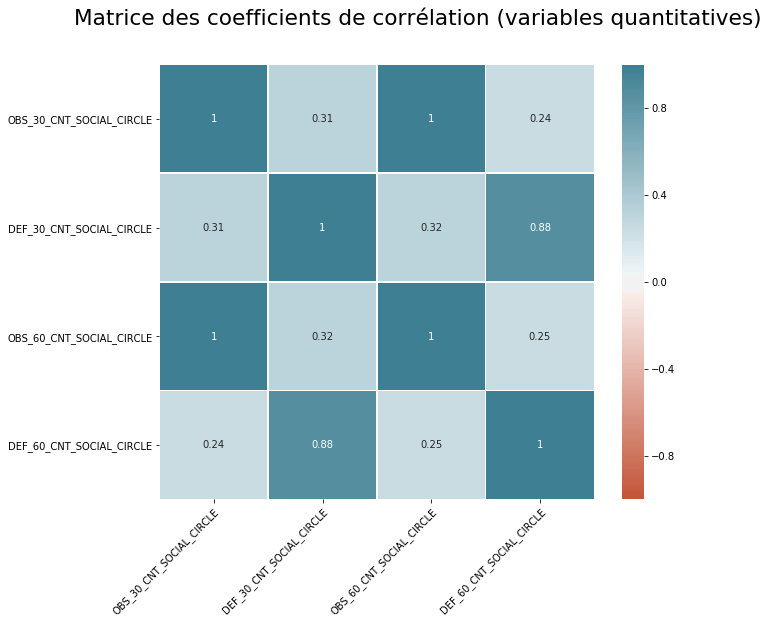

In [1326]:
myDf(dfApplication).Stat(['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'], typeStat='biv',typeFeature='continue',bivThresholdCorr=2)

In [1327]:
print('Nombre de lignes avec le champ vide:')
(dfApplication[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']].isnull()).sum()

Nombre de lignes avec le champ vide:


OBS_30_CNT_SOCIAL_CIRCLE    19
DEF_30_CNT_SOCIAL_CIRCLE    19
OBS_60_CNT_SOCIAL_CIRCLE    19
DEF_60_CNT_SOCIAL_CIRCLE    19
dtype: int64

In [1328]:
del dfApplication['OBS_60_CNT_SOCIAL_CIRCLE']
del dfApplication['DEF_60_CNT_SOCIAL_CIRCLE']

### Car

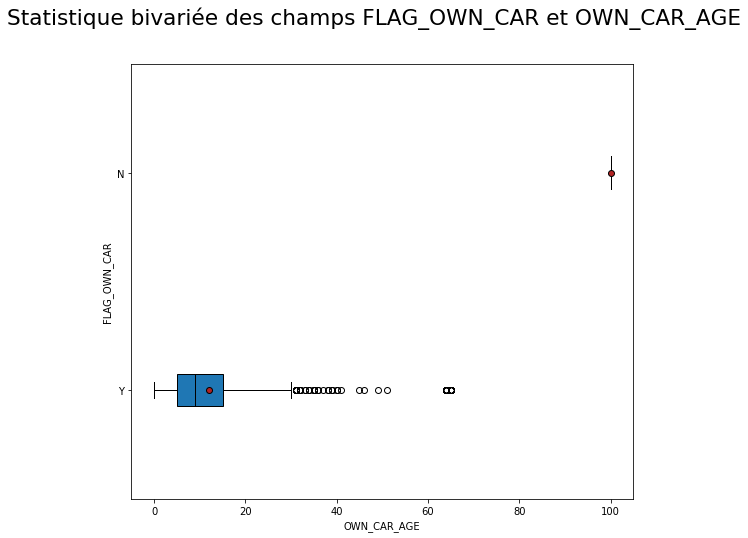

Rapport de corrélation entre FLAG_OWN_CAR et OWN_CAR_AGE: 0.9730391381347067


In [1329]:
myDf(dfApplication[['FLAG_OWN_CAR','OWN_CAR_AGE']].replace(np.nan,100)).Stat(['FLAG_OWN_CAR','OWN_CAR_AGE'], typeStat='biv')

In [1330]:
del dfApplication['OWN_CAR_AGE']

### Familly

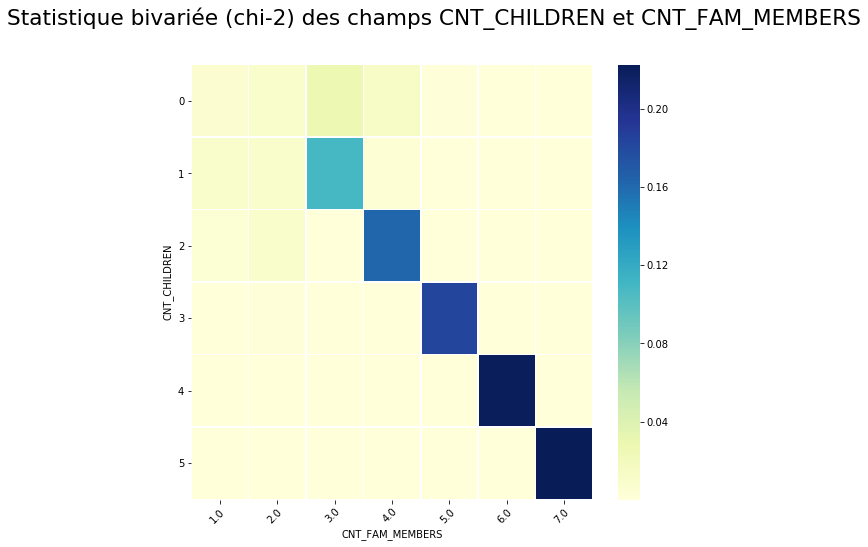

chi-2 entre CNT_CHILDREN et CNT_FAM_MEMBERS : 27588.82380466416 
phi-2 entre CNT_CHILDREN et CNT_FAM_MEMBERS : 4.485987610514497 
coefficient T de Tschuprow entre CNT_CHILDREN et CNT_FAM_MEMBERS : 0.9050002959423991 
coefficient C de Cramer entre CNT_CHILDREN et CNT_FAM_MEMBERS : 0.9472051108935696 


In [1331]:
myDf(dfApplication).Stat(['CNT_CHILDREN','CNT_FAM_MEMBERS'], typeStat='biv')

In [1332]:
print('Nombre de lignes avec le champ vide:')
(dfApplication[['CNT_CHILDREN','CNT_FAM_MEMBERS']].isnull()).sum()

Nombre de lignes avec le champ vide:


CNT_CHILDREN       0
CNT_FAM_MEMBERS    0
dtype: int64

In [1333]:
del dfApplication['CNT_FAM_MEMBERS']

### Amount

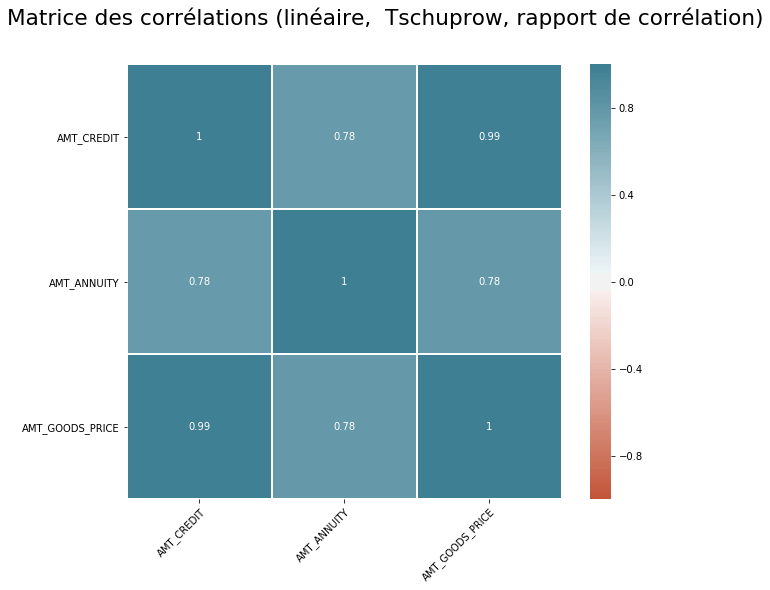

In [1334]:
myDf(dfApplication).Stat(['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'], typeStat='biv', bivOnlyCorrTable=True)

In [1335]:
print('Nombre de lignes avec le champ vide:')
(dfApplication[['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']].isnull()).sum()

Nombre de lignes avec le champ vide:


AMT_CREDIT         0
AMT_ANNUITY        0
AMT_GOODS_PRICE    5
dtype: int64

In [1336]:
del dfApplication['AMT_ANNUITY']
del dfApplication['AMT_GOODS_PRICE']

### Income / employment

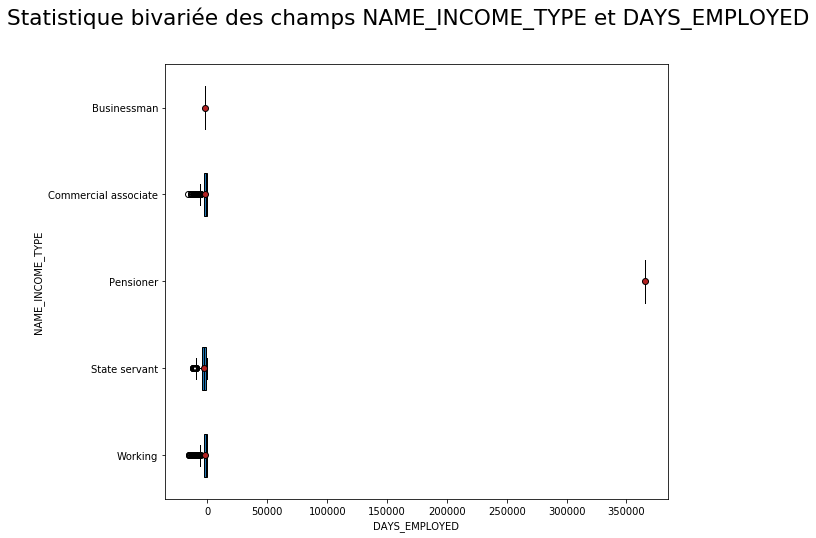

Rapport de corrélation entre NAME_INCOME_TYPE et DAYS_EMPLOYED: 0.9997762543380577


In [1337]:
myDf(dfApplication).Stat(['NAME_INCOME_TYPE','DAYS_EMPLOYED'], typeStat='biv')

In [1338]:
print('NAME_INCOME_TYPE avec days employed positif::')
dfApplication[dfApplication.DAYS_EMPLOYED > 0].NAME_INCOME_TYPE.unique()

NAME_INCOME_TYPE avec days employed positif::


array(['Pensioner'], dtype=object)

In [1339]:
dfApplication['DAYS_EMPLOYED'] = dfApplication.apply(lambda x: np.where(x.DAYS_EMPLOYED>0,1,x.DAYS_EMPLOYED),axis=1).astype('int')

In [1340]:
dfApplication[['DAYS_EMPLOYED']].dtypes

DAYS_EMPLOYED    int64
dtype: object

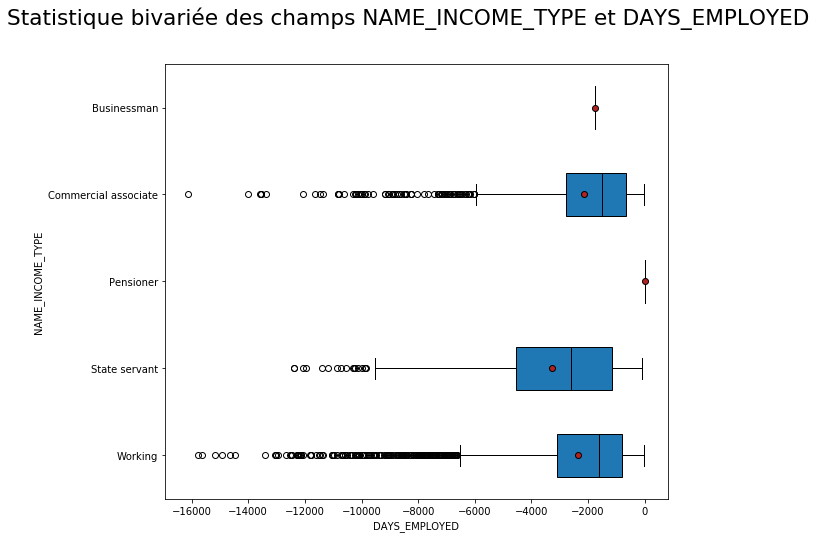

Rapport de corrélation entre NAME_INCOME_TYPE et DAYS_EMPLOYED: 0.16979846009435104


In [1341]:
myDf(dfApplication).Stat(['NAME_INCOME_TYPE','DAYS_EMPLOYED'], typeStat='biv')

### Region rating

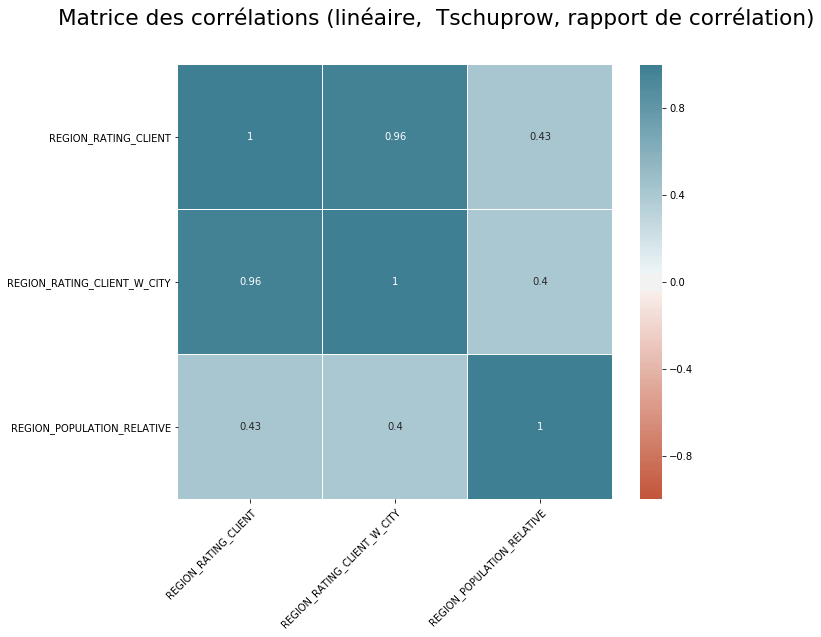

In [1342]:
myDf(dfApplication).Stat(['REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY', 'REGION_POPULATION_RELATIVE'], typeStat='biv', bivOnlyCorrTable=True)

In [1343]:
dfApplication[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY' ,'REGION_POPULATION_RELATIVE']].dtypes

REGION_RATING_CLIENT             int64
REGION_RATING_CLIENT_W_CITY      int64
REGION_POPULATION_RELATIVE     float64
dtype: object

In [1344]:
print('Nombre de lignes avec le champ vide:')
(dfApplication[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY' ,'REGION_POPULATION_RELATIVE']].isnull()).sum()

Nombre de lignes avec le champ vide:


REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
REGION_POPULATION_RELATIVE     0
dtype: int64

In [1345]:
del dfApplication['REGION_RATING_CLIENT_W_CITY']
del dfApplication['REGION_POPULATION_RELATIVE']

### Gender & occupation

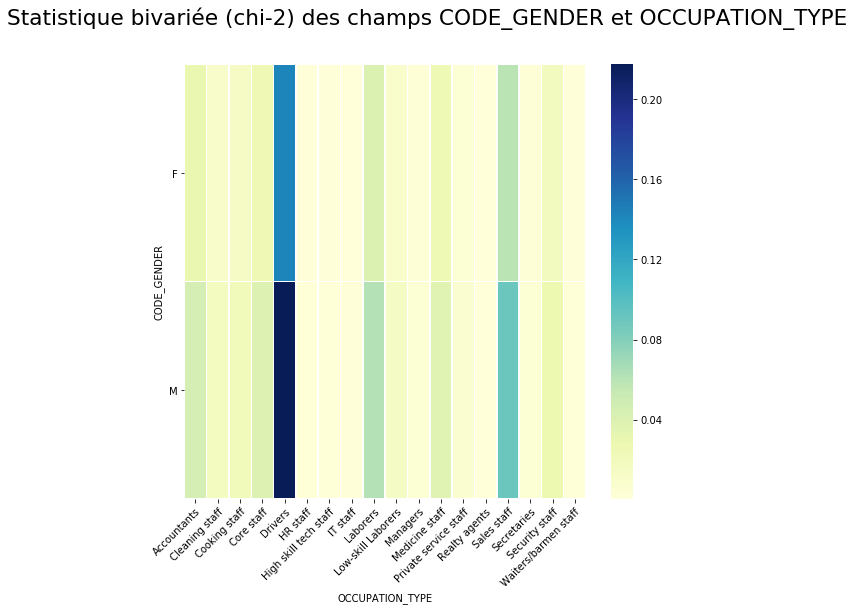

chi-2 entre CODE_GENDER et OCCUPATION_TYPE : 1457.4091698917846 
phi-2 entre CODE_GENDER et OCCUPATION_TYPE : 0.3418740722242047 
coefficient T de Tschuprow entre CODE_GENDER et OCCUPATION_TYPE : 0.2879524991914707 
coefficient C de Cramer entre CODE_GENDER et OCCUPATION_TYPE : 0.584699984799217 


In [1346]:
myDf(dfApplication).Stat(['CODE_GENDER','OCCUPATION_TYPE'], typeStat='biv')

In [1347]:
print('Nombre de lignes avec le champ vide:')
(dfApplication[['CODE_GENDER', 'OCCUPATION_TYPE']].isnull()).sum()

Nombre de lignes avec le champ vide:


CODE_GENDER           0
OCCUPATION_TYPE    1887
dtype: int64

### Champs Building

#### Corrélations enre les champs _MEDI ou _AVG ou _MODE

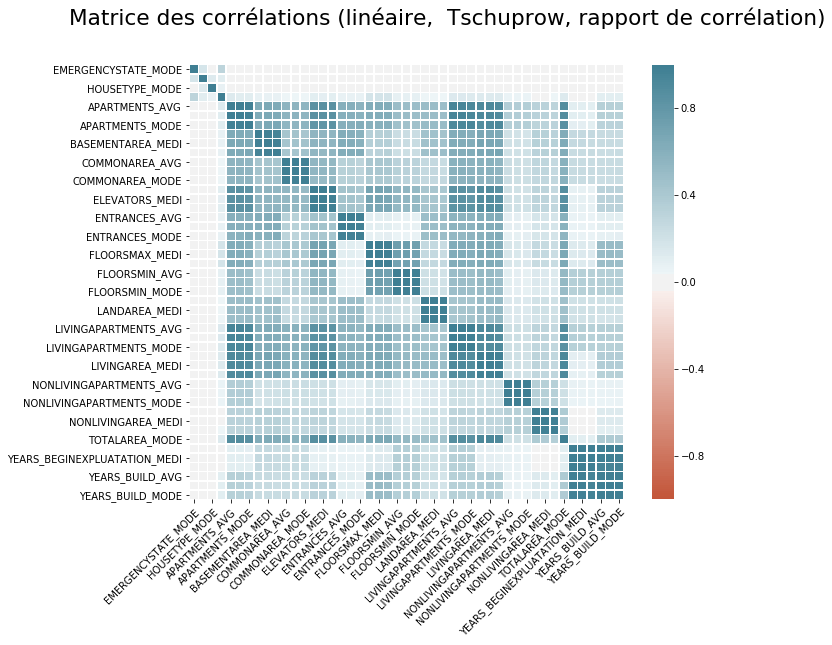

In [1348]:
tmp = dfApplication[['APARTMENTS_AVG','APARTMENTS_MEDI','APARTMENTS_MODE',
                            'BASEMENTAREA_AVG','BASEMENTAREA_MEDI','BASEMENTAREA_MODE',
                            'COMMONAREA_AVG','COMMONAREA_MEDI','COMMONAREA_MODE',
                            'ELEVATORS_AVG','ELEVATORS_MEDI','ELEVATORS_MODE',
                            'EMERGENCYSTATE_MODE','ENTRANCES_AVG','ENTRANCES_MEDI','ENTRANCES_MODE',
                            'FLOORSMAX_AVG','FLOORSMAX_MEDI','FLOORSMAX_MODE','FLOORSMIN_AVG',
                            'FLOORSMIN_MEDI','FLOORSMIN_MODE',
                            'FONDKAPREMONT_MODE',
                            'HOUSETYPE_MODE',
                            'LANDAREA_AVG','LANDAREA_MEDI','LANDAREA_MODE',
                            'LIVINGAPARTMENTS_AVG','LIVINGAPARTMENTS_MEDI','LIVINGAPARTMENTS_MODE',
                            'LIVINGAREA_AVG','LIVINGAREA_MEDI','LIVINGAREA_MODE',
                            'NONLIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAPARTMENTS_MODE',
                            'NONLIVINGAREA_AVG','NONLIVINGAREA_MEDI','NONLIVINGAREA_MODE',
                            'TOTALAREA_MODE',
                            'WALLSMATERIAL_MODE',
                            'YEARS_BEGINEXPLUATATION_AVG','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BEGINEXPLUATATION_MODE',
                            'YEARS_BUILD_AVG','YEARS_BUILD_MEDI','YEARS_BUILD_MODE']]
myDf(tmp).Stat(typeStat='biv', bivOnlyCorrTable=True,  multivHeatAnnot=False)

#### Sélection des champs _MEDI ou _AVG ou _MODE

In [1349]:
cols = ['APARTMENTS_MEDI',
        'BASEMENTAREA_MEDI',
        'COMMONAREA_MEDI',
        'ELEVATORS_MEDI',
        'ENTRANCES_MEDI',
        'FLOORSMAX_MEDI',
        'FLOORSMIN_MEDI',
        'LANDAREA_MEDI',
        'LIVINGAPARTMENTS_MEDI',
        'LIVINGAREA_MEDI',
        'NONLIVINGAPARTMENTS_MEDI',
        'NONLIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MEDI',
        'YEARS_BUILD_MEDI'
]
tmp = dfApplication[cols]
myDf(tmp).ColCountLines().mean()

41.49361207897793

In [1350]:
cols = ['APARTMENTS_AVG',
        'BASEMENTAREA_AVG',
        'COMMONAREA_AVG',
        'ELEVATORS_AVG',
        'ENTRANCES_AVG',
        'FLOORSMAX_AVG',
        'FLOORSMIN_AVG',
        'LANDAREA_AVG',
        'LIVINGAPARTMENTS_AVG',
        'LIVINGAREA_AVG',
        'NONLIVINGAPARTMENTS_AVG',
        'NONLIVINGAREA_AVG',
        'YEARS_BEGINEXPLUATATION_AVG',
        'YEARS_BUILD_AVG']
tmp = dfApplication[cols]
myDf(tmp).ColCountLines().mean()

41.49361207897793

In [1351]:
cols = ['APARTMENTS_MODE',
'BASEMENTAREA_MODE',
'COMMONAREA_MODE',
'ELEVATORS_MODE',
'EMERGENCYSTATE_MODE',
'ENTRANCES_MODE',
'FLOORSMAX_MODE',
'FLOORSMIN_MODE',
'FONDKAPREMONT_MODE',
'HOUSETYPE_MODE',
'LANDAREA_MODE',
'LIVINGAPARTMENTS_MODE',
'LIVINGAREA_MODE',
'NONLIVINGAPARTMENTS_MODE',
'NONLIVINGAREA_MODE',
'TOTALAREA_MODE',
'WALLSMATERIAL_MODE',
'YEARS_BEGINEXPLUATATION_MODE',
'YEARS_BUILD_MODE'
]
tmp = dfApplication[cols]
myDf(tmp).ColCountLines().mean()

42.914848095849386

In [1352]:
del dfApplication['APARTMENTS_AVG']
del dfApplication['APARTMENTS_MEDI']
del dfApplication['BASEMENTAREA_AVG']
del dfApplication['BASEMENTAREA_MEDI']
del dfApplication['COMMONAREA_AVG']
del dfApplication['COMMONAREA_MEDI']
del dfApplication['ELEVATORS_AVG']
del dfApplication['ELEVATORS_MEDI']
del dfApplication['ENTRANCES_AVG']
del dfApplication['ENTRANCES_MEDI']
del dfApplication['FLOORSMAX_AVG']
del dfApplication['FLOORSMAX_MEDI']
del dfApplication['FLOORSMIN_AVG']
del dfApplication['FLOORSMIN_MEDI']
del dfApplication['LANDAREA_AVG']
del dfApplication['LANDAREA_MEDI']
del dfApplication['LIVINGAPARTMENTS_AVG']
del dfApplication['LIVINGAPARTMENTS_MEDI']
del dfApplication['LIVINGAREA_AVG']
del dfApplication['LIVINGAREA_MEDI']
del dfApplication['NONLIVINGAPARTMENTS_AVG']
del dfApplication['NONLIVINGAPARTMENTS_MEDI']
del dfApplication['NONLIVINGAREA_AVG']
del dfApplication['NONLIVINGAREA_MEDI']
del dfApplication['YEARS_BEGINEXPLUATATION_AVG']
del dfApplication['YEARS_BEGINEXPLUATATION_MEDI']
del dfApplication['YEARS_BUILD_AVG']
del dfApplication['YEARS_BUILD_MEDI']

#### Suppression des champs _MODE avec trop peu de valeurs différentes

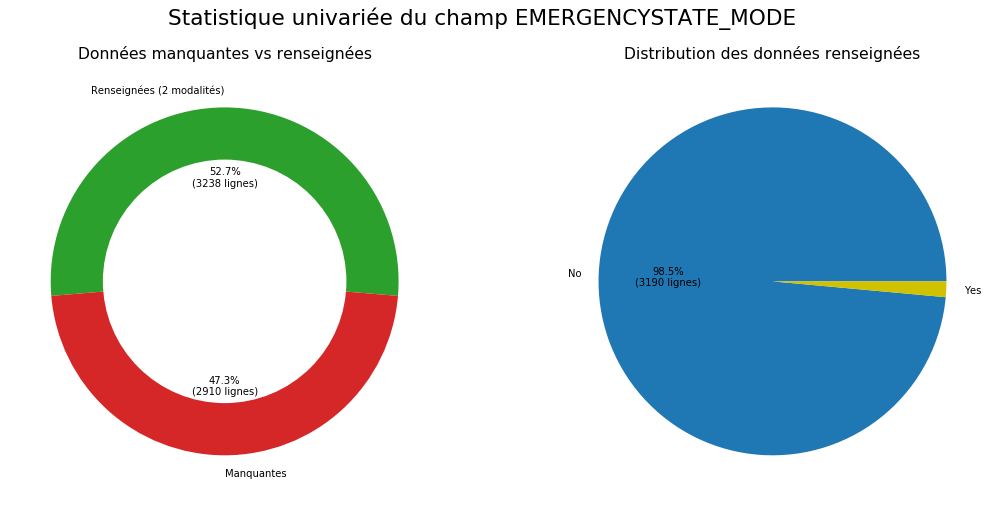

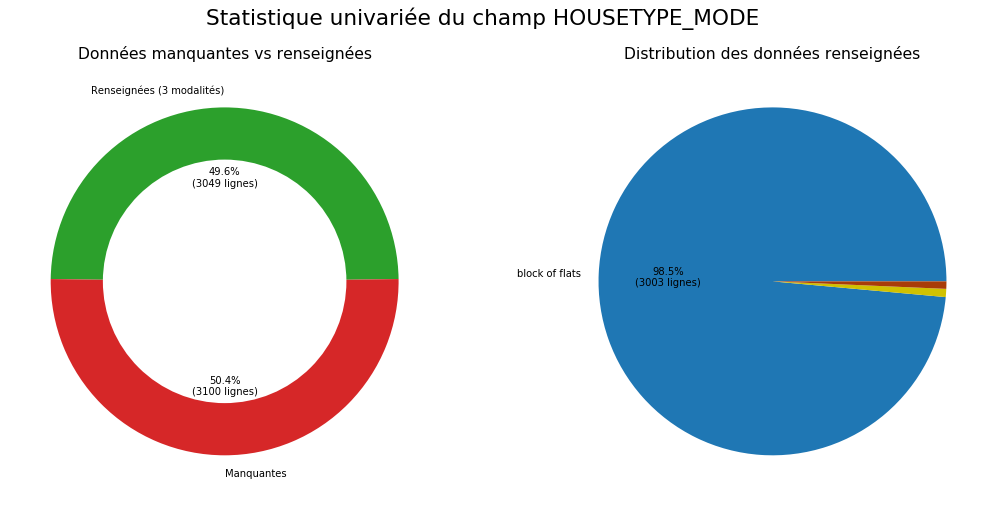

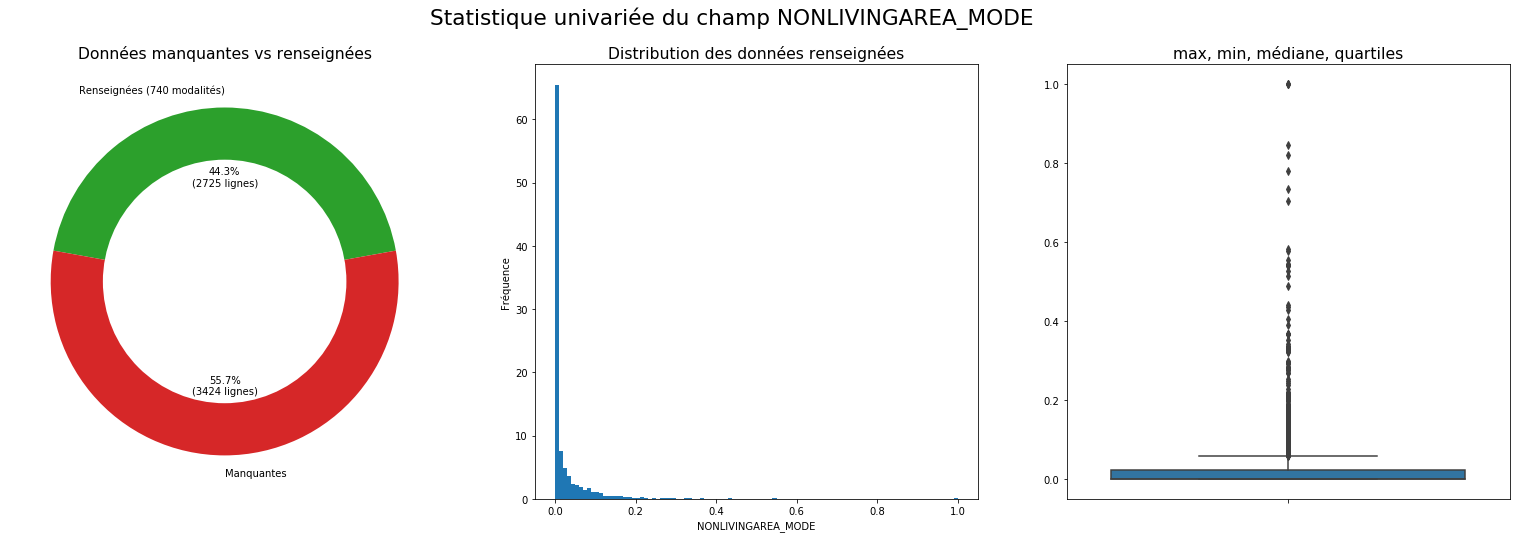

Mesures de position
 - Moyenne: 0.03
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.08
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.02
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 6.35
 - Kurtosis (applatissement): 56.37


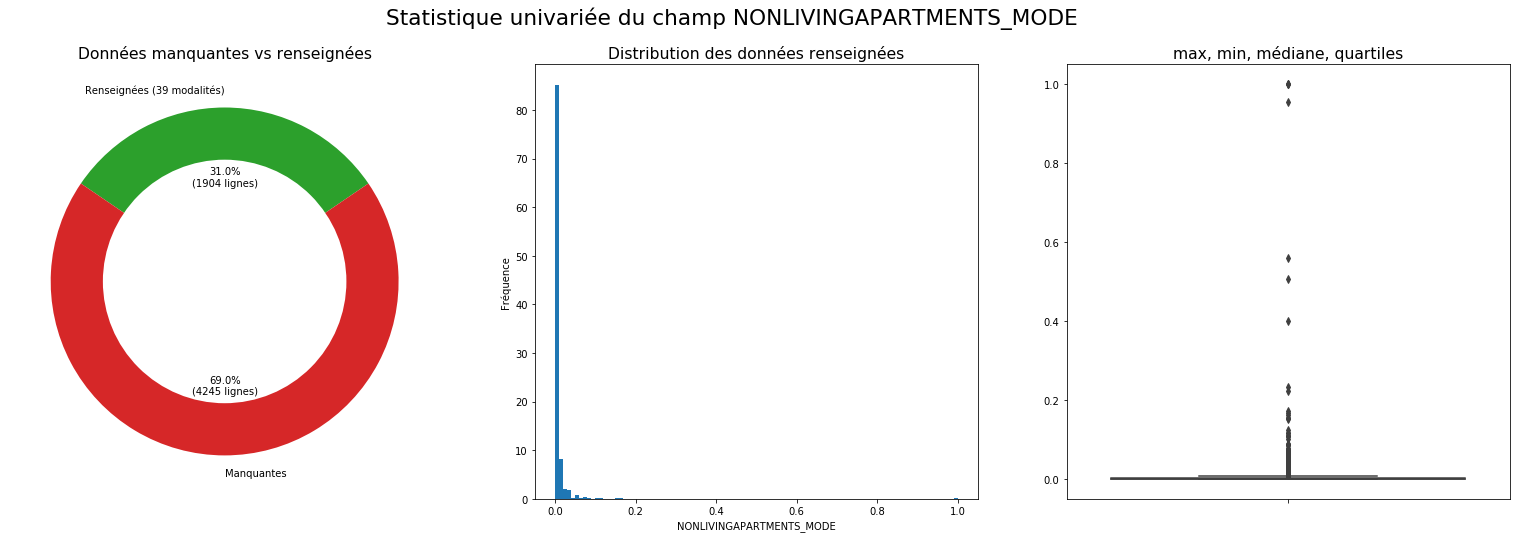

Mesures de position
 - Moyenne: 0.01
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.05
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 15.83
 - Kurtosis (applatissement): 281.59


In [1353]:
myDf(dfApplication[['EMERGENCYSTATE_MODE','HOUSETYPE_MODE','NONLIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE']]).Stat(typeStat='univ', statsNan=True)

In [1354]:
del dfApplication['EMERGENCYSTATE_MODE']
del dfApplication['HOUSETYPE_MODE']
del dfApplication['NONLIVINGAREA_MODE']
del dfApplication['NONLIVINGAPARTMENTS_MODE']

#### Aperçu du taux de remplissage des champs _MODE

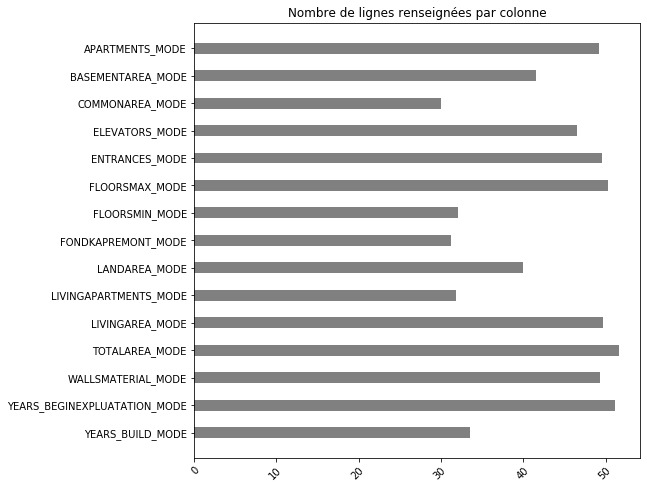

In [1355]:
cols = ['APARTMENTS_MODE',
'BASEMENTAREA_MODE',
'COMMONAREA_MODE',
'ELEVATORS_MODE',
'ENTRANCES_MODE',
'FLOORSMAX_MODE',
'FLOORSMIN_MODE',
'FONDKAPREMONT_MODE',
'LANDAREA_MODE',
'LIVINGAPARTMENTS_MODE',
'LIVINGAREA_MODE',
'TOTALAREA_MODE',
'WALLSMATERIAL_MODE',
'YEARS_BEGINEXPLUATATION_MODE',
'YEARS_BUILD_MODE'
]
myDf(dfApplication[cols]).ColCountLinesChart(typeChart='barh', displayColName=True)

#### Corrélations entre champs _MODE

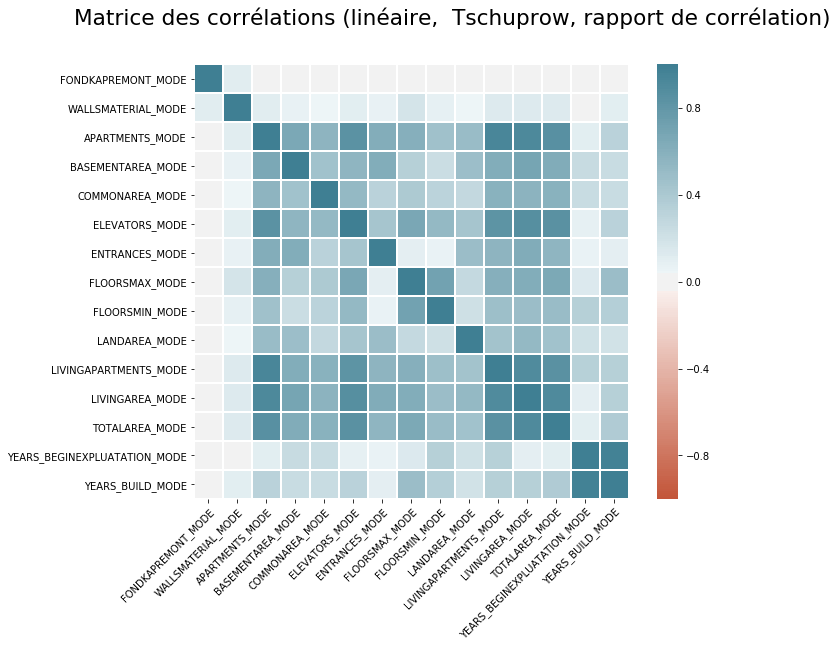

In [1356]:
myDf(dfApplication[cols]).Stat(typeStat='biv', bivOnlyCorrTable=True, multivHeatAnnot=False)

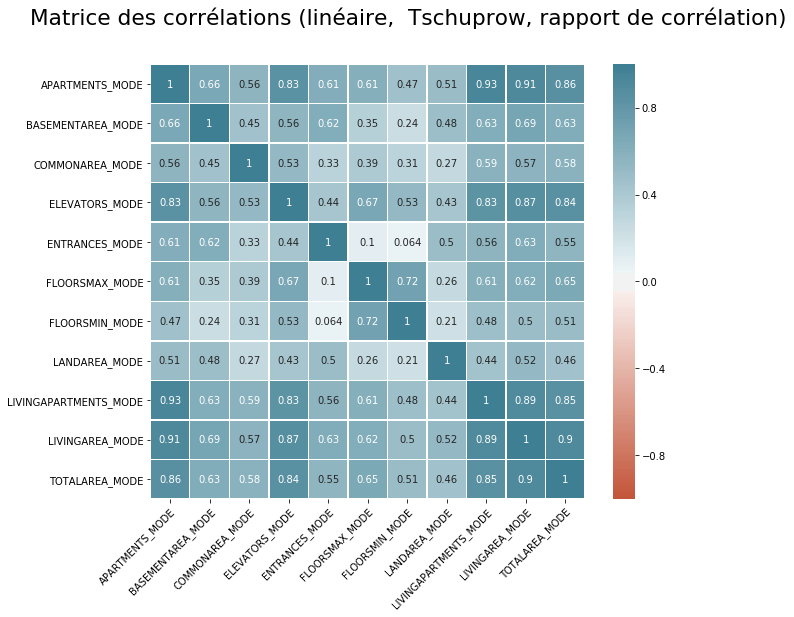

In [1357]:
cols = ['APARTMENTS_MODE',
'BASEMENTAREA_MODE',
'COMMONAREA_MODE',
'ELEVATORS_MODE',
'ENTRANCES_MODE',
'FLOORSMAX_MODE',
'FLOORSMIN_MODE',
'LANDAREA_MODE',
'LIVINGAPARTMENTS_MODE',
'LIVINGAREA_MODE',
'TOTALAREA_MODE'
]
myDf(dfApplication[cols]).Stat(typeStat='biv', bivOnlyCorrTable=True, multivHeatAnnot=True)

In [1358]:
del dfApplication['BASEMENTAREA_MODE']
del dfApplication['COMMONAREA_MODE']
del dfApplication['ELEVATORS_MODE']
del dfApplication['ENTRANCES_MODE']
del dfApplication['FLOORSMAX_MODE']
del dfApplication['FLOORSMIN_MODE']
del dfApplication['LANDAREA_MODE']
del dfApplication['LIVINGAPARTMENTS_MODE']
del dfApplication['LIVINGAREA_MODE']
del dfApplication['TOTALAREA_MODE']

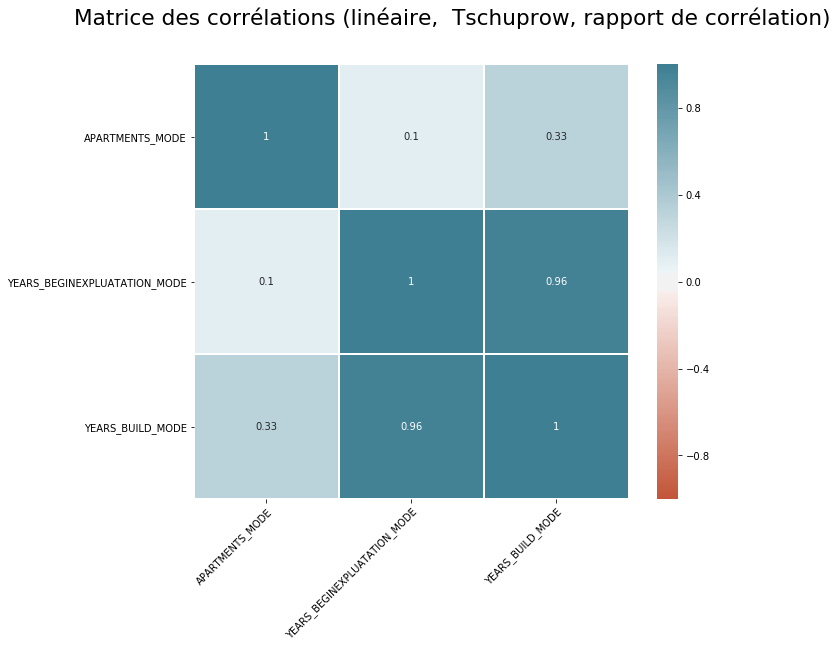

In [1359]:
myDf(dfApplication).Stat(['APARTMENTS_MODE','YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE'],typeStat='biv', bivOnlyCorrTable=True, multivHeatAnnot=True)

In [1360]:
print('Nombre de lignes avec le champ vide:')
(dfApplication[['APARTMENTS_MODE','YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE']].isnull()).sum()

Nombre de lignes avec le champ vide:


APARTMENTS_MODE                 3125
YEARS_BEGINEXPLUATATION_MODE    3002
YEARS_BUILD_MODE                4088
dtype: int64

In [1361]:
del dfApplication['YEARS_BUILD_MODE']

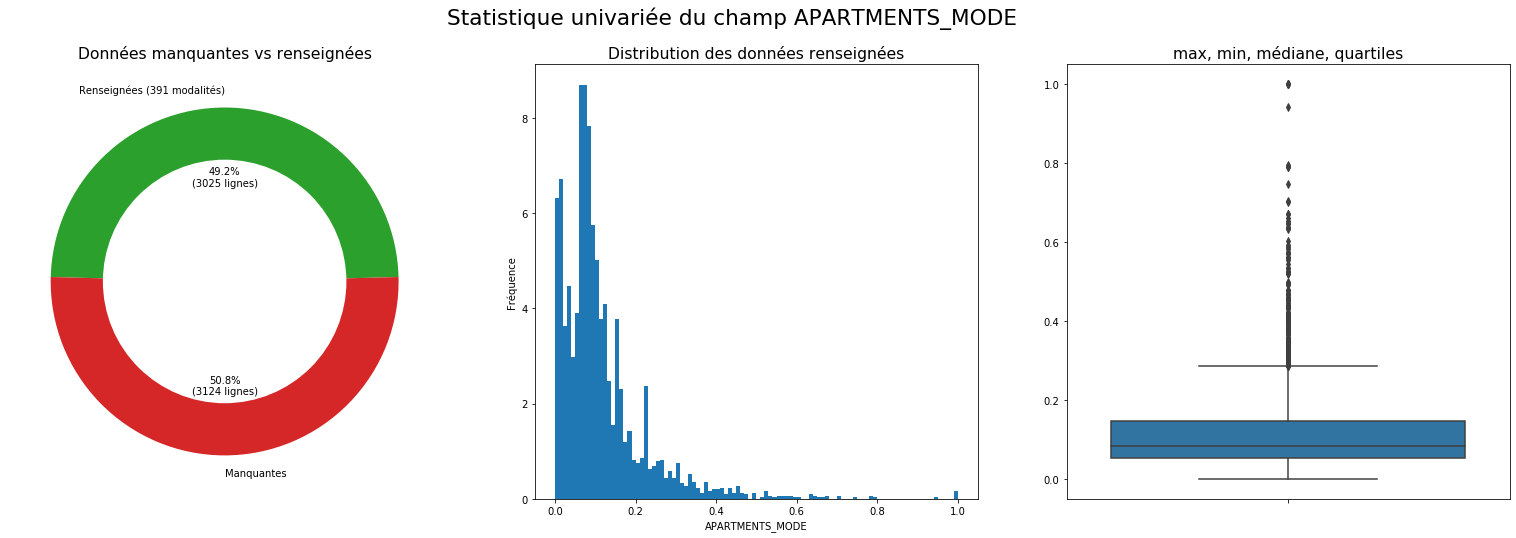

Mesures de position
 - Moyenne: 0.11
 - Médiane: 0.08
Mesures de dispertion
 - Ecart type: 0.11
 - Min: 0.0
 - Q25: 0.05
 - Q75: 0.15
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 2.79
 - Kurtosis (applatissement): 12.54


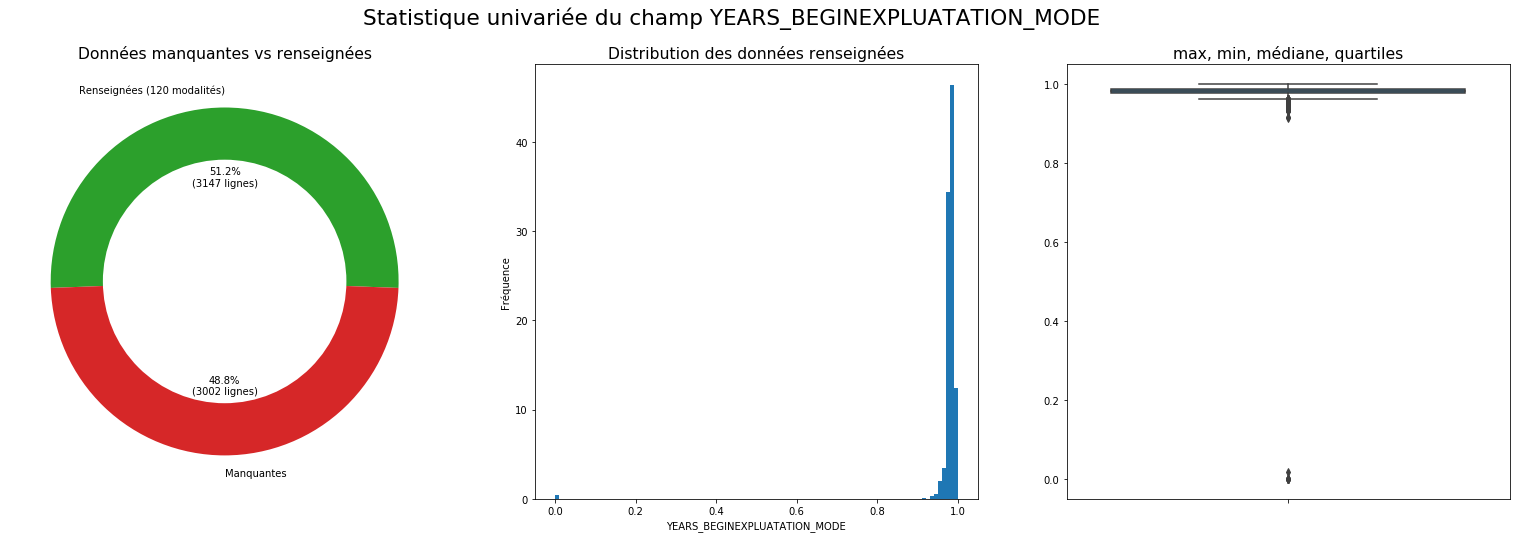

Mesures de position
 - Moyenne: 0.98
 - Médiane: 0.98
Mesures de dispertion
 - Ecart type: 0.06
 - Min: 0.0
 - Q25: 0.98
 - Q75: 0.99
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -15.0
 - Kurtosis (applatissement): 227.67


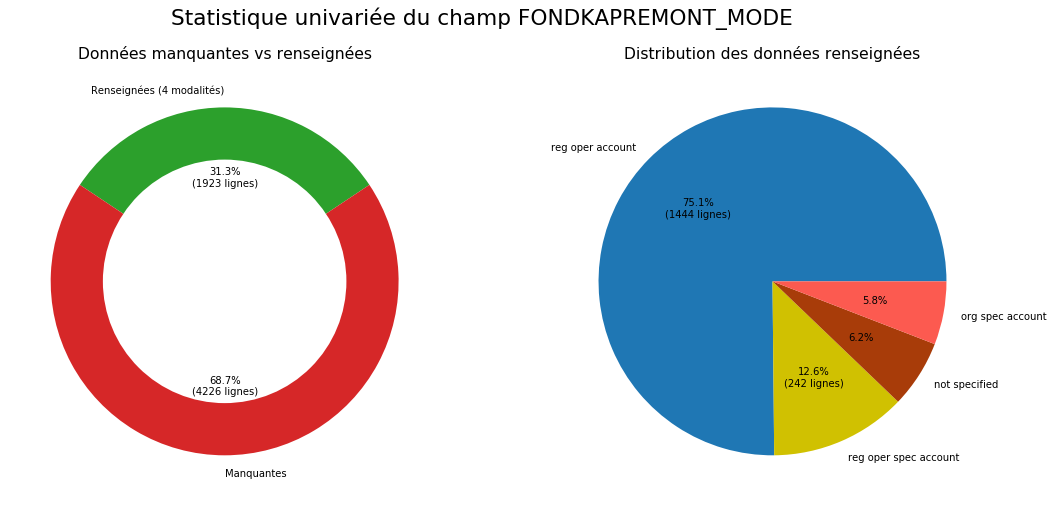

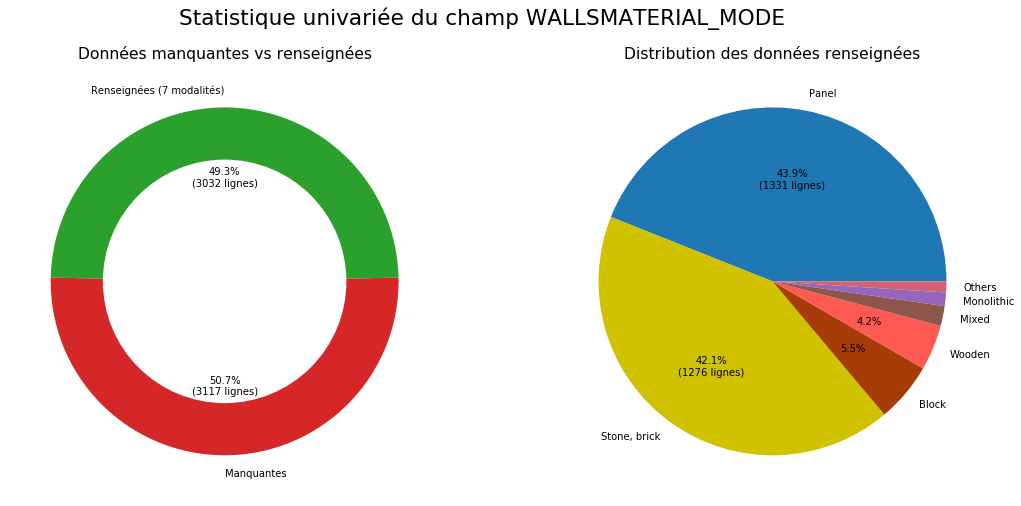

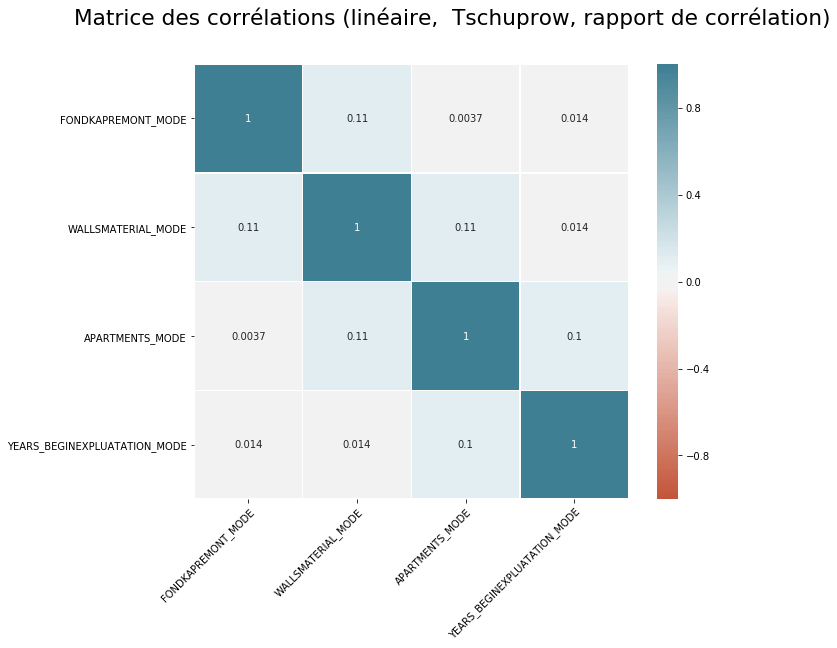

In [1362]:
cols = ['APARTMENTS_MODE',
'YEARS_BEGINEXPLUATATION_MODE',
'FONDKAPREMONT_MODE',
'WALLSMATERIAL_MODE'
]
myDf(dfApplication[cols]).Stat(typeStat='univ-biv', statsNan=True, bivOnlyCorrTable=True, multivHeatAnnot=True)

In [1363]:
del dfApplication['FONDKAPREMONT_MODE']

### Matrice des corrélations des variables restantes

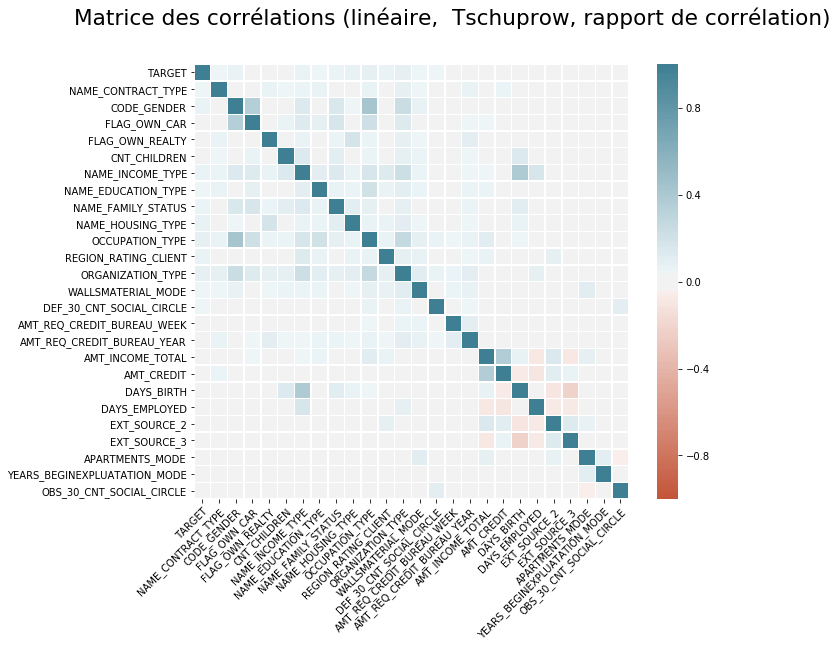

In [1364]:
myDf(dfApplication).Stat(exclCol=['SK_ID_CURR'], typeStat='biv', bivOnlyCorrTable=True, multivHeatAnnot=False)

## Statistique univariée

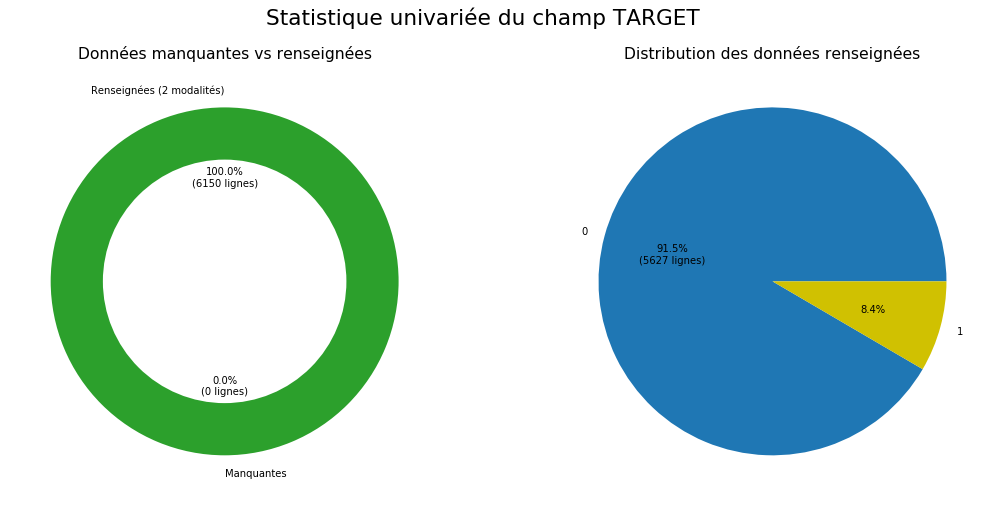

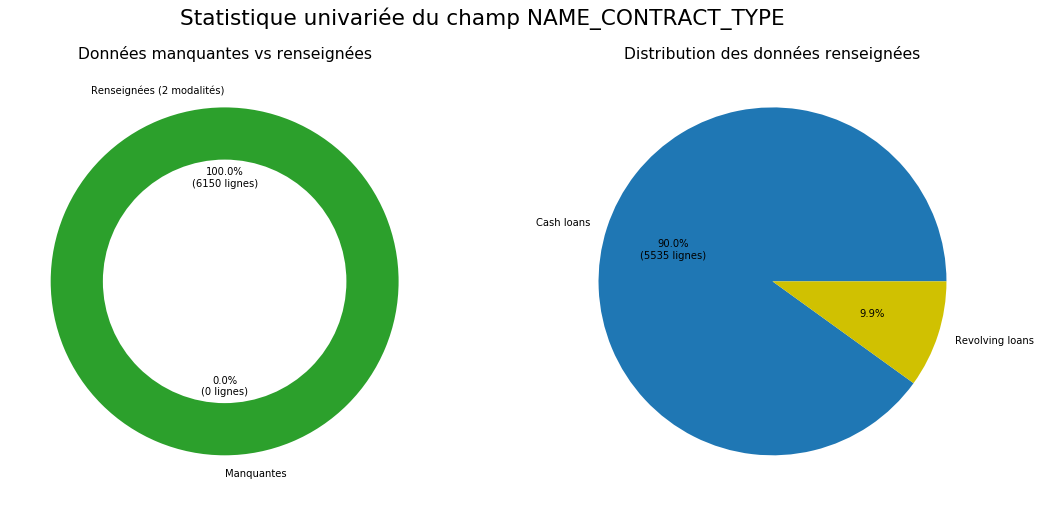

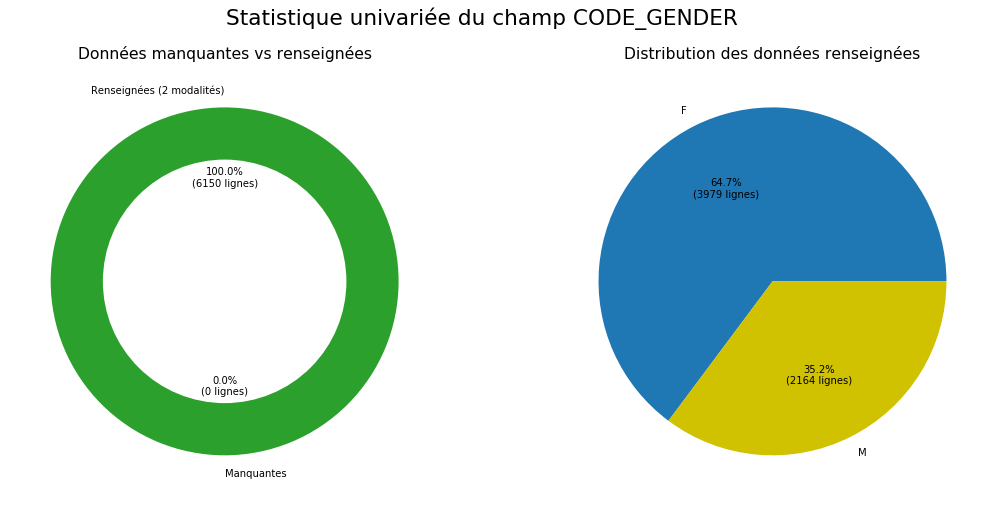

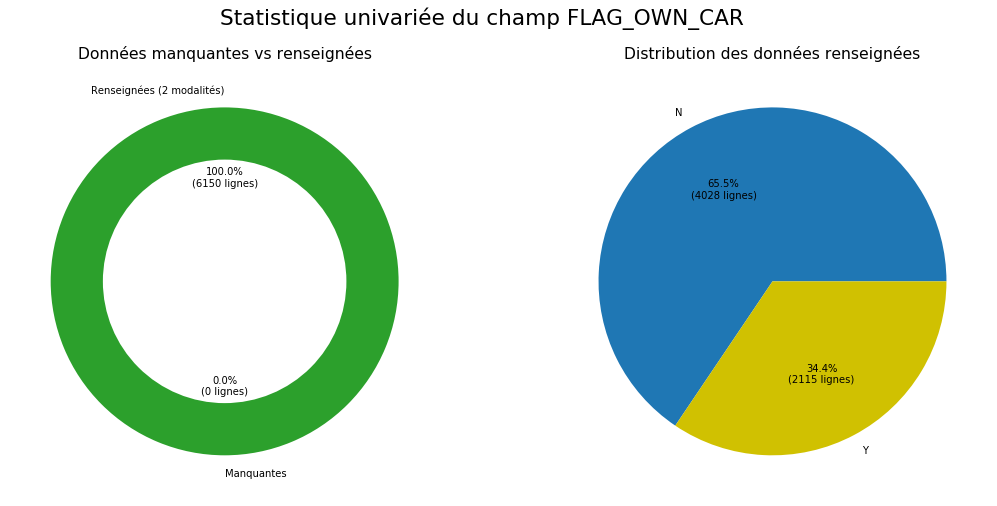

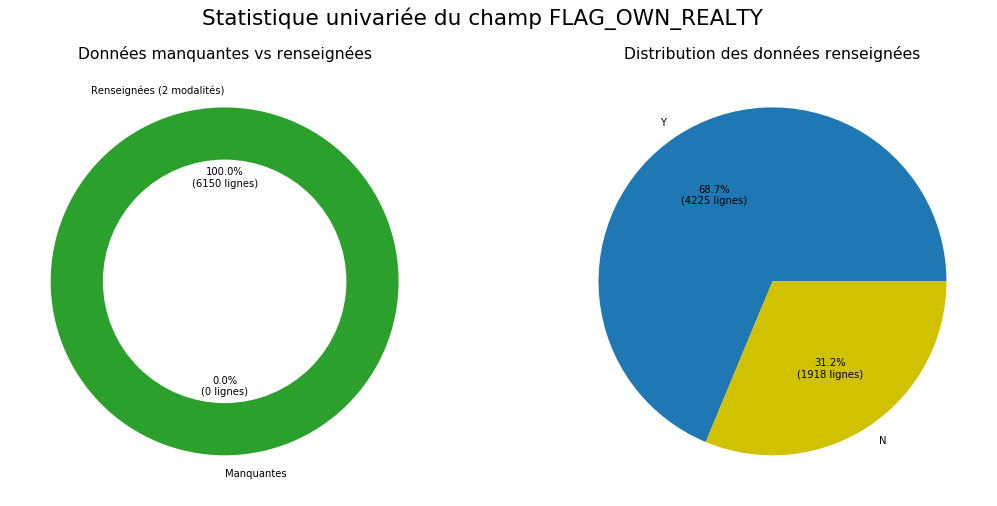

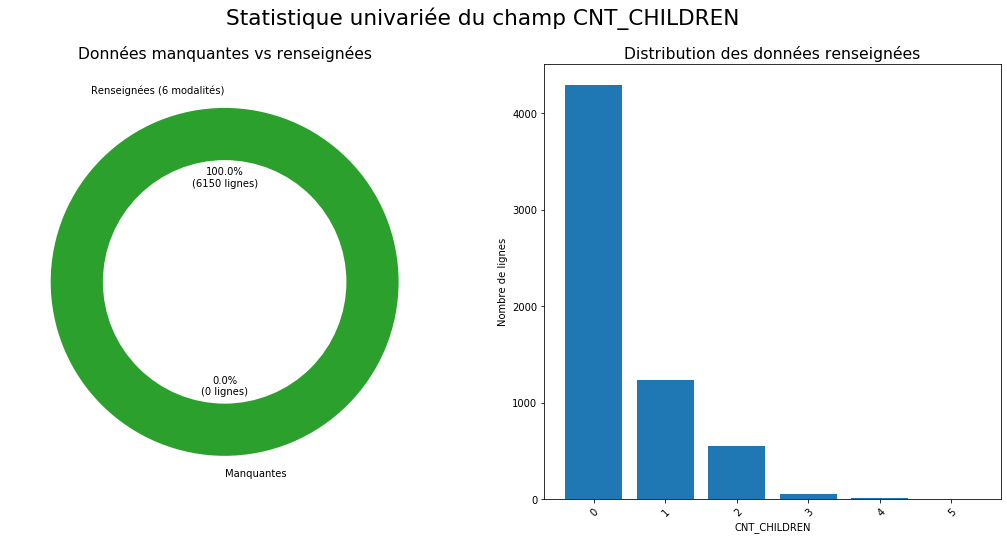

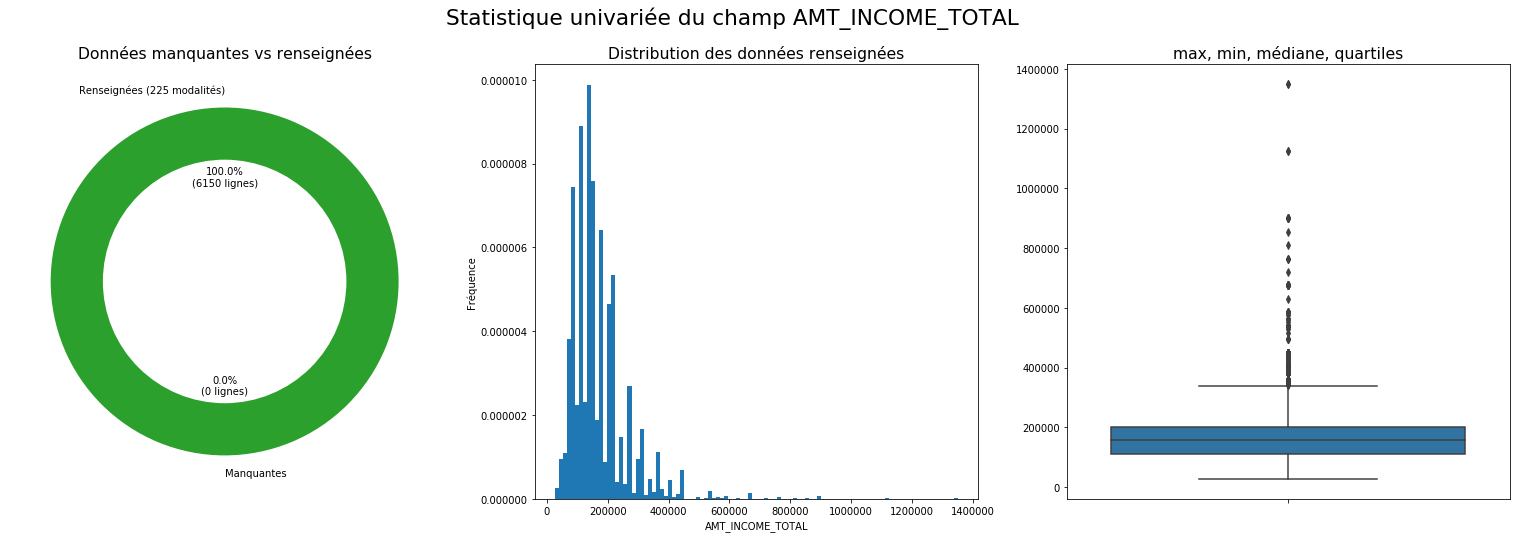

Mesures de position
 - Moyenne: 169602.42
 - Médiane: 157500.0
Mesures de dispertion
 - Ecart type: 94517.96
 - Min: 27000.0
 - Q25: 112500.0
 - Q75: 202500.0
 - Max: 1350000.0
Mesures de forme
 - Skewness (asymétrie): 2.87
 - Kurtosis (applatissement): 18.47


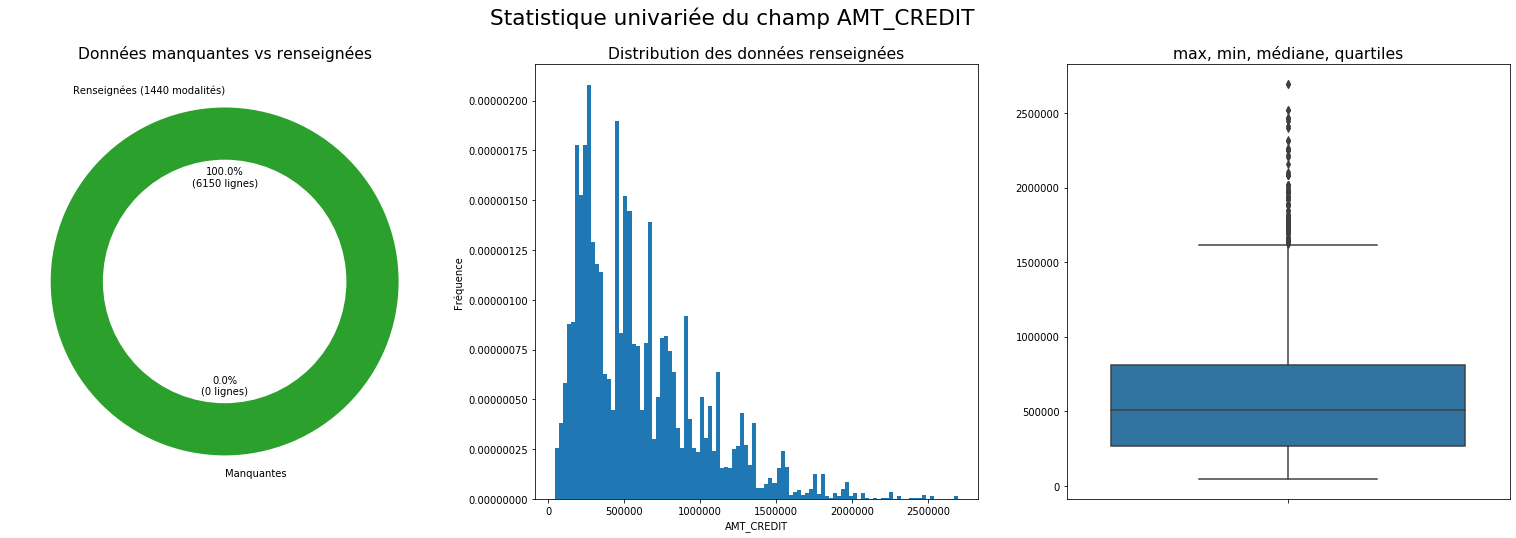

Mesures de position
 - Moyenne: 600112.76
 - Médiane: 509400.0
Mesures de dispertion
 - Ecart type: 405606.66
 - Min: 45000.0
 - Q25: 270000.0
 - Q75: 808650.0
 - Max: 2695500.0
Mesures de forme
 - Skewness (asymétrie): 1.21
 - Kurtosis (applatissement): 1.54


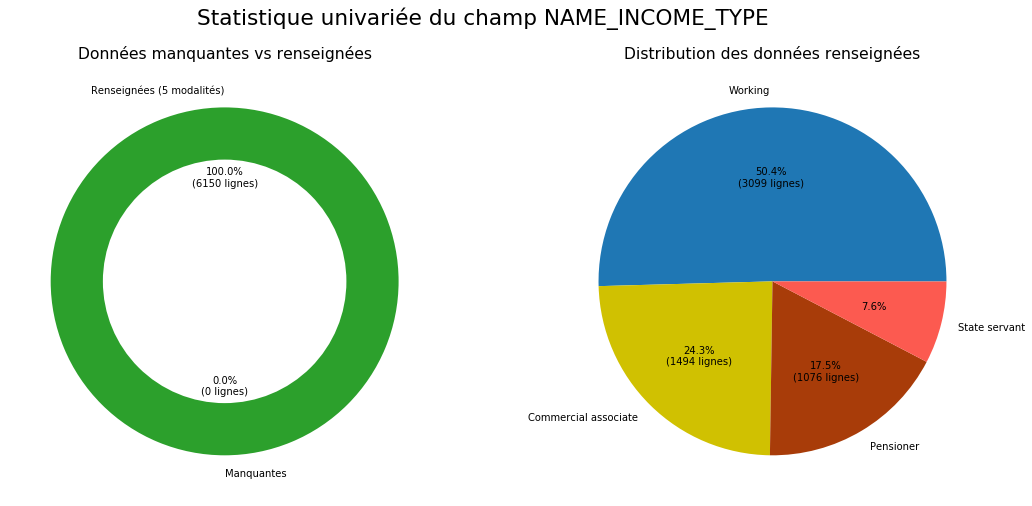

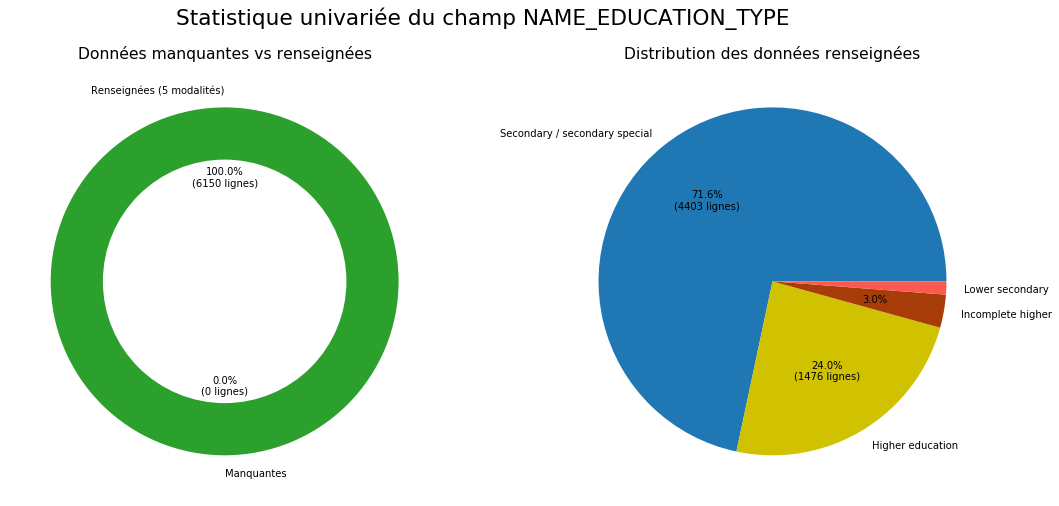

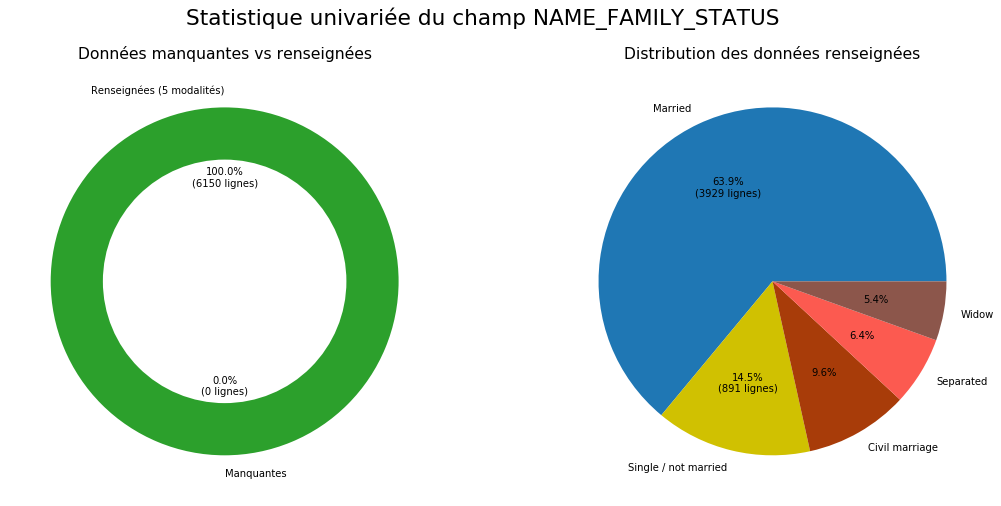

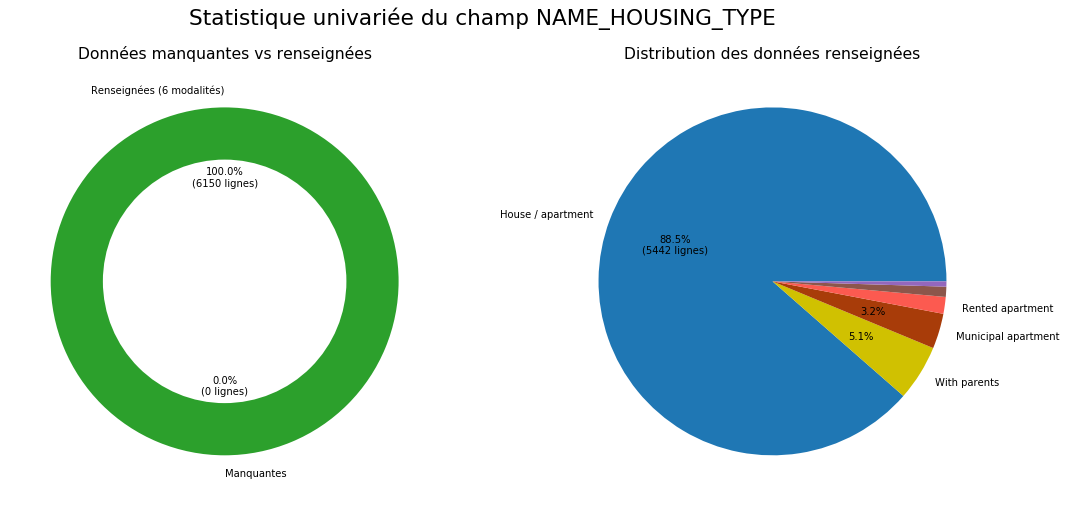

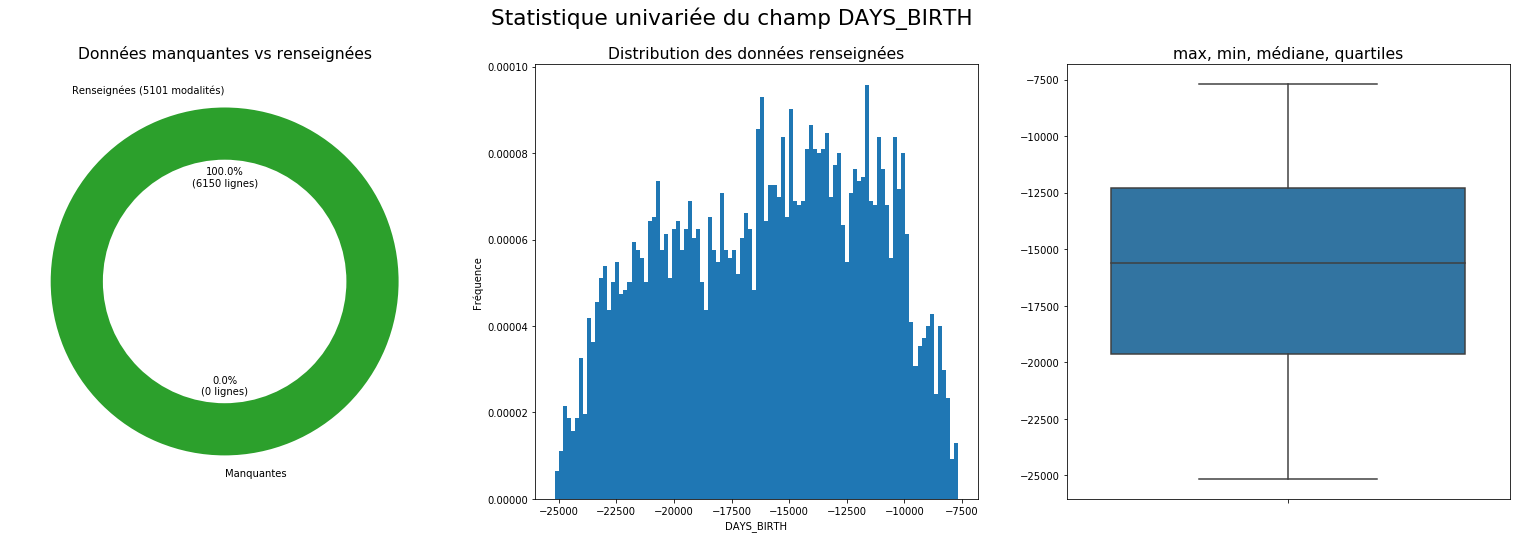

Mesures de position
 - Moyenne: -15968.58
 - Médiane: -15614.5
Mesures de dispertion
 - Ecart type: 4368.23
 - Min: -25165
 - Q25: -19630.5
 - Q75: -12299.25
 - Max: -7685
Mesures de forme
 - Skewness (asymétrie): -0.15
 - Kurtosis (applatissement): -1.05


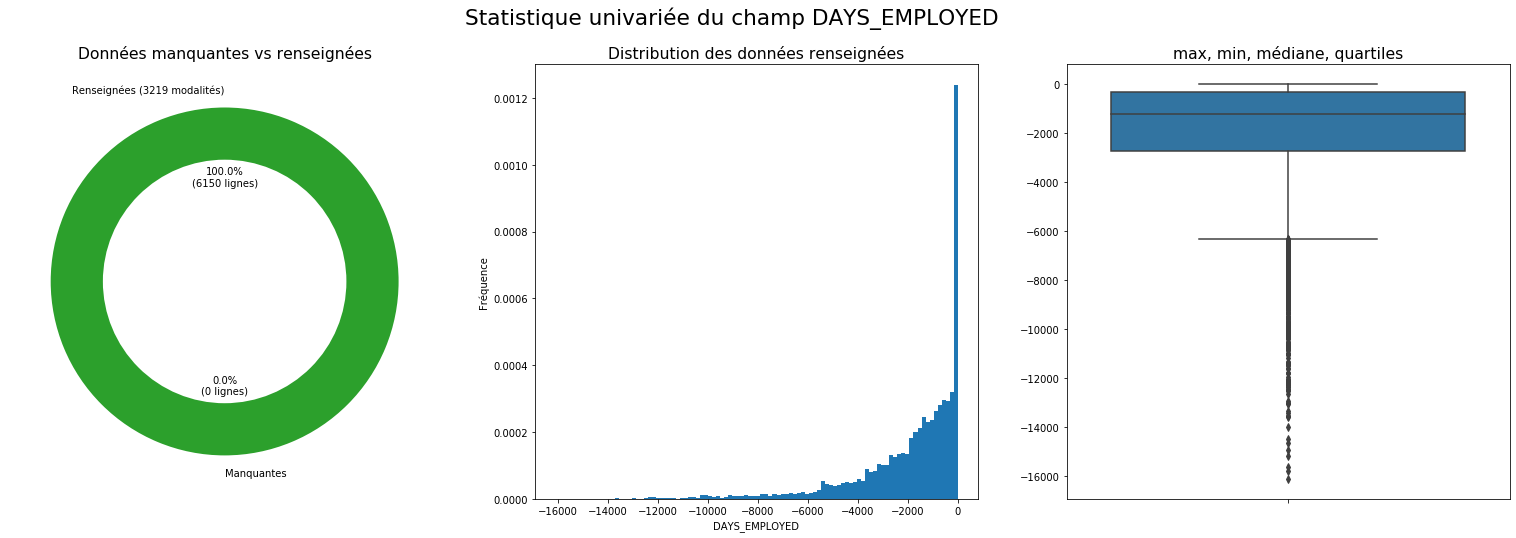

Mesures de position
 - Moyenne: -1959.42
 - Médiane: -1251.0
Mesures de dispertion
 - Ecart type: 2297.38
 - Min: -16121
 - Q25: -2724.75
 - Q75: -318.0
 - Max: 1
Mesures de forme
 - Skewness (asymétrie): -2.04
 - Kurtosis (applatissement): 5.16


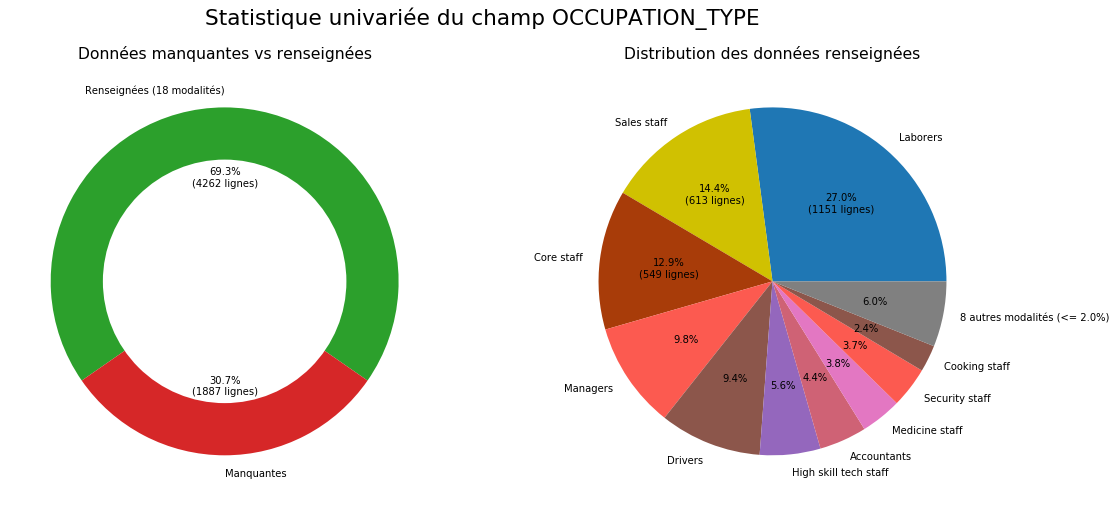

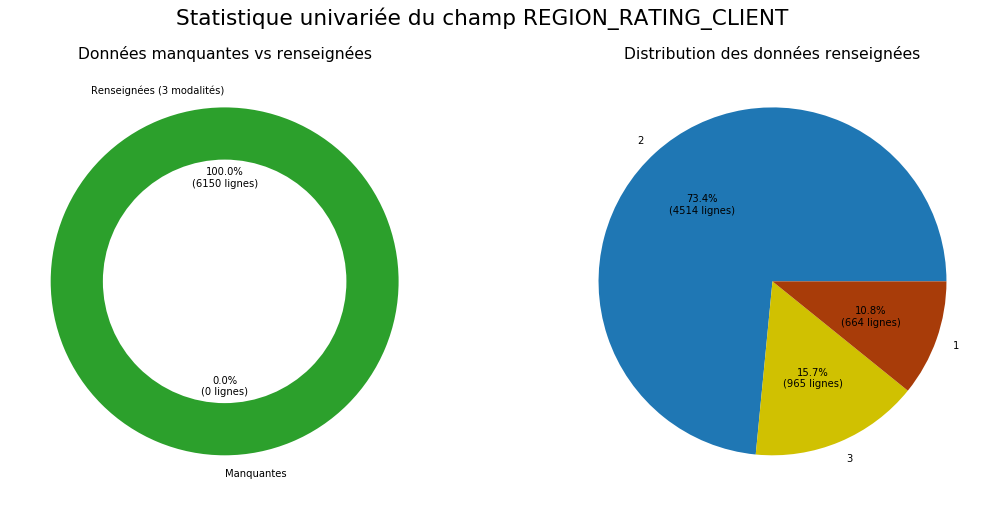

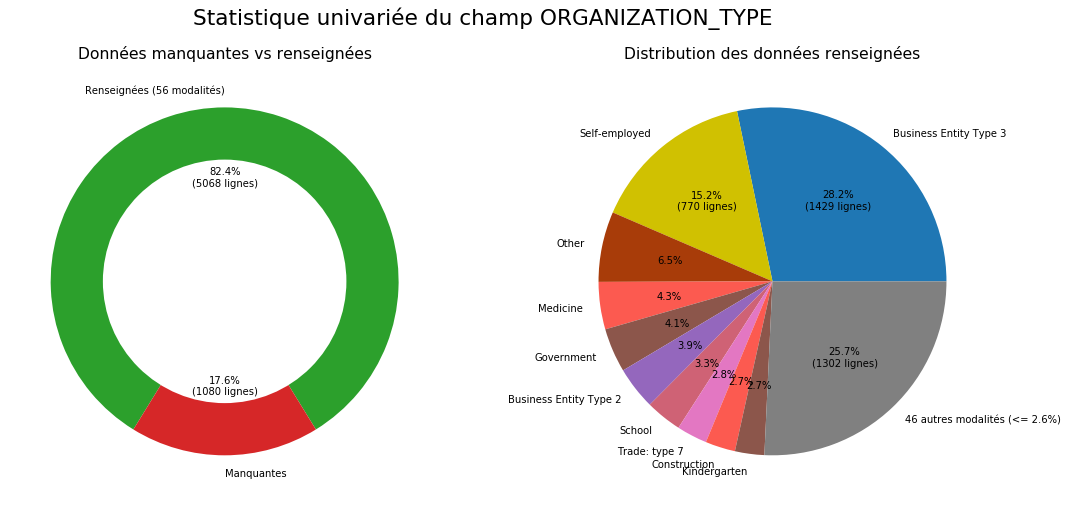

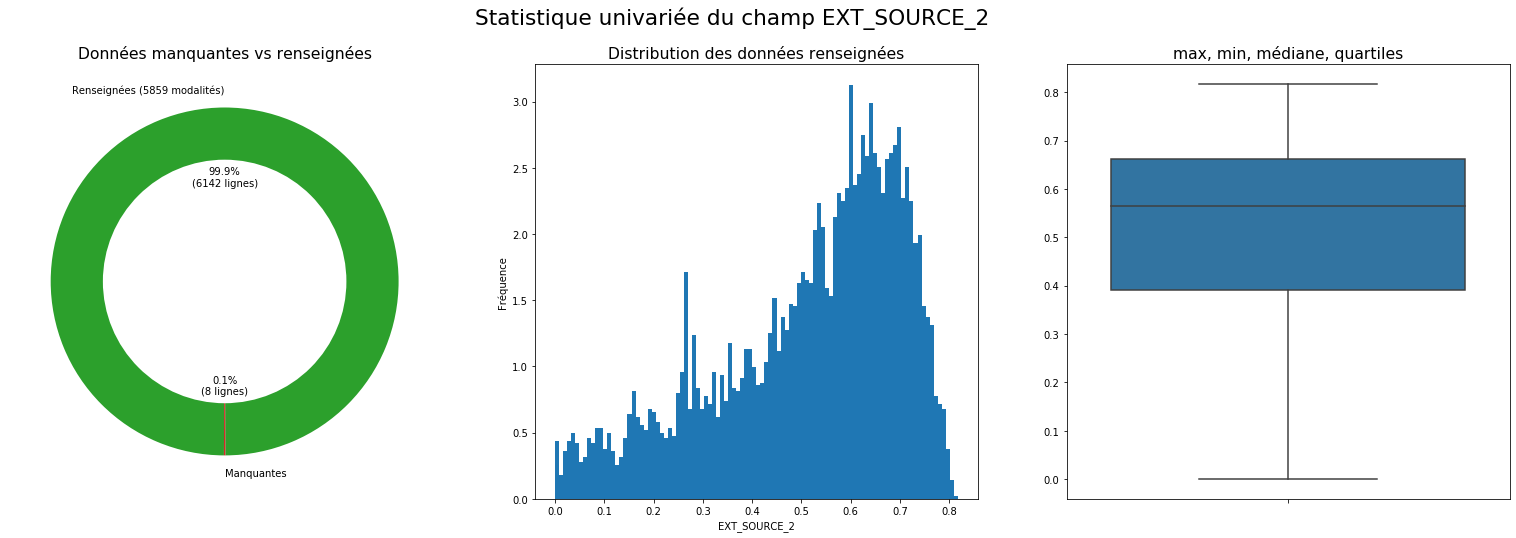

Mesures de position
 - Moyenne: 0.51
 - Médiane: 0.56
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.39
 - Q75: 0.66
 - Max: 0.82
Mesures de forme
 - Skewness (asymétrie): -0.79
 - Kurtosis (applatissement): -0.26


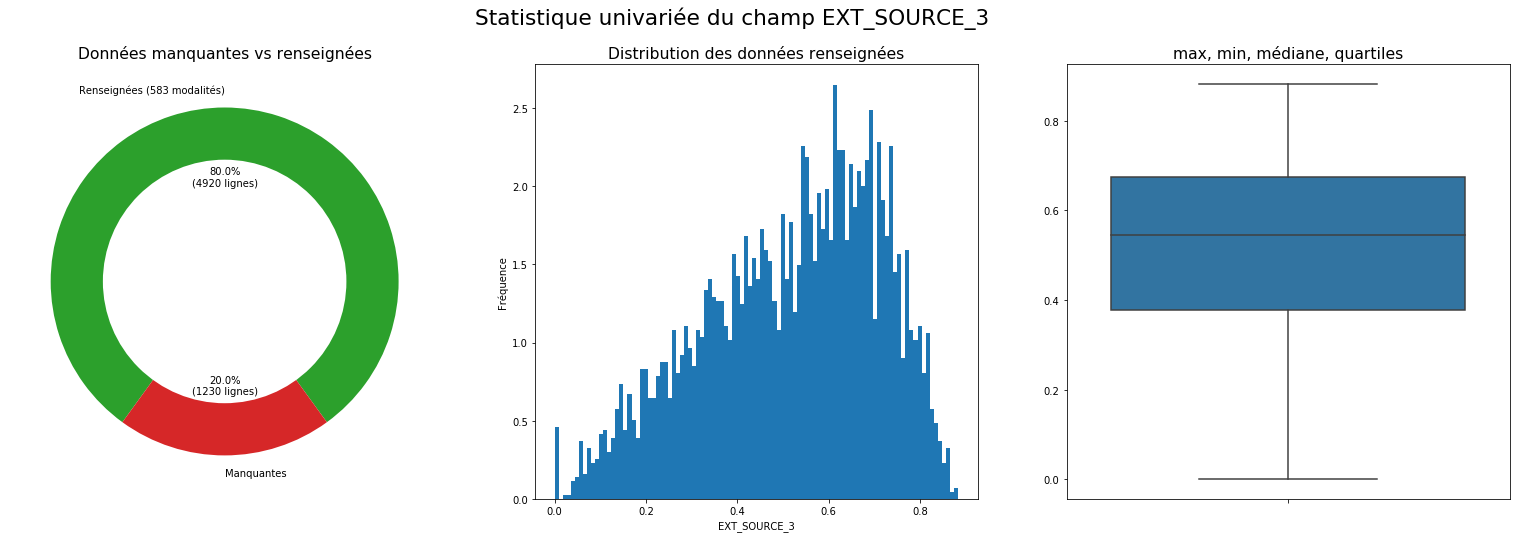

Mesures de position
 - Moyenne: 0.52
 - Médiane: 0.55
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.38
 - Q75: 0.67
 - Max: 0.88
Mesures de forme
 - Skewness (asymétrie): -0.44
 - Kurtosis (applatissement): -0.62


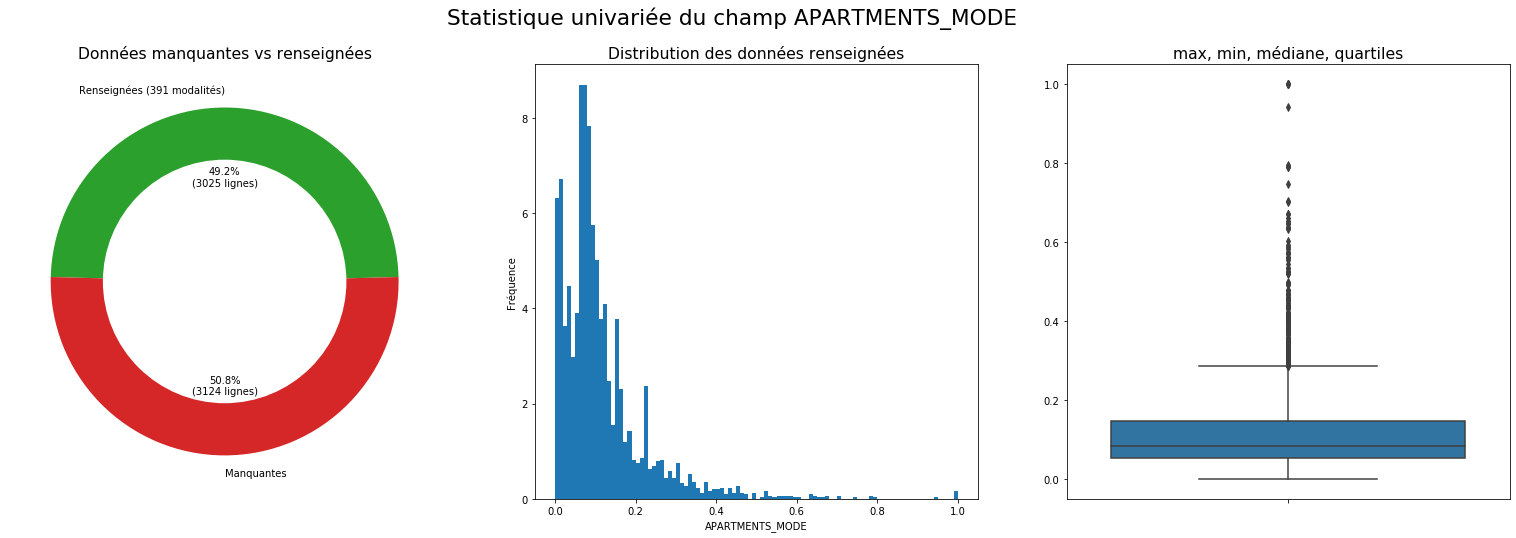

Mesures de position
 - Moyenne: 0.11
 - Médiane: 0.08
Mesures de dispertion
 - Ecart type: 0.11
 - Min: 0.0
 - Q25: 0.05
 - Q75: 0.15
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 2.79
 - Kurtosis (applatissement): 12.54


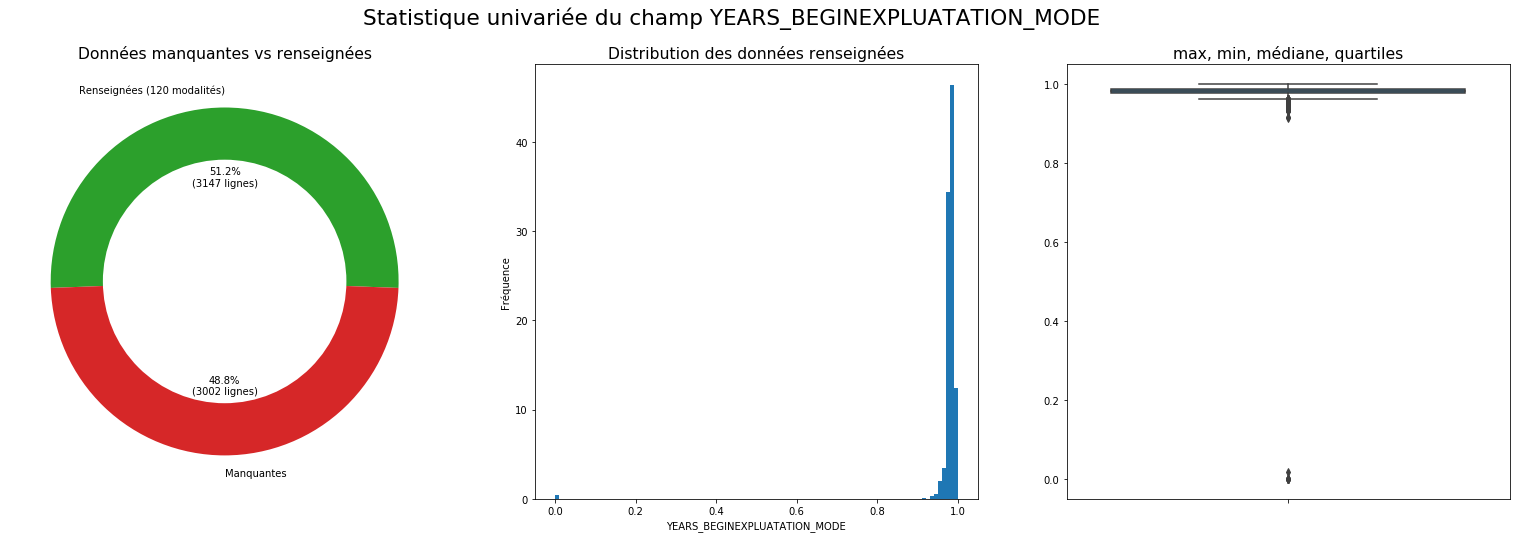

Mesures de position
 - Moyenne: 0.98
 - Médiane: 0.98
Mesures de dispertion
 - Ecart type: 0.06
 - Min: 0.0
 - Q25: 0.98
 - Q75: 0.99
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -15.0
 - Kurtosis (applatissement): 227.67


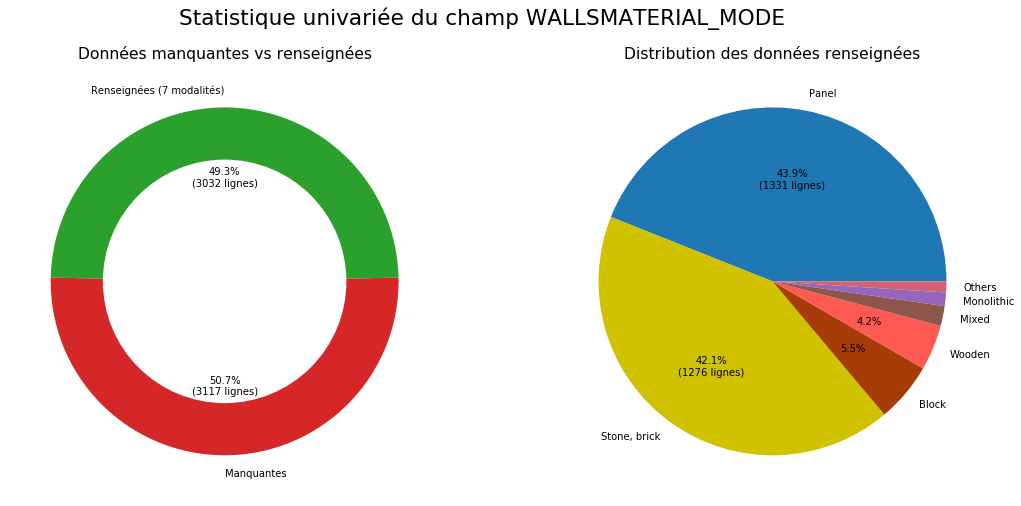

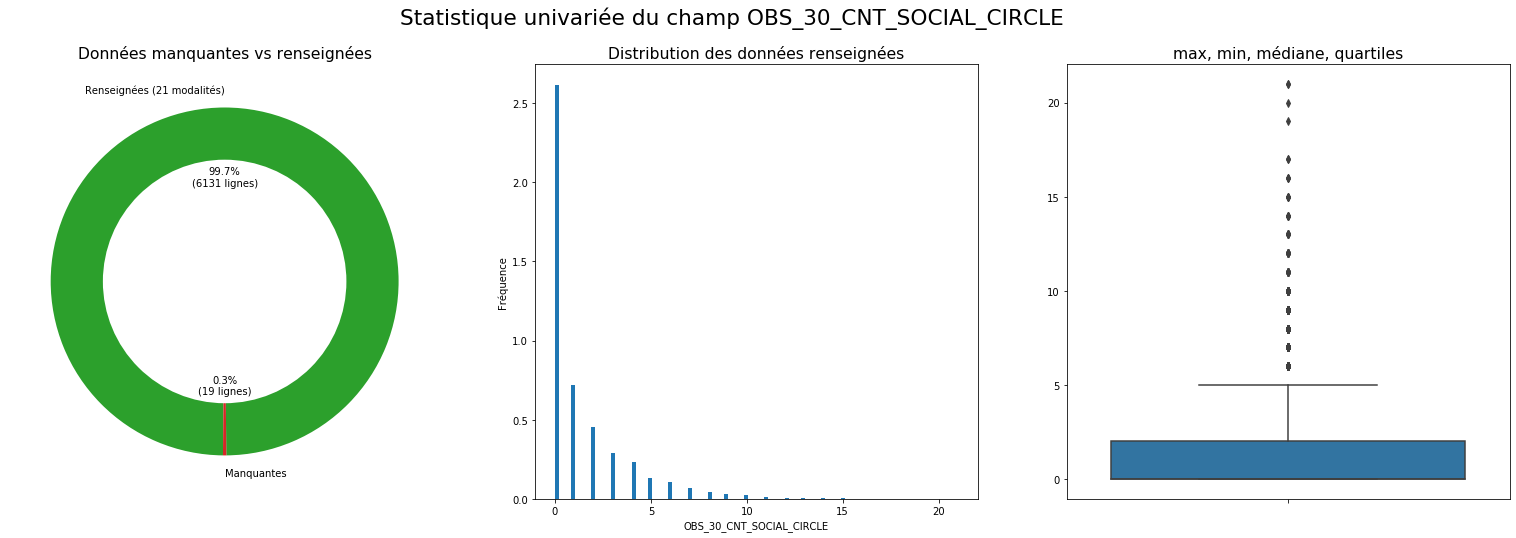

Mesures de position
 - Moyenne: 1.39
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 2.29
 - Min: 0.0
 - Q25: 0.0
 - Q75: 2.0
 - Max: 21.0
Mesures de forme
 - Skewness (asymétrie): 2.53
 - Kurtosis (applatissement): 8.85


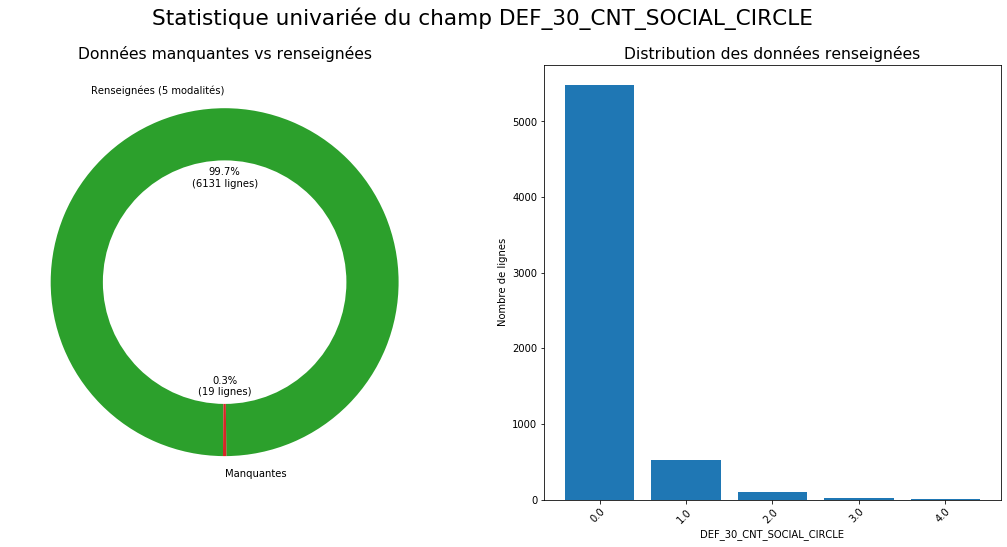

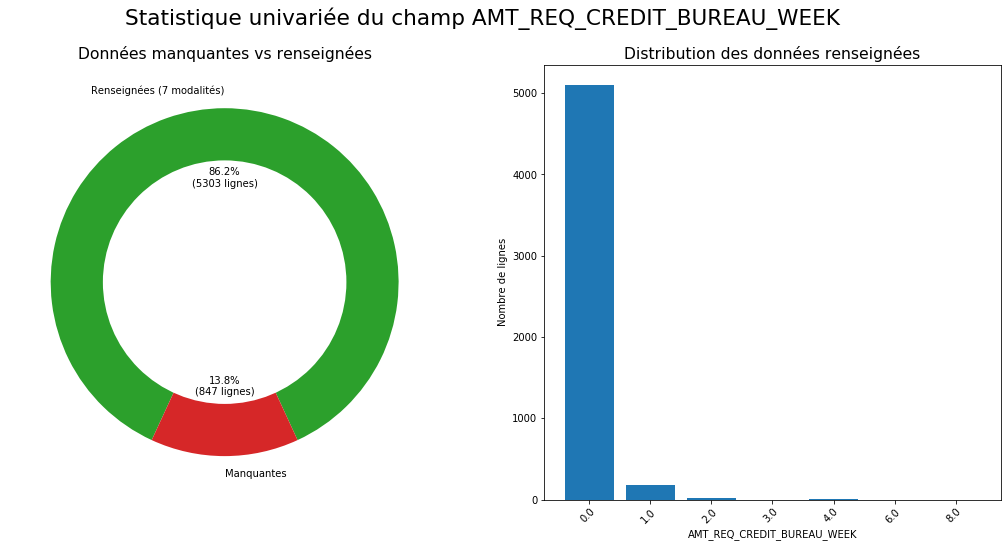

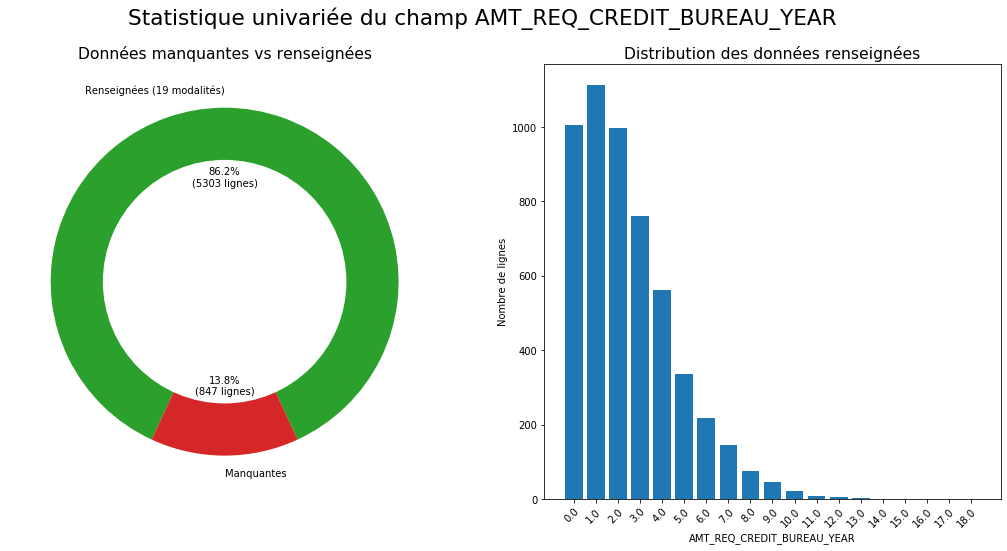

In [1365]:
myDf(dfApplication).Stat(typeStat='univ', statsNan=True, exclCol=['SK_ID_CURR'])

## Gestion des outliers

In [1366]:
dfApplication = dfApplication[(dfApplication.AMT_REQ_CREDIT_BUREAU_YEAR < 50) | dfApplication.AMT_REQ_CREDIT_BUREAU_YEAR.isnull()]
dfApplication = dfApplication[(dfApplication.OBS_30_CNT_SOCIAL_CIRCLE < 50) | dfApplication.OBS_30_CNT_SOCIAL_CIRCLE.isnull()]

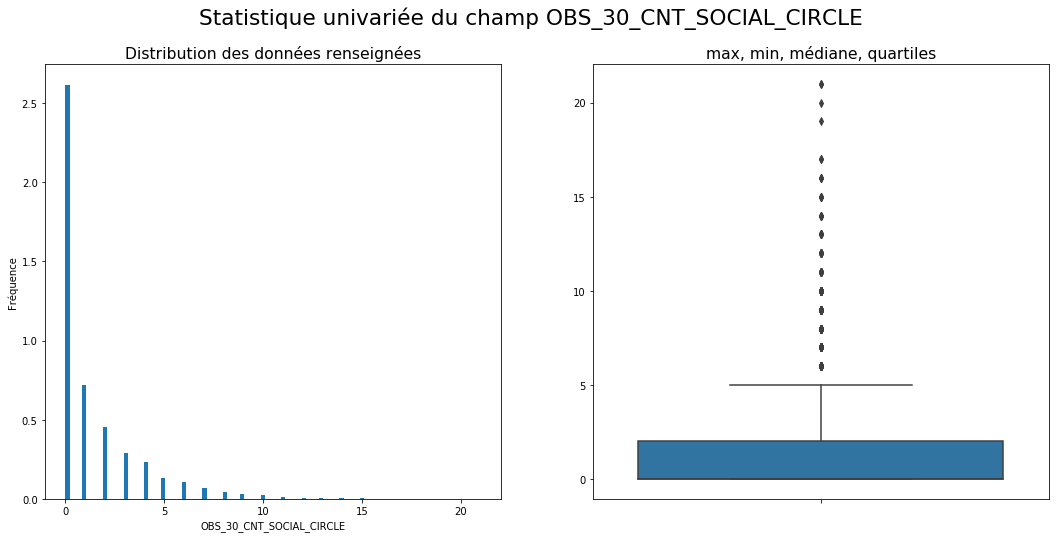

Mesures de position
 - Moyenne: 1.39
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 2.29
 - Min: 0.0
 - Q25: 0.0
 - Q75: 2.0
 - Max: 21.0
Mesures de forme
 - Skewness (asymétrie): 2.53
 - Kurtosis (applatissement): 8.85


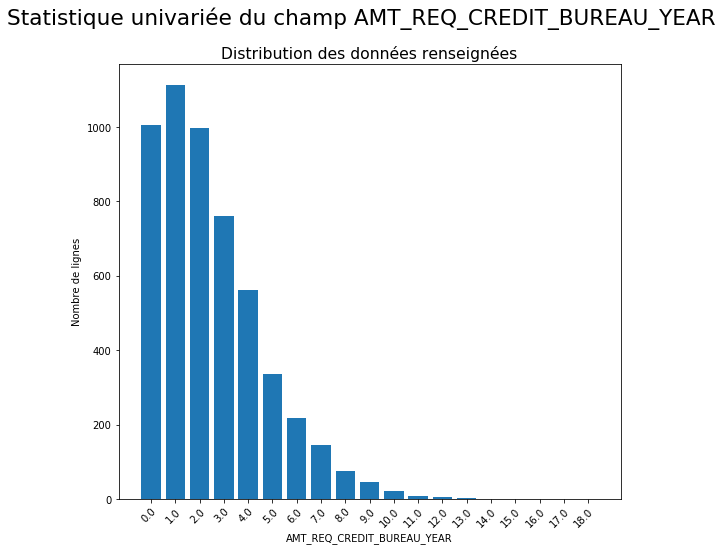

In [1367]:
myDf(dfApplication).Stat(['OBS_30_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_YEAR'], typeStat='univ')

# Exploration de PreviousApplication

## Statistiques par current application

In [1368]:
nbWithPrevious = dfApplication[dfApplication.SK_ID_CURR.isin(dfPreviousApplication.SK_ID_CURR)].shape[0]
nbWithoutPrevious = dfApplication[~dfApplication.SK_ID_CURR.isin(dfPreviousApplication.SK_ID_CURR)].shape[0]
print("{} loans sans previous ({}%)".format(nbWithoutPrevious, np.round(100 * nbWithoutPrevious / (nbWithPrevious + nbWithoutPrevious), 1)))

337 loans sans previous (5.5%)


Text(0.5, 1.0, 'Stat nb previous application at credit bureau')

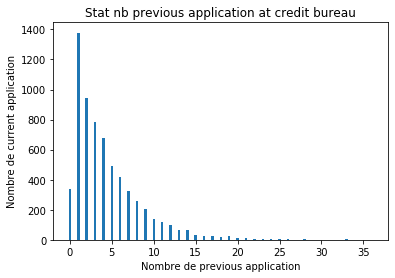

In [1369]:
distrib_nb_previous = dfApplication.merge(dfPreviousApplication[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')['SK_ID_CURR'].value_counts().value_counts()
distrib_nb_previous[0] = nbWithoutPrevious
tmp = pd.DataFrame({'nb_previous': pd.Series(distrib_nb_previous.index),
                   'nb_application': distrib_nb_previous.reset_index(drop=True)}).sort_values('nb_previous')
plt.bar(pd.Series(distrib_nb_previous.index), distrib_nb_previous.reset_index(drop=True), width=0.3)
plt.xlabel('Nombre de previous application')
plt.ylabel('Nombre de current application')
plt.title("Stat nb previous application at credit bureau")

## Suppression de lignes non pertinentes

In [1370]:
dfPreviousApplication = dfPreviousApplication[(dfPreviousApplication.FLAG_LAST_APPL_PER_CONTRACT == 'Y') & (dfPreviousApplication.NFLAG_LAST_APPL_IN_DAY == 1)]

In [1371]:
dfPreviousApplication.NAME_CONTRACT_STATUS.value_counts()

Approved        17827
Canceled         5141
Refused          4595
Unused offer      500
Name: NAME_CONTRACT_STATUS, dtype: int64

In [1372]:
dfPreviousApplication = dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS.isin(['Approved','Refused'])]

## Suppression de variables non pertinentes

### Fonctionnellement inintéressantes

In [1373]:
del dfPreviousApplication['FLAG_LAST_APPL_PER_CONTRACT'] # Flag if it was last application for the previous contract. Sometimes by mistake of client or our clerk there could be more applications for one single contract
del dfPreviousApplication['NFLAG_LAST_APPL_IN_DAY'] # Flag if the application was the last application per day of the client. Sometimes clients apply for more applications a day. Rarely it could also be error in our system that one application is in the database twice

del dfPreviousApplication['NAME_TYPE_SUITE'] # Who accompanied client when applying for the previous application
del dfPreviousApplication['WEEKDAY_APPR_PROCESS_START'] #On which day of the week did the client apply for the loan
del dfPreviousApplication['HOUR_APPR_PROCESS_START'] #Approximately at what hour did the client apply for the loan
del dfPreviousApplication['NAME_CLIENT_TYPE'] #Was the client old or new client when applying for the previous application
del dfPreviousApplication['SELLERPLACE_AREA'] #Selling area of seller place of the previous application

### Trop de valeurs manquantes

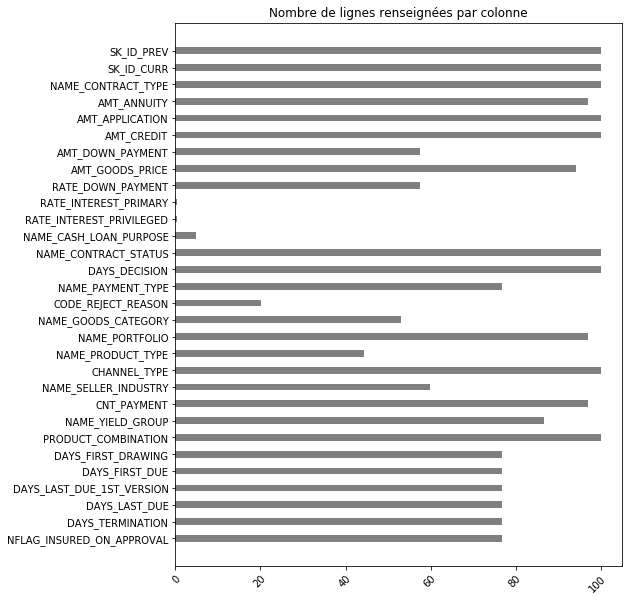

In [1374]:
myDf(dfPreviousApplication).ColCountLinesChart(typeChart='barh', displayColName=True)

In [1375]:
del dfPreviousApplication['RATE_INTEREST_PRIMARY']
del dfPreviousApplication['RATE_INTEREST_PRIVILEGED']
del dfPreviousApplication['NAME_CASH_LOAN_PURPOSE']

### Trop de valeurs identiques

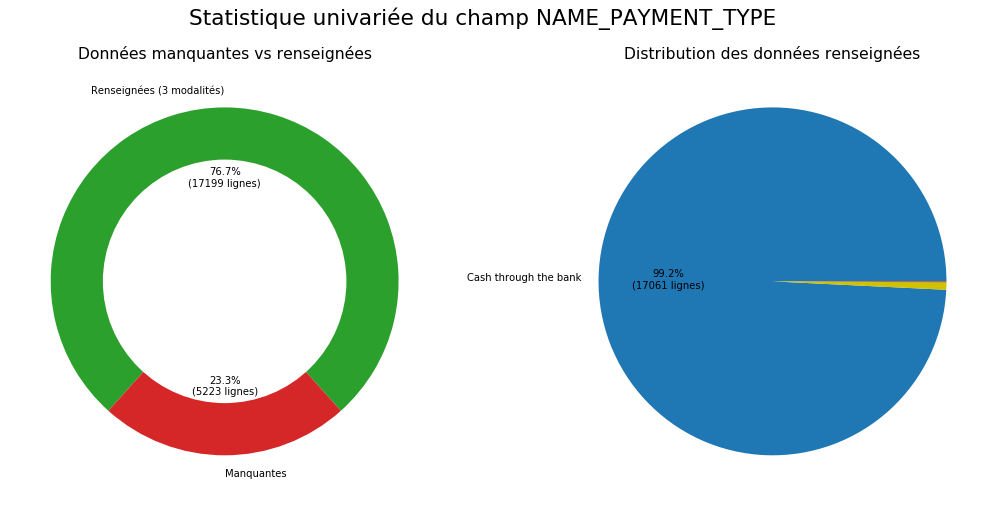

In [1376]:
myDf(dfPreviousApplication).Stat(['NAME_PAYMENT_TYPE'],typeStat='univ', statsNan=True)

In [1377]:
del dfPreviousApplication['NAME_PAYMENT_TYPE']

## Recherche de corrélations

### Champs days

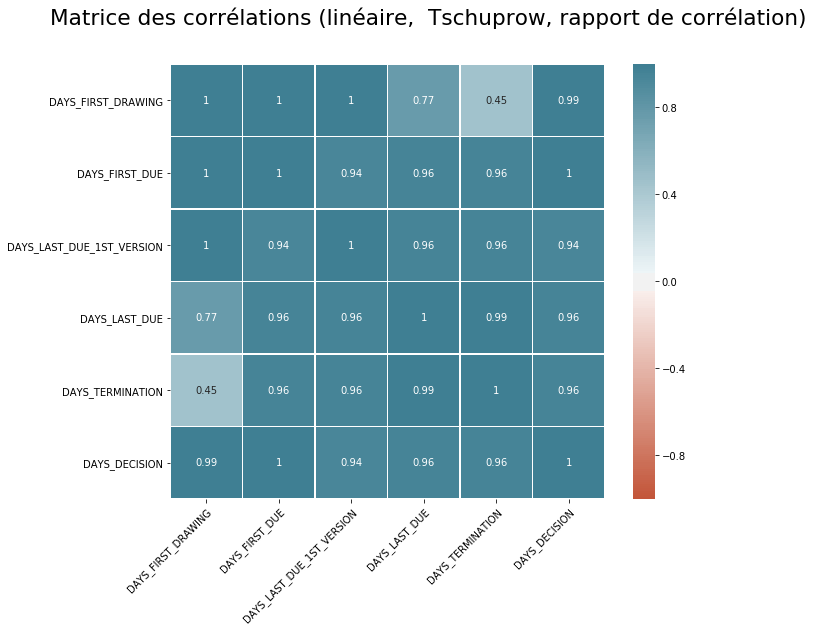

In [1378]:
myDf(dfPreviousApplication.replace(365243,np.nan)).Stat(['DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION','DAYS_DECISION'], bivOnlyCorrTable=True, typeStat='biv')

In [1379]:
del dfPreviousApplication['DAYS_FIRST_DRAWING']
del dfPreviousApplication['DAYS_FIRST_DUE']
del dfPreviousApplication['DAYS_LAST_DUE_1ST_VERSION']
del dfPreviousApplication['DAYS_LAST_DUE']
del dfPreviousApplication['DAYS_TERMINATION']

### Montants

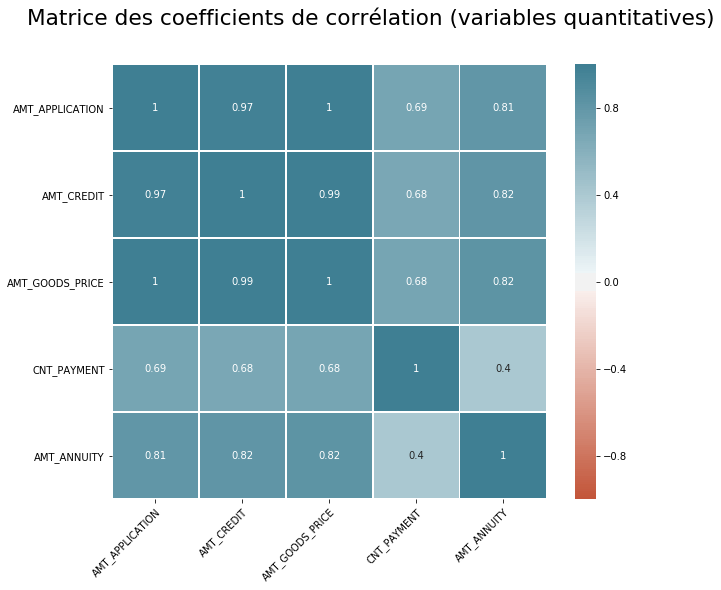

In [1380]:
myDf(dfPreviousApplication).Stat(['AMT_APPLICATION','AMT_CREDIT','AMT_GOODS_PRICE','CNT_PAYMENT','AMT_ANNUITY'], typeStat='biv', bivThresholdCorr=2) 

In [1381]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['AMT_APPLICATION','AMT_CREDIT','AMT_GOODS_PRICE','CNT_PAYMENT','AMT_ANNUITY']].isnull()).sum()

Nombre de lignes avec le champ vide:


AMT_APPLICATION       0
AMT_CREDIT            0
AMT_GOODS_PRICE    1306
CNT_PAYMENT         652
AMT_ANNUITY         652
dtype: int64

In [1382]:
del dfPreviousApplication['AMT_APPLICATION']
del dfPreviousApplication['AMT_GOODS_PRICE']
del dfPreviousApplication['AMT_ANNUITY']
del dfPreviousApplication['CNT_PAYMENT']

### Contract type portfolio name

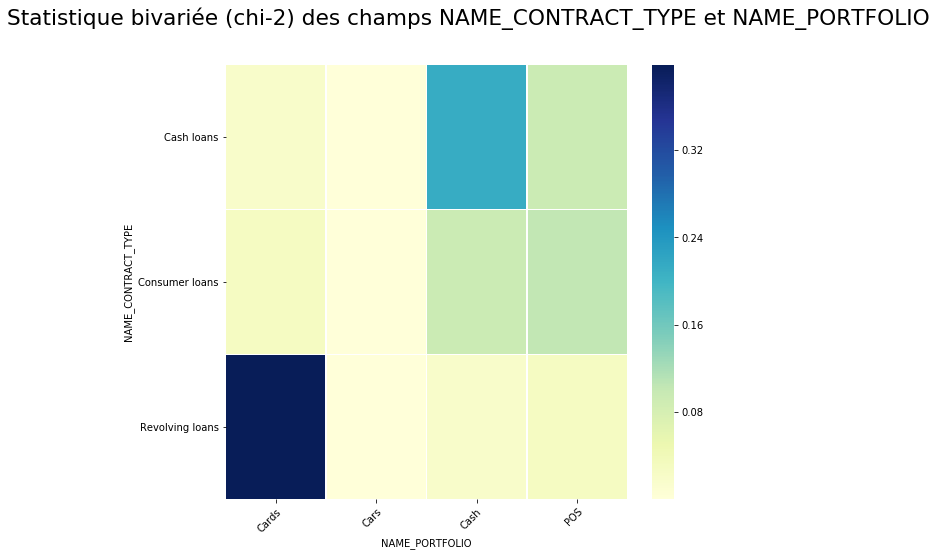

chi-2 entre NAME_CONTRACT_TYPE et NAME_PORTFOLIO : 43539.999999999985 
phi-2 entre NAME_CONTRACT_TYPE et NAME_PORTFOLIO : 1.9999999999999993 
coefficient T de Tschuprow entre NAME_CONTRACT_TYPE et NAME_PORTFOLIO : 0.9036020036098447 
coefficient C de Cramer entre NAME_CONTRACT_TYPE et NAME_PORTFOLIO : 0.9999999999999998 


In [1383]:
myDf(dfPreviousApplication).Stat(['NAME_CONTRACT_TYPE','NAME_PORTFOLIO'], typeStat='biv')

In [1384]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['NAME_CONTRACT_TYPE','NAME_PORTFOLIO']].isnull()).sum()

Nombre de lignes avec le champ vide:


NAME_CONTRACT_TYPE      0
NAME_PORTFOLIO        652
dtype: int64

In [1385]:
del dfPreviousApplication['NAME_PORTFOLIO']

### Contract status, code reject reason

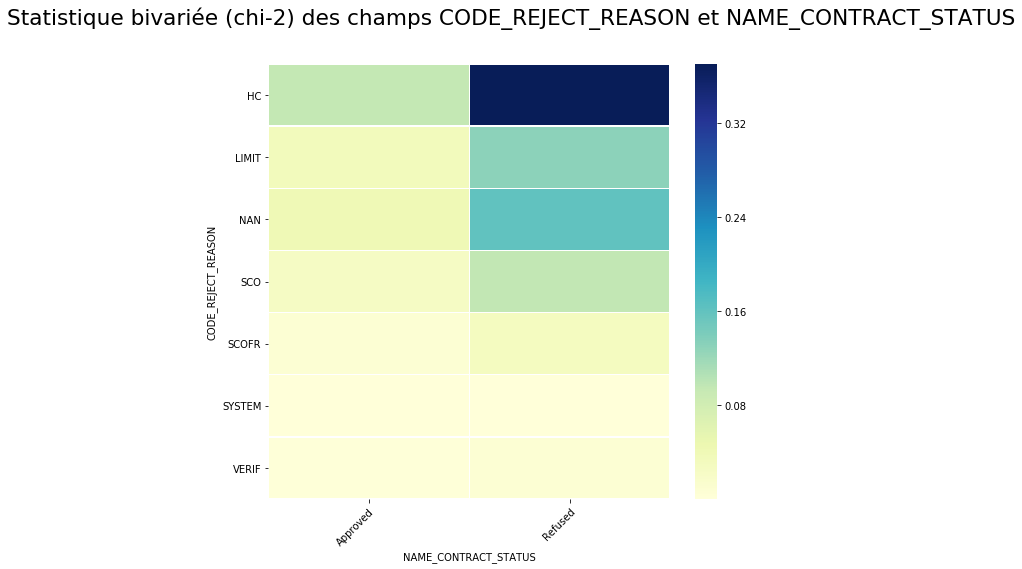

chi-2 entre CODE_REJECT_REASON et NAME_CONTRACT_STATUS : 22061.087465007797 
phi-2 entre CODE_REJECT_REASON et NAME_CONTRACT_STATUS : 0.9839036421821334 
coefficient T de Tschuprow entre CODE_REJECT_REASON et NAME_CONTRACT_STATUS : 0.6337799144040653 
coefficient C de Cramer entre CODE_REJECT_REASON et NAME_CONTRACT_STATUS : 0.9919191711939706 


In [1386]:
myDf(dfPreviousApplication.replace(np.nan,'NAN')).Stat(['NAME_CONTRACT_STATUS','CODE_REJECT_REASON'], typeStat='biv')

In [1387]:
dfPreviousApplication[['NAME_CONTRACT_STATUS','CODE_REJECT_REASON']].replace(np.nan,'NAN').groupby(['NAME_CONTRACT_STATUS','CODE_REJECT_REASON']).size()

NAME_CONTRACT_STATUS  CODE_REJECT_REASON
Approved              NAN                   17827
Refused               HC                     2647
                      LIMIT                   931
                      NAN                      59
                      SCO                     685
                      SCOFR                   217
                      SYSTEM                    2
                      VERIF                    54
dtype: int64

In [1388]:
del dfPreviousApplication['CODE_REJECT_REASON']

### Contract_type, channel_type, flag_insurance

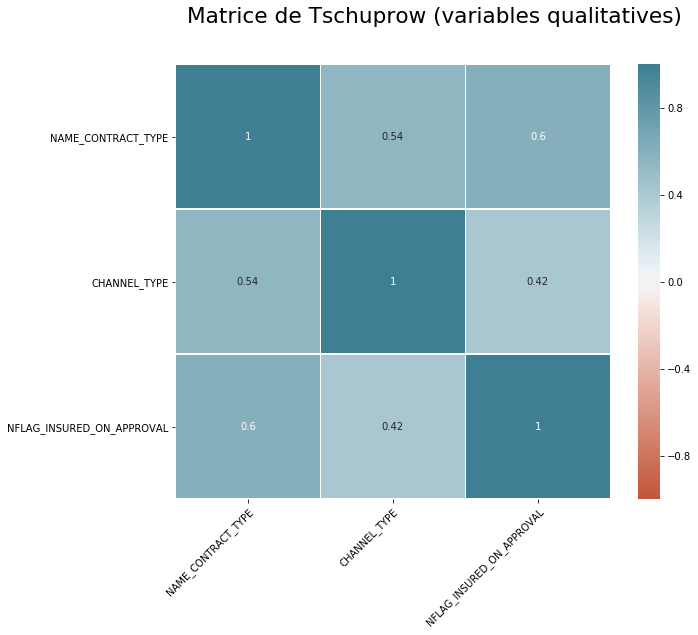

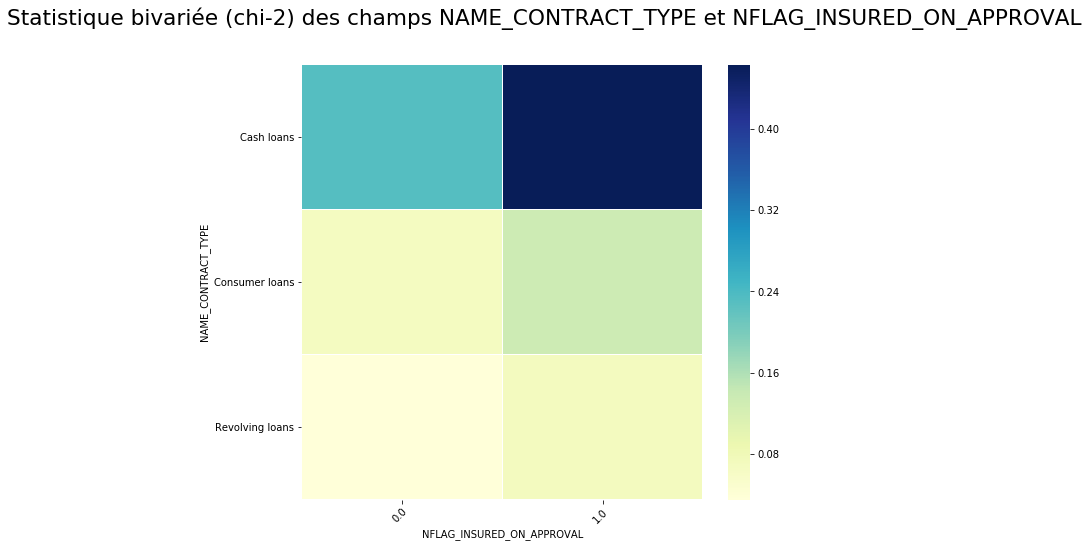

chi-2 entre NAME_CONTRACT_TYPE et NFLAG_INSURED_ON_APPROVAL : 7329.823549912586 
phi-2 entre NAME_CONTRACT_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.4261773097222272 
coefficient T de Tschuprow entre NAME_CONTRACT_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.5489561600824117 
coefficient C de Cramer entre NAME_CONTRACT_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.6528225713945768 


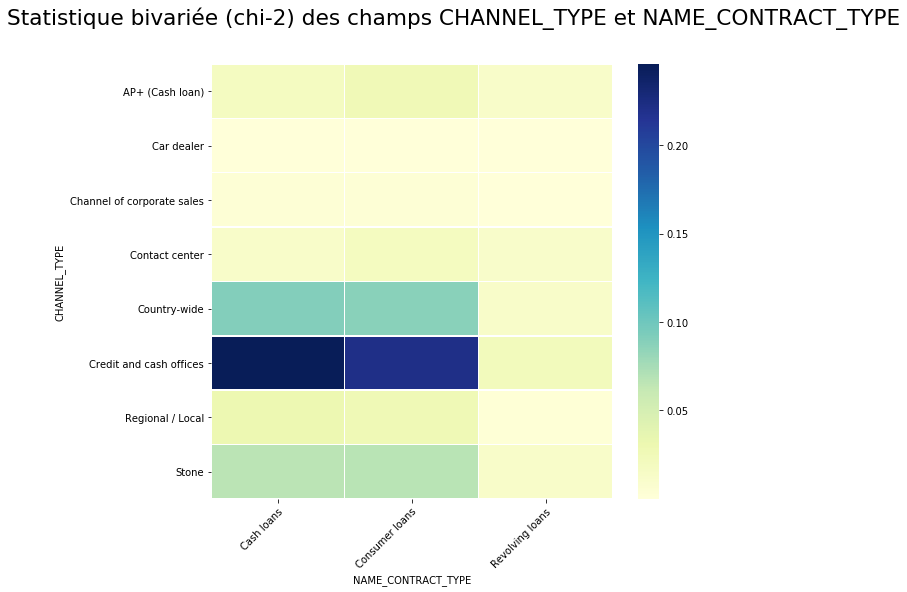

chi-2 entre CHANNEL_TYPE et NAME_CONTRACT_TYPE : 17734.06632250324 
phi-2 entre CHANNEL_TYPE et NAME_CONTRACT_TYPE : 0.7909225904247276 
coefficient T de Tschuprow entre CHANNEL_TYPE et NAME_CONTRACT_TYPE : 0.45976401965954716 
coefficient C de Cramer entre CHANNEL_TYPE et NAME_CONTRACT_TYPE : 0.6288571341826089 


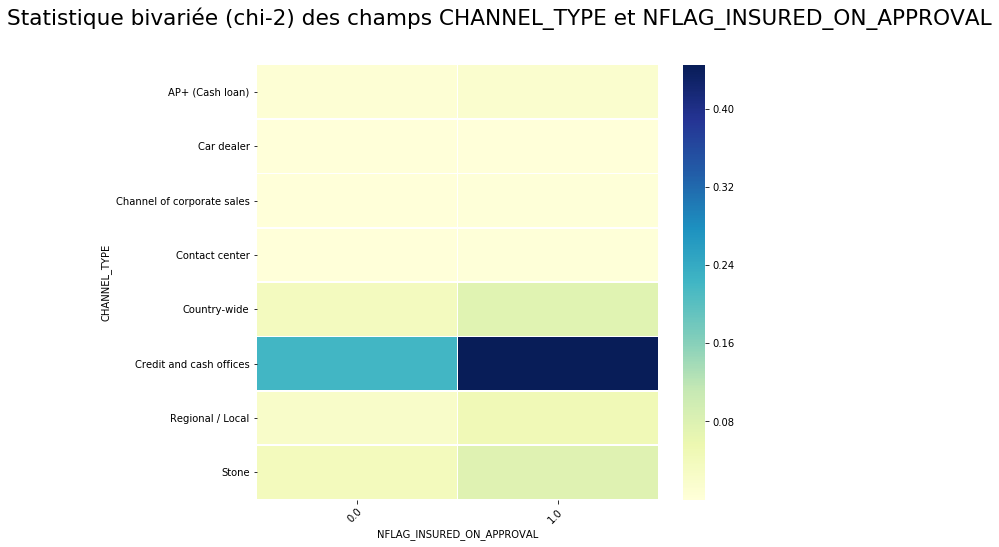

chi-2 entre CHANNEL_TYPE et NFLAG_INSURED_ON_APPROVAL : 4623.379856711014 
phi-2 entre CHANNEL_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.26881678334269515 
coefficient T de Tschuprow entre CHANNEL_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.31875255897350435 
coefficient C de Cramer entre CHANNEL_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.5184754414074935 


In [1389]:
myDf(dfPreviousApplication).Stat(['NAME_CONTRACT_TYPE','CHANNEL_TYPE','NFLAG_INSURED_ON_APPROVAL'], typeStat='biv')

C'est le flag insurance qui est le moins souvent renseigné

In [1390]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['NAME_CONTRACT_TYPE','CHANNEL_TYPE','NFLAG_INSURED_ON_APPROVAL']].isnull()).sum()

Nombre de lignes avec le champ vide:


NAME_CONTRACT_TYPE              0
CHANNEL_TYPE                    0
NFLAG_INSURED_ON_APPROVAL    5223
dtype: int64

Mais c'est surtout sur les crédit refusés que le flag insurance n'est pas renseigné

In [1391]:
dfPreviousApplication[['NAME_CONTRACT_STATUS','NFLAG_INSURED_ON_APPROVAL']].replace(np.nan, -99).groupby(['NAME_CONTRACT_STATUS','NFLAG_INSURED_ON_APPROVAL']).size()

NAME_CONTRACT_STATUS  NFLAG_INSURED_ON_APPROVAL
Approved              -99.0                          628
                       0.0                         11482
                       1.0                          5717
Refused               -99.0                         4595
dtype: int64

De plus, la majeur partie des SK_ID_CURR ont au moins un SK_ID_PREV avec le flag insurance renseigné

In [1392]:
NB_SK_ID_CURR_WITH_INSURANCE_FLAG = len(dfPreviousApplication[~dfPreviousApplication.NFLAG_INSURED_ON_APPROVAL.isnull()].SK_ID_CURR.unique())
NB_SK_ID_CURR = len(dfPreviousApplication.SK_ID_CURR.unique())
print("{} SK_ID_CURR sur {} n'ont aucune ligne avec un flag insurrance renseigné".format(NB_SK_ID_CURR-NB_SK_ID_CURR_WITH_INSURANCE_FLAG,NB_SK_ID_CURR))

22 SK_ID_CURR sur 5804 n'ont aucune ligne avec un flag insurrance renseigné


Donc on conserve le flag insurance car c'est un flag

In [1393]:
del dfPreviousApplication['CHANNEL_TYPE']
del dfPreviousApplication['NAME_CONTRACT_TYPE']

### Name yield group et product combination

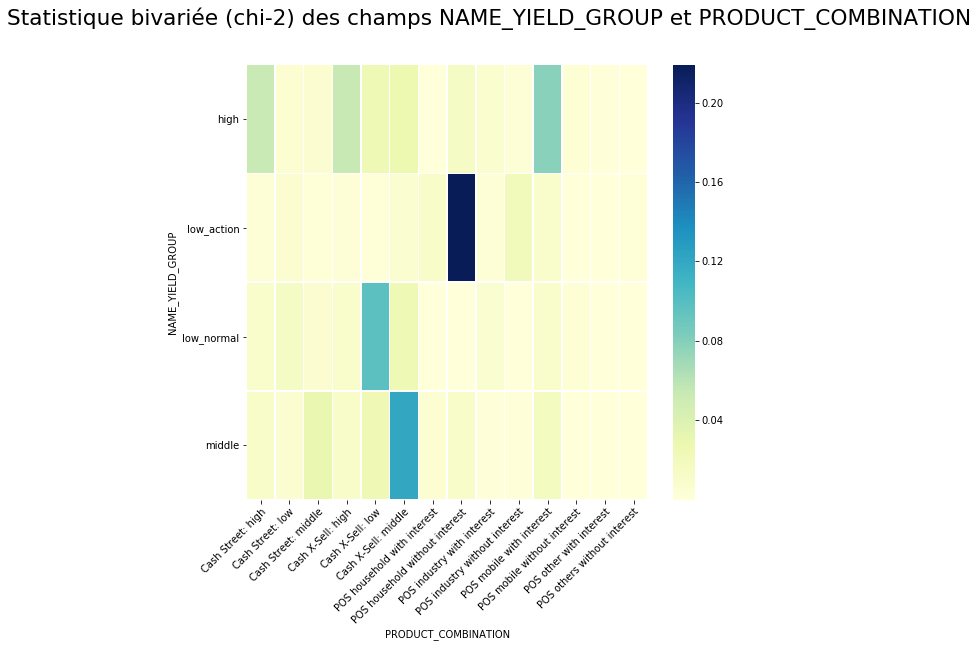

chi-2 entre NAME_YIELD_GROUP et PRODUCT_COMBINATION : 27465.238517588965 
phi-2 entre NAME_YIELD_GROUP et PRODUCT_COMBINATION : 1.4134752981106975 
coefficient T de Tschuprow entre NAME_YIELD_GROUP et PRODUCT_COMBINATION : 0.4757490829581925 
coefficient C de Cramer entre NAME_YIELD_GROUP et PRODUCT_COMBINATION : 0.686409813962159 


In [1394]:
myDf(dfPreviousApplication).Stat(['NAME_YIELD_GROUP','PRODUCT_COMBINATION'], typeStat='biv')

In [1395]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['NAME_YIELD_GROUP','PRODUCT_COMBINATION']].isnull()).sum()

Nombre de lignes avec le champ vide:


NAME_YIELD_GROUP       2991
PRODUCT_COMBINATION       0
dtype: int64

In [1396]:
NB_SK_ID_CURR_WITH_YIELD_GROUP = len(dfPreviousApplication[~dfPreviousApplication.NAME_YIELD_GROUP.isnull()].SK_ID_CURR.unique())
NB_SK_ID_CURR = len(dfPreviousApplication.SK_ID_CURR.unique())
print("{} SK_ID_CURR sur {} n'ont aucune ligne avec un yield group renseigné".format(NB_SK_ID_CURR-NB_SK_ID_CURR_WITH_YIELD_GROUP,NB_SK_ID_CURR))

39 SK_ID_CURR sur 5804 n'ont aucune ligne avec un yield group renseigné


On conserve NAME_YIELD_GROUP car c'est une variable ordonnable

In [1397]:
del dfPreviousApplication['PRODUCT_COMBINATION']

### Name seller industry, name goods category

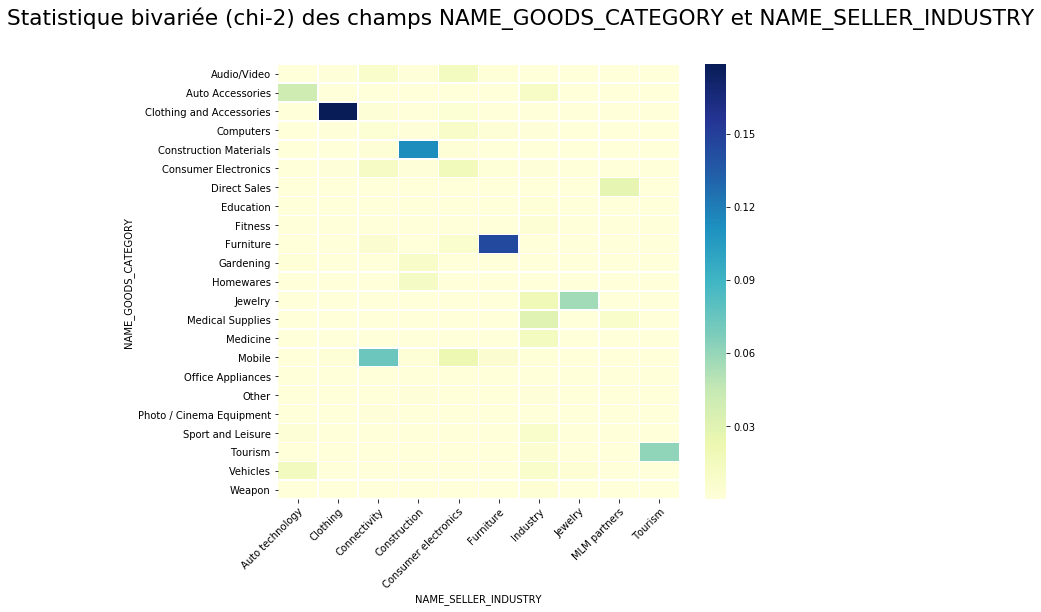

chi-2 entre NAME_GOODS_CATEGORY et NAME_SELLER_INDUSTRY : 54997.23926887873 
phi-2 entre NAME_GOODS_CATEGORY et NAME_SELLER_INDUSTRY : 4.6403340591359035 
coefficient T de Tschuprow entre NAME_GOODS_CATEGORY et NAME_SELLER_INDUSTRY : 0.5742596815428574 
coefficient C de Cramer entre NAME_GOODS_CATEGORY et NAME_SELLER_INDUSTRY : 0.7180478209961525 


In [1398]:
myDf(dfPreviousApplication).Stat(['NAME_SELLER_INDUSTRY','NAME_GOODS_CATEGORY'], typeStat='biv')

In [1399]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['NAME_SELLER_INDUSTRY','NAME_GOODS_CATEGORY']].isnull()).sum()

Nombre de lignes avec le champ vide:


NAME_SELLER_INDUSTRY     8992
NAME_GOODS_CATEGORY     10549
dtype: int64

In [1400]:
del dfPreviousApplication['NAME_GOODS_CATEGORY']

### Down payment

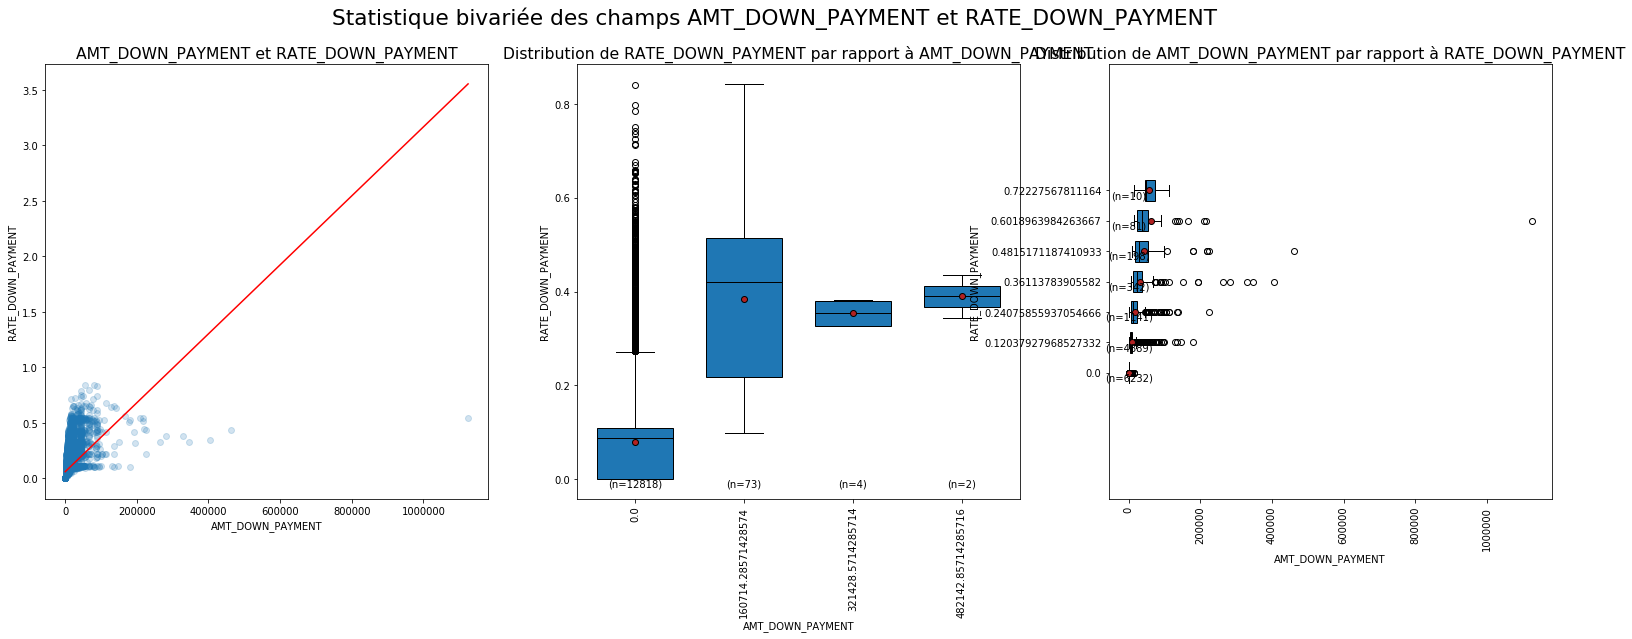

Covariance entre AMT_DOWN_PAYMENT et RATE_DOWN_PAYMENT : 1020.0509419615499 
Covariance débiaisée entre AMT_DOWN_PAYMENT et RATE_DOWN_PAYMENT : 1020.130034071495 
Coefficient de correlation linéaire entre AMT_DOWN_PAYMENT et RATE_DOWN_PAYMENT : 0.5203850239564967 
Régression linéaire entre AMT_DOWN_PAYMENT et RATE_DOWN_PAYMENT: y = 3.104778904080165e-06x + 0.061352752956653475
Coefficient de détermination entre AMT_DOWN_PAYMENT et RATE_DOWN_PAYMENT : 0.2708005731582036 


In [1401]:
myDf(dfPreviousApplication).Stat(['AMT_DOWN_PAYMENT','RATE_DOWN_PAYMENT'], typeStat='biv')

In [1402]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['AMT_DOWN_PAYMENT','RATE_DOWN_PAYMENT']].isnull()).sum()

Nombre de lignes avec le champ vide:


AMT_DOWN_PAYMENT     9524
RATE_DOWN_PAYMENT    9524
dtype: int64

In [1403]:
del dfPreviousApplication['AMT_DOWN_PAYMENT']

### Matrice des corrélations des variables restantes

/home/pierre/Documents/openclassrooms/Projet_7/Git/credit_scoring/myTools.py:1477: RuntimeWarning: invalid value encountered in double_scalars
  tschuprow = math.sqrt(phi2 / math.sqrt((r-1)*(c-1)))
/home/pierre/Documents/openclassrooms/Projet_7/Git/credit_scoring/myTools.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  cramer = math.sqrt(phi2/(min(r,c)-1))


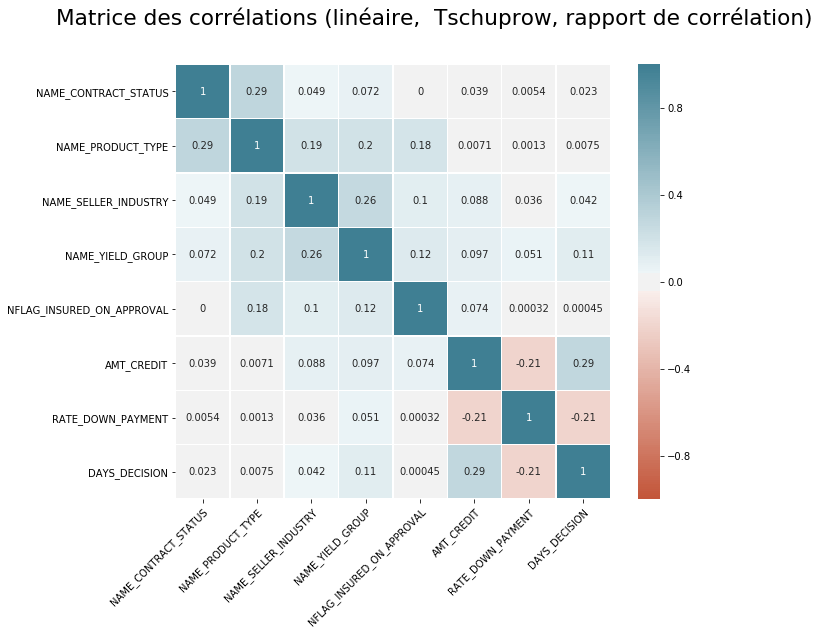

In [1404]:
myDf(dfPreviousApplication).Stat(exclCol=['SK_ID_CURR','SK_ID_PREV'], typeStat='biv', bivOnlyCorrTable=True)

## Statistique univariée

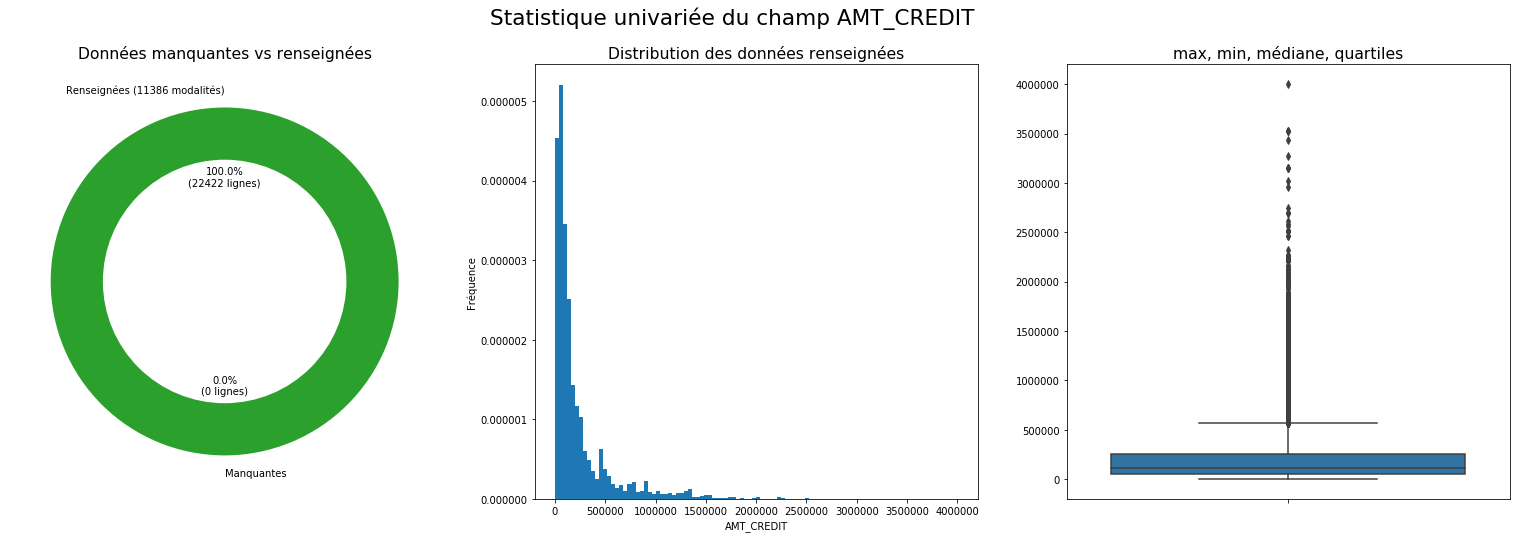

Mesures de position
 - Moyenne: 233241.17
 - Médiane: 110819.25
Mesures de dispertion
 - Ecart type: 329219.72
 - Min: 0.0
 - Q25: 48003.75
 - Q75: 254700.0
 - Max: 4005000.0
Mesures de forme
 - Skewness (asymétrie): 3.07
 - Kurtosis (applatissement): 12.73


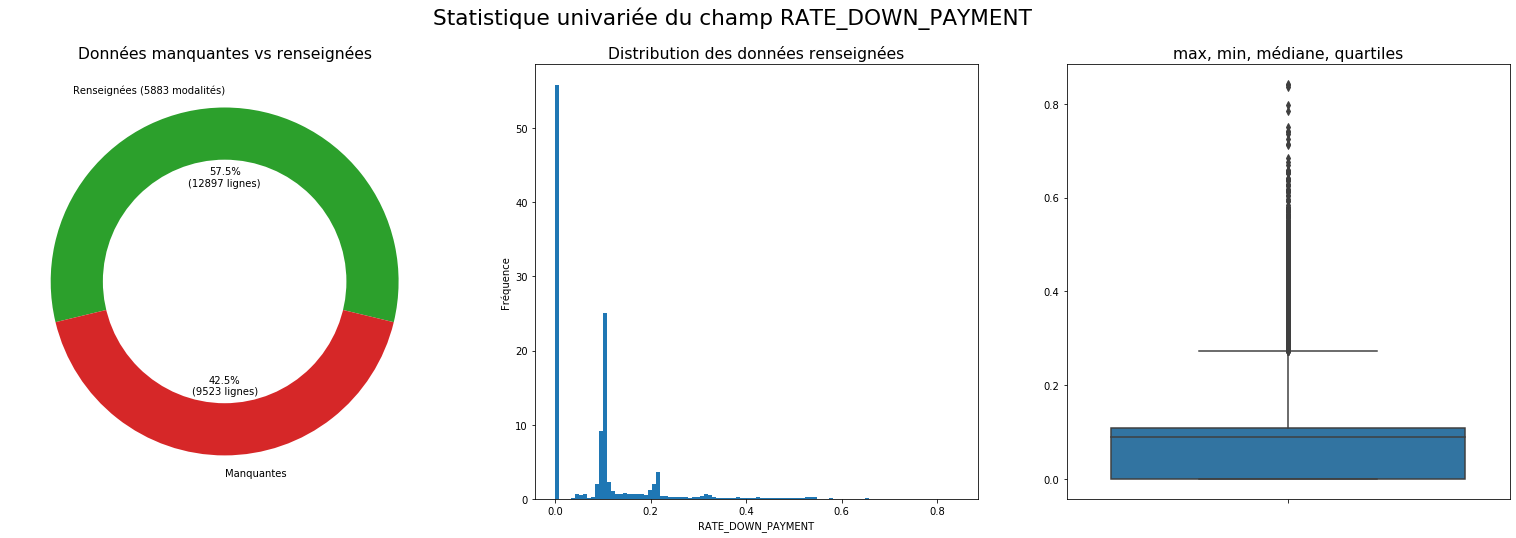

Mesures de position
 - Moyenne: 0.08
 - Médiane: 0.09
Mesures de dispertion
 - Ecart type: 0.11
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.11
 - Max: 0.84
Mesures de forme
 - Skewness (asymétrie): 2.1
 - Kurtosis (applatissement): 6.12


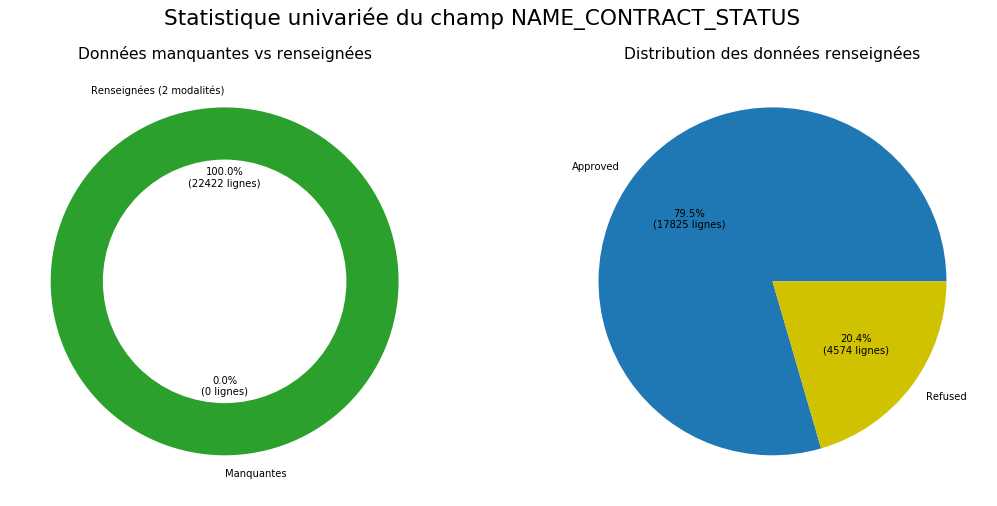

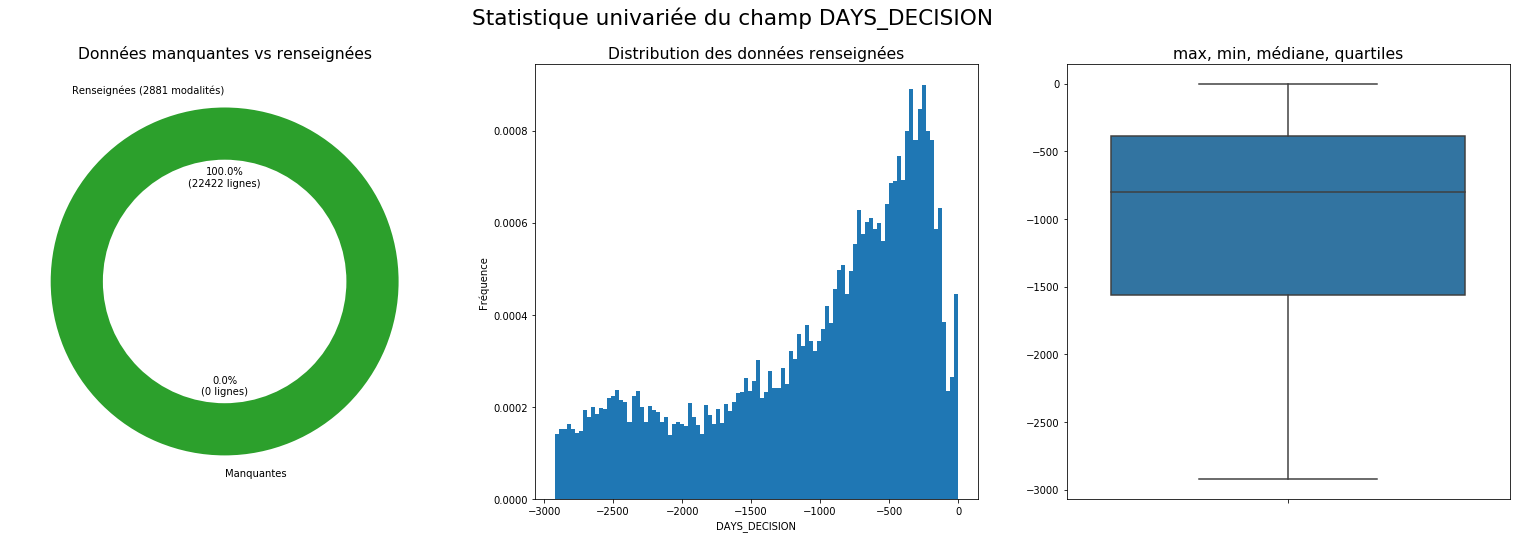

Mesures de position
 - Moyenne: -1044.12
 - Médiane: -800.0
Mesures de dispertion
 - Ecart type: 793.15
 - Min: -2922
 - Q25: -1564.0
 - Q75: -391.0
 - Max: -2
Mesures de forme
 - Skewness (asymétrie): -0.77
 - Kurtosis (applatissement): -0.58


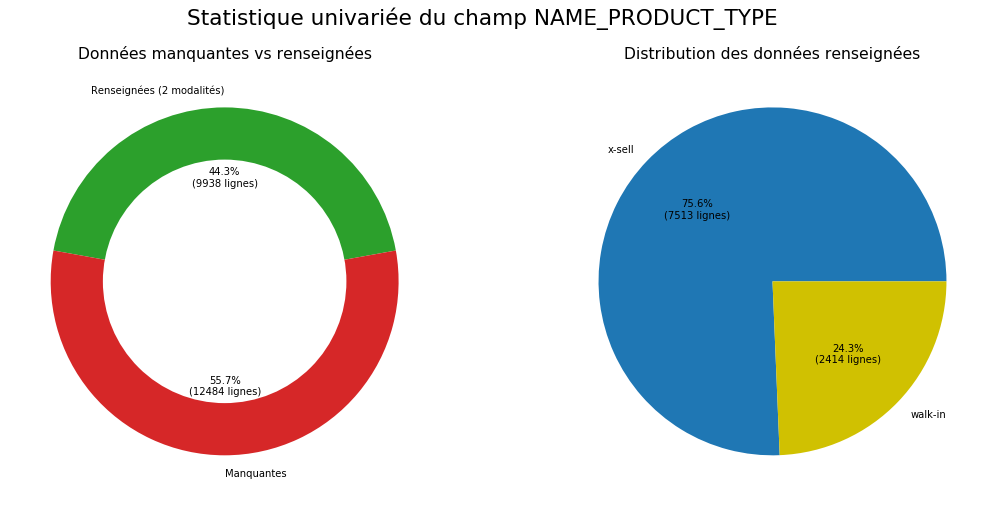

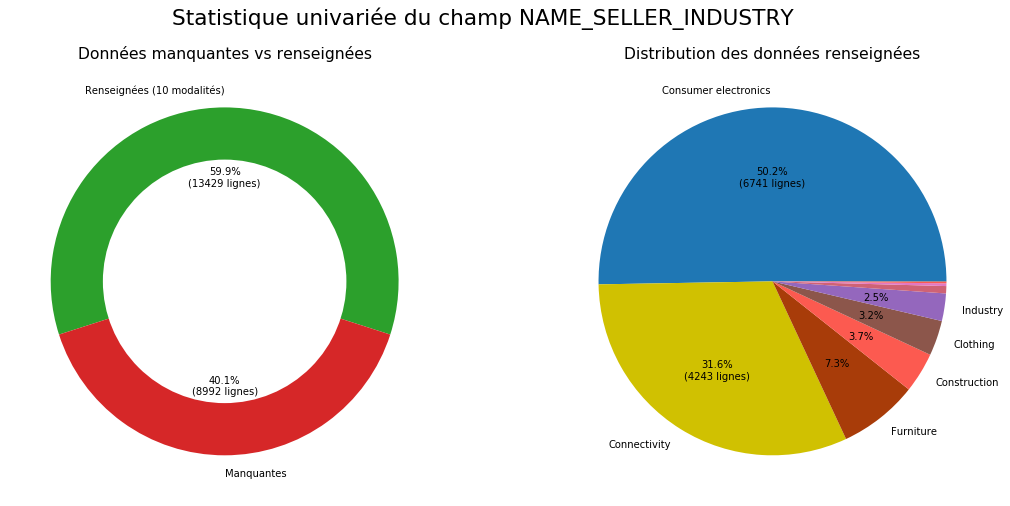

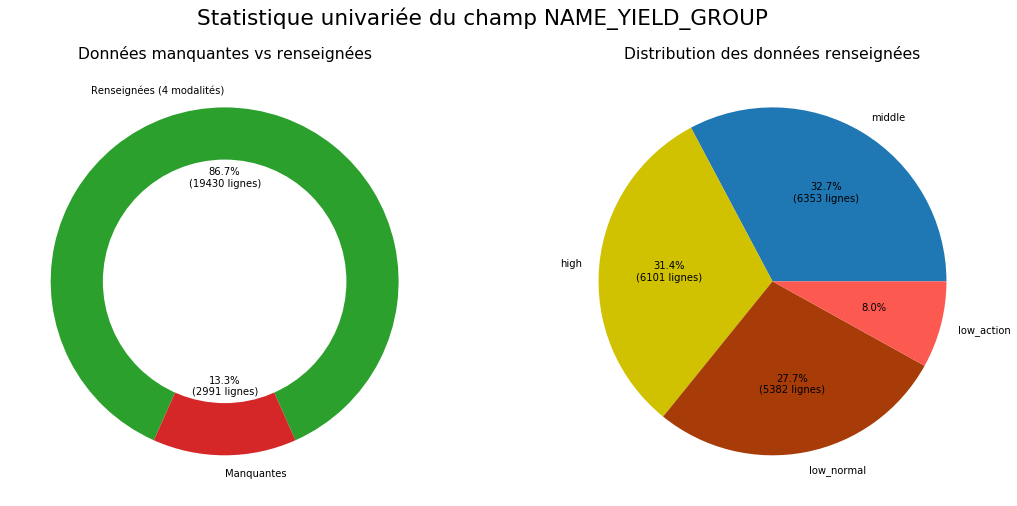

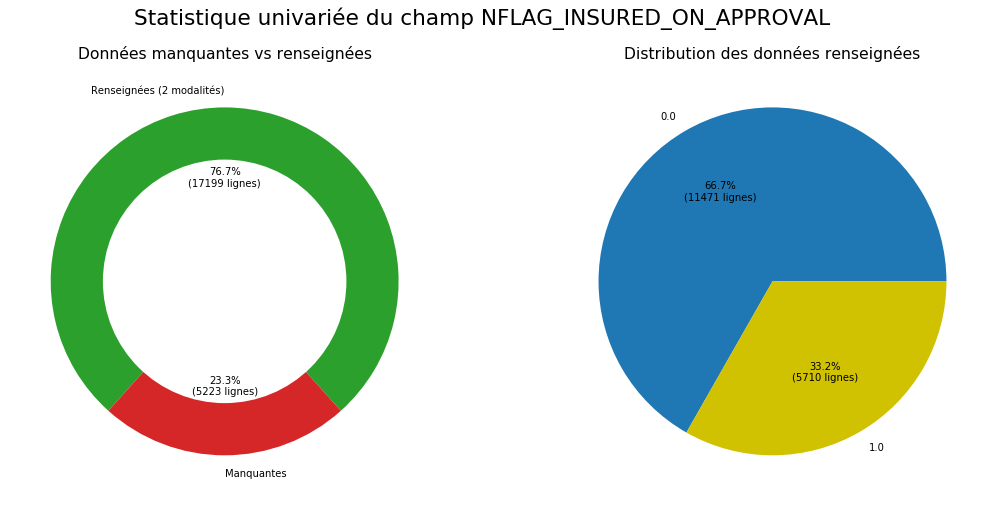

In [1405]:
myDf(dfPreviousApplication).Stat(typeStat='univ', statsNan=True, exclCol=['SK_ID_PREV','SK_ID_CURR'])

# Analyse des tables du troisième niveau

## Correspondances entre les tables

In [1406]:
low = 0
high = 999999999

Previous = dfPreviousApplication[(dfPreviousApplication.SK_ID_CURR>low) & (dfPreviousApplication.SK_ID_CURR<high)]
PosCashBal = dfPosCashBalance[(dfPosCashBalance.SK_ID_CURR>low) & (dfPreviousApplication.SK_ID_CURR<high)]
InstalPaymt = dfInstallmentsPayments[(dfInstallmentsPayments.SK_ID_CURR>low) & (dfPreviousApplication.SK_ID_CURR<high)]
CreditCardBal = dfCreditCardBalance[(dfCreditCardBalance.SK_ID_CURR>low) & (dfPreviousApplication.SK_ID_CURR<high)]

PreviousID = Previous[['SK_ID_PREV','SK_ID_CURR']].drop_duplicates()
PosCashBalID = PosCashBal[['SK_ID_PREV','SK_ID_CURR']].drop_duplicates()
CreditCardBalID = CreditCardBal[['SK_ID_PREV','SK_ID_CURR']].drop_duplicates()
InstalPaymtID = InstalPaymt[['SK_ID_PREV','SK_ID_CURR']].drop_duplicates()
CreditCardOrPosCashBalID = pd.concat([PosCashBalID,CreditCardBalID])

In [1407]:
nbPart = PreviousID.merge(CreditCardBalID).shape[0]
nbAll = PreviousID.shape[0]
printRatio(nbPart, nbAll, text1="previous avec une ligne dans credit card sur")

nbPart = PreviousID.merge(PosCashBalID).shape[0]
nbAll = PreviousID.shape[0]
printRatio(nbPart, nbAll, text1="previous avec une ligne dans pos cash sur")

nbPart = PreviousID.merge(InstalPaymtID).shape[0]
nbAll = PreviousID.shape[0]
printRatio(nbPart, nbAll, text1="previous avec une ligne dans installment payments sur")


nbPart = PosCashBalID.merge(CreditCardBalID).shape[0]
nbAll = PosCashBalID.shape[0]
printRatio(nbPart, nbAll, text1="pos cash avec une ligne dans credit card sur")

nbPart = PosCashBalID.merge(InstalPaymtID).shape[0]
nbAll = PosCashBalID.shape[0]
printRatio(nbPart, nbAll, text1="pos cash avec une ligne dans InstalPaymt sur")

nbPart = CreditCardBalID.merge(InstalPaymtID).shape[0]
nbAll = CreditCardBalID.shape[0]
printRatio(nbPart, nbAll, text1="credit card avec une ligne dans InstalPaymt sur")

nbPart = InstalPaymtID.merge(CreditCardOrPosCashBalID).shape[0]
nbAll = InstalPaymtID.shape[0]
printRatio(nbPart, nbAll, text1="instalPaymnt avec une ligne dans pos cash ou dans credit card sur")

556 previous avec une ligne dans credit card sur 22422  (2.48%)
2045 previous avec une ligne dans pos cash sur 22422  (9.121%)
1294 previous avec une ligne dans installment payments sur 22422  (5.771%)
0 pos cash avec une ligne dans credit card sur 2046  (0.0%)
199 pos cash avec une ligne dans InstalPaymt sur 2046  (9.726%)
82 credit card avec une ligne dans InstalPaymt sur 556  (14.748%)
281 instalPaymnt avec une ligne dans pos cash ou dans credit card sur 1294  (21.716%)


### PosCash sans installment payment

In [1408]:
PosSansInstalPaymt = myDf(PosCashBal).WhereNotExists(InstalPaymtID, left_on=['SK_ID_PREV','SK_ID_CURR'], right_on=['SK_ID_PREV','SK_ID_CURR'])
Previous.merge(PosSansInstalPaymt[['SK_ID_PREV','SK_ID_CURR']].drop_duplicates()).head()

SK_ID_PREV  SK_ID_CURR  AMT_CREDIT  RATE_DOWN_PAYMENT NAME_CONTRACT_STATUS  \
0     1540047      154602    266760.0                NaN             Approved   
1     1780535      195690    568197.0                NaN             Approved   
2     1189884      335217    261837.0                NaN             Approved   
3     1119934      382118    697500.0                NaN             Approved   
4     1231815      196567     62127.0           0.108909             Approved   

   DAYS_DECISION NAME_PRODUCT_TYPE  NAME_SELLER_INDUSTRY NAME_YIELD_GROUP  \
0           -629            x-sell                   NaN       low_normal   
1           -778            x-sell                   NaN       low_normal   
2           -572            x-sell                   NaN             high   
3           -728            x-sell                   NaN       low_normal   
4           -565               NaN  Consumer electronics           middle   

   NFLAG_INSURED_ON_APPROVAL  
0                        1.0  
1                        1.0  
2                        1.0  
3                        0.0  
4                        0.0

In [1409]:
PosCashBal[(PosCashBal.SK_ID_PREV ==1715348) & (PosCashBal.SK_ID_CURR == 367990)].sort_values('MONTHS_BALANCE')

Empty DataFrame
Columns: [SK_ID_PREV, SK_ID_CURR, MONTHS_BALANCE, CNT_INSTALMENT, CNT_INSTALMENT_FUTURE, NAME_CONTRACT_STATUS, SK_DPD, SK_DPD_DEF]
Index: []

### CreditCard sans installment payment

In [1410]:
CreditCardSansInstalPaymt = myDf(CreditCardBal).WhereNotExists(InstalPaymtID, left_on=['SK_ID_PREV','SK_ID_CURR'], right_on=['SK_ID_PREV','SK_ID_CURR'])
Previous.merge(CreditCardSansInstalPaymt[['SK_ID_PREV','SK_ID_CURR']].drop_duplicates()).head()

SK_ID_PREV  SK_ID_CURR  AMT_CREDIT  RATE_DOWN_PAYMENT NAME_CONTRACT_STATUS  \
0     2405261      215837     45000.0                NaN             Approved   
1     1102255      316951    450000.0                NaN             Approved   
2     2668196      153618     67500.0                NaN             Approved   
3     2726750      141292    112500.0                NaN             Approved   
4     1301834      421584    382500.0                NaN             Approved   

   DAYS_DECISION NAME_PRODUCT_TYPE  NAME_SELLER_INDUSTRY NAME_YIELD_GROUP  \
0           -424           walk-in          Connectivity              NaN   
1          -1030            x-sell                   NaN              NaN   
2          -1567            x-sell                   NaN              NaN   
3          -1658            x-sell  Consumer electronics              NaN   
4          -1622            x-sell  Consumer electronics              NaN   

   NFLAG_INSURED_ON_APPROVAL  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0

In [1411]:
CreditCardBal[(CreditCardBal.SK_ID_PREV ==1769895) & (CreditCardBal.SK_ID_CURR == 296299)].sort_values('MONTHS_BALANCE')

Empty DataFrame
Columns: [SK_ID_PREV, SK_ID_CURR, MONTHS_BALANCE, AMT_BALANCE, AMT_CREDIT_LIMIT_ACTUAL, AMT_DRAWINGS_ATM_CURRENT, AMT_DRAWINGS_CURRENT, AMT_DRAWINGS_OTHER_CURRENT, AMT_DRAWINGS_POS_CURRENT, AMT_INST_MIN_REGULARITY, AMT_PAYMENT_CURRENT, AMT_PAYMENT_TOTAL_CURRENT, AMT_RECEIVABLE_PRINCIPAL, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE, CNT_DRAWINGS_ATM_CURRENT, CNT_DRAWINGS_CURRENT, CNT_DRAWINGS_OTHER_CURRENT, CNT_DRAWINGS_POS_CURRENT, CNT_INSTALMENT_MATURE_CUM, NAME_CONTRACT_STATUS, SK_DPD, SK_DPD_DEF]
Index: []

### Installment payments sans credit card ni pos cash

In [1412]:
InstalPaymtSansCreditCardNiPosCash = myDf(InstalPaymtID).WhereNotExists(CreditCardBal, left_on=['SK_ID_PREV','SK_ID_CURR'], right_on=['SK_ID_PREV','SK_ID_CURR'])
InstalPaymtSansCreditCardNiPosCash = myDf(InstalPaymtSansCreditCardNiPosCash).WhereNotExists(PosCashBal, left_on=['SK_ID_PREV','SK_ID_CURR'], right_on=['SK_ID_PREV','SK_ID_CURR'])
Previous.merge(InstalPaymtSansCreditCardNiPosCash[['SK_ID_PREV','SK_ID_CURR']].drop_duplicates()).head()

SK_ID_PREV  SK_ID_CURR  AMT_CREDIT  RATE_DOWN_PAYMENT NAME_CONTRACT_STATUS  \
0     2746219      154602     69048.0           0.101384             Approved   
1     2031954      195690    900000.0                NaN             Approved   
2     1128385      195690    442422.0                NaN             Approved   
3     2775813      195690     49266.0           0.000000             Approved   
4     1318512      186283     15192.0           0.204401             Approved   

   DAYS_DECISION NAME_PRODUCT_TYPE  NAME_SELLER_INDUSTRY NAME_YIELD_GROUP  \
0          -1551               NaN  Consumer electronics           middle   
1           -850            x-sell                   NaN              NaN   
2          -1205            x-sell                   NaN       low_normal   
3          -2452               NaN          Connectivity             high   
4          -2081               NaN  Consumer electronics             high   

   NFLAG_INSURED_ON_APPROVAL  
0                        0.0  
1                        0.0  
2                        1.0  
3                        0.0  
4                        0.0

In [1413]:
InstalPaymt[(InstalPaymt.SK_ID_PREV ==2746219) & (InstalPaymt.SK_ID_CURR == 154602)].sort_values('DAYS_INSTALMENT')

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
5979     2746219      154602                     1.0                      1   
5974     2746219      154602                     1.0                      4   
5981     2746219      154602                     1.0                      5   
5976     2746219      154602                     1.0                      6   
5983     2746219      154602                     1.0                      7   
5982     2746219      154602                     1.0                      9   
5980     2746219      154602                     1.0                     10   

      DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
5979          -1517.0             -1522.0        8520.525     8520.525  
5974          -1427.0             -1441.0        8520.525     8520.525  
5981          -1397.0             -1412.0        8520.525     8520.525  
5976          -1367.0             -1380.0        8520.525     8520.525  
5983          -1337.0             -1352.0        8520.525     8520.525  
5982          -1277.0             -1292.0        8520.525     8520.525  
5980          -1247.0             -1259.0        8538.885     8538.885

### NAME_CONTRACT_STATUS

dfPosCashBalance et dfCreditCardBalance contiennent le dernier status de PreviousApplication, on le remonte dans PreviousApplication

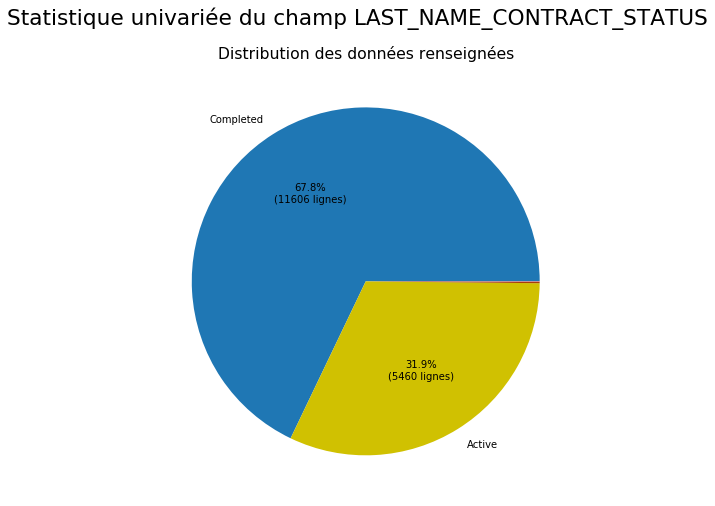

In [1414]:
dfPreviousApplicationStatus = pd.concat([dfPosCashBalance[['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE','NAME_CONTRACT_STATUS']],dfCreditCardBalance[['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE','NAME_CONTRACT_STATUS']]])
tmp = dfPreviousApplicationStatus.groupby(['SK_ID_CURR','SK_ID_PREV']).agg({'MONTHS_BALANCE':'max'}).reset_index(drop=False)
dfPreviousApplicationStatus = dfPreviousApplicationStatus.merge(tmp, left_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'], right_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'])
del dfPreviousApplicationStatus['MONTHS_BALANCE']
dfPreviousApplicationStatus = dfPreviousApplicationStatus.rename(columns={'NAME_CONTRACT_STATUS': 'LAST_NAME_CONTRACT_STATUS'})
myDf(dfPreviousApplicationStatus).Stat('LAST_NAME_CONTRACT_STATUS')
del dfPosCashBalance['NAME_CONTRACT_STATUS']
del dfCreditCardBalance['NAME_CONTRACT_STATUS']

In [1415]:
dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationStatus, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'], how='left')

LasContractStatus n'est jamais renseigné pour les refused

In [1416]:
tmp = dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS == 'Refused']
tmp.LAST_NAME_CONTRACT_STATUS.unique()

array([nan], dtype=object)

LastContractStatus non renseigné pour 724 PreviousApplication

In [1417]:
dfPreviousApplication[(dfPreviousApplication.NAME_CONTRACT_STATUS == 'Approved') & (dfPreviousApplication.LAST_NAME_CONTRACT_STATUS.isnull())].shape

(724, 11)

Distribution lorque le lastContracttatus est renseigné

In [1418]:
tmp = dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS == 'Approved']
tmp.LAST_NAME_CONTRACT_STATUS.value_counts()

Completed                11609
Active                    5465
Signed                      19
Returned to the store        7
Approved                     2
Demand                       1
Name: LAST_NAME_CONTRACT_STATUS, dtype: int64

In [1419]:
dfPreviousApplication[['NAME_CONTRACT_STATUS','LAST_NAME_CONTRACT_STATUS']].groupby(['NAME_CONTRACT_STATUS','LAST_NAME_CONTRACT_STATUS']).size()

NAME_CONTRACT_STATUS  LAST_NAME_CONTRACT_STATUS
Approved              Active                        5465
                      Approved                         2
                      Completed                    11609
                      Demand                           1
                      Returned to the store            7
                      Signed                          19
dtype: int64

In [1420]:
dfPreviousApplication

SK_ID_PREV  SK_ID_CURR  AMT_CREDIT  RATE_DOWN_PAYMENT  \
0         2163253      154602     27297.0           0.051324   
1         2288561      154602     15052.5           0.000000   
2         2421265      154602     48073.5           0.108909   
3         2746219      154602     69048.0           0.101384   
4         1540047      154602    266760.0                NaN   
...           ...         ...         ...                ...   
22417     1928505      421923     69673.5           0.000000   
22418     1131525      280984     80910.0           0.000000   
22419     1819967      163199     16663.5           0.217978   
22420     2390418      167231     32868.0           0.000000   
22421     1609541      194510     42286.5           0.099037   

      NAME_CONTRACT_STATUS  DAYS_DECISION NAME_PRODUCT_TYPE  \
0                 Approved          -1473               NaN   
1                 Approved          -1529               NaN   
2                 Approved          -2680               NaN   
3                 Approved          -1551               NaN   
4                 Approved           -629            x-sell   
...                    ...            ...               ...   
22417             Approved           -131               NaN   
22418             Approved           -293               NaN   
22419             Approved           -591               NaN   
22420             Approved          -1504               NaN   
22421             Approved           -641               NaN   

       NAME_SELLER_INDUSTRY NAME_YIELD_GROUP  NFLAG_INSURED_ON_APPROVAL  \
0      Consumer electronics             high                        0.0   
1      Consumer electronics       low_normal                        0.0   
2                 Furniture       low_normal                        0.0   
3      Consumer electronics           middle                        0.0   
4                       NaN       low_normal                        1.0   
...                     ...              ...                        ...   
22417          Construction       low_normal                        1.0   
22418  Consumer electronics           middle                        0.0   
22419          Construction           middle                        0.0   
22420  Consumer electronics       low_action                        0.0   
22421          Connectivity             high                        0.0   

      LAST_NAME_CONTRACT_STATUS  
0                     Completed  
1                     Completed  
2                     Completed  
3                     Completed  
4                        Active  
...                         ...  
22417                    Active  
22418                    Active  
22419                 Completed  
22420                 Completed  
22421                 Completed  

[22422 rows x 11 columns]

# Exploration de installment payments

## Suppression de variables inintéressantes

In [1421]:
del dfInstallmentsPayments['NUM_INSTALMENT_VERSION'] #Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
del dfInstallmentsPayments['NUM_INSTALMENT_NUMBER'] #On which installment we observe payment

## Statistique univariée

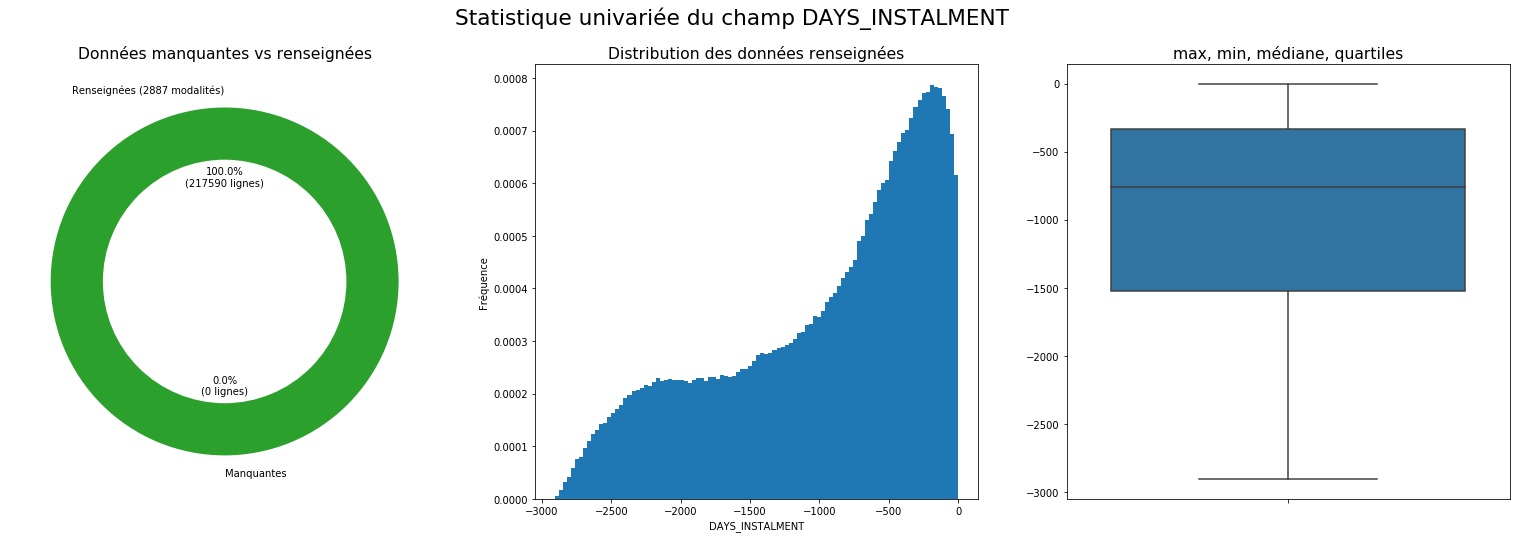

Mesures de position
 - Moyenne: -972.5
 - Médiane: -760.0
Mesures de dispertion
 - Ecart type: 753.13
 - Min: -2906.0
 - Q25: -1521.0
 - Q75: -337.0
 - Max: -2.0
Mesures de forme
 - Skewness (asymétrie): -0.67
 - Kurtosis (applatissement): -0.7


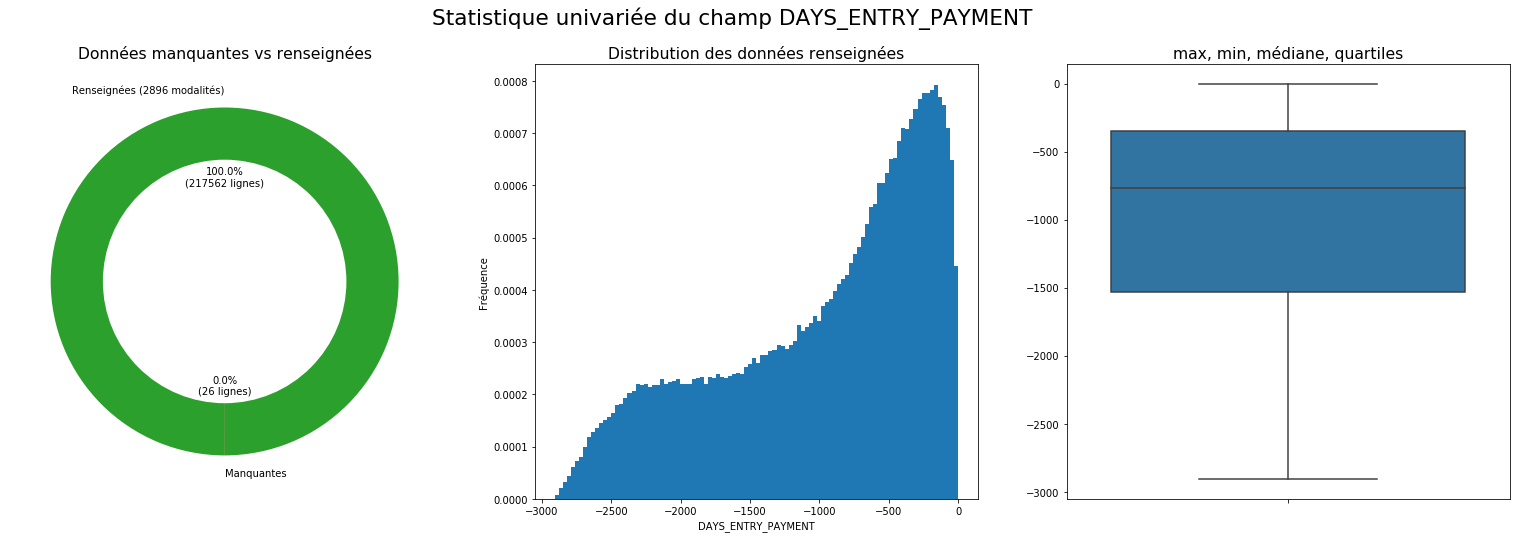

Mesures de position
 - Moyenne: -981.7
 - Médiane: -769.0
Mesures de dispertion
 - Ecart type: 753.1
 - Min: -2907.0
 - Q25: -1531.0
 - Q75: -347.0
 - Max: -2.0
Mesures de forme
 - Skewness (asymétrie): -0.67
 - Kurtosis (applatissement): -0.71


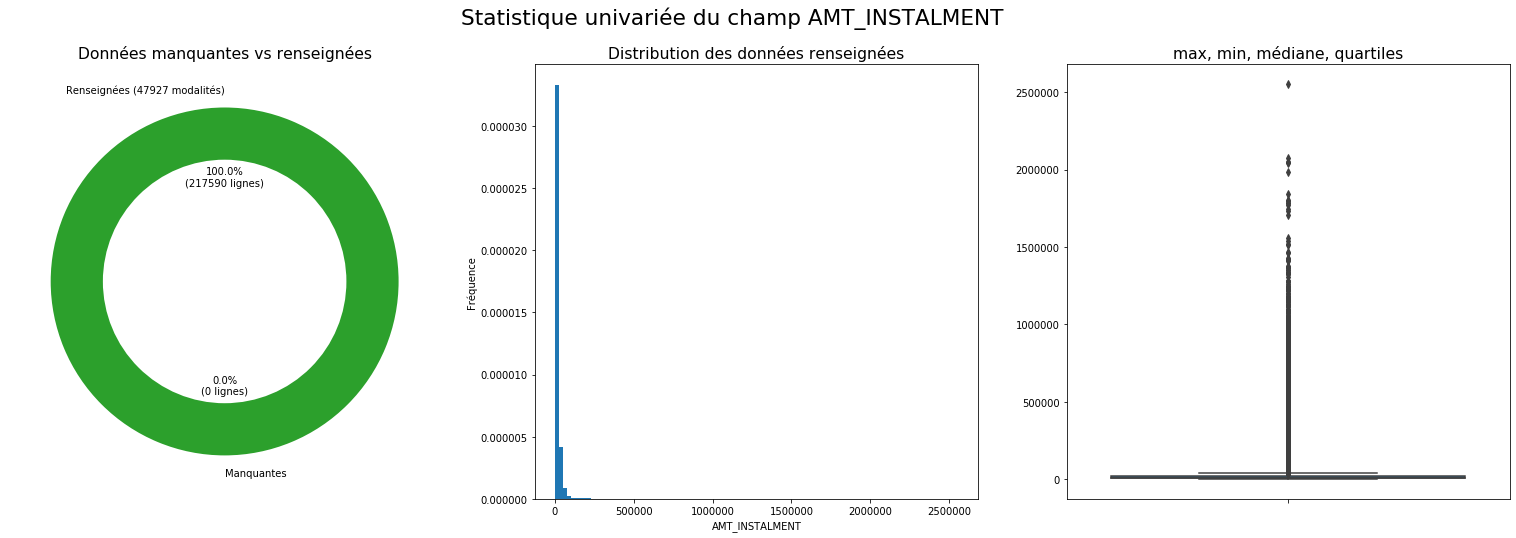

Mesures de position
 - Moyenne: 17767.51
 - Médiane: 9145.17
Mesures de dispertion
 - Ecart type: 51037.78
 - Min: 0.04
 - Q25: 4519.08
 - Q75: 17628.03
 - Max: 2554855.24
Mesures de forme
 - Skewness (asymétrie): 15.7
 - Kurtosis (applatissement): 356.47


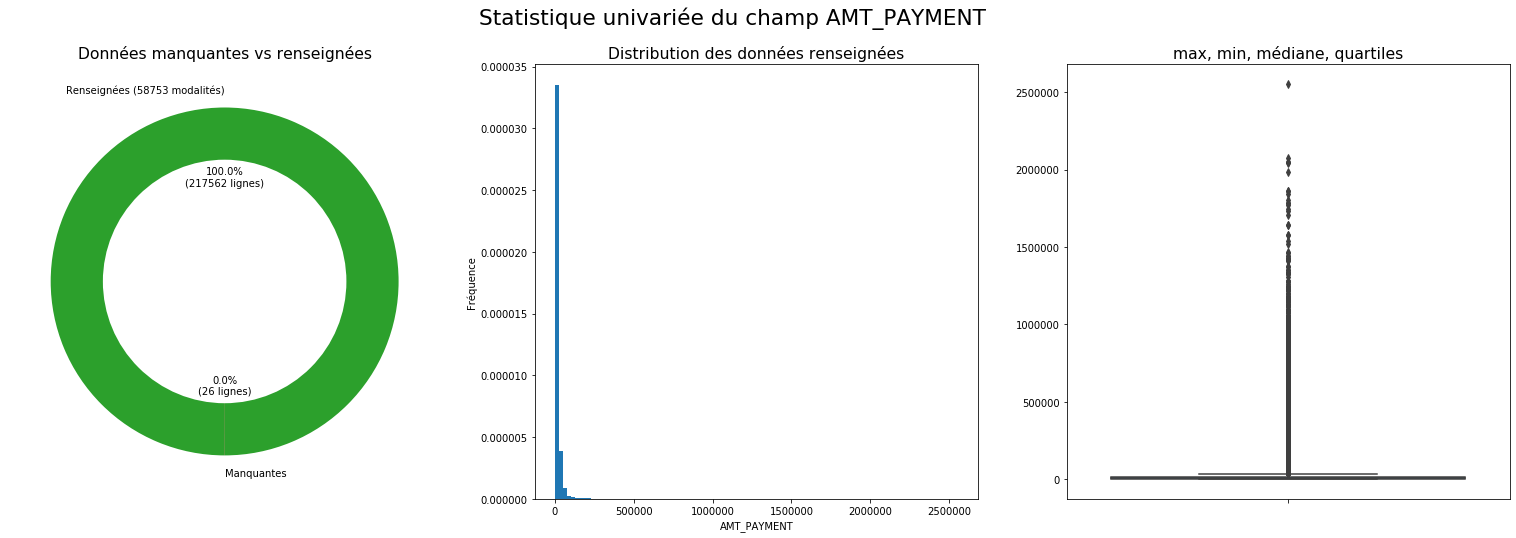

Mesures de position
 - Moyenne: 17867.78
 - Médiane: 8770.09
Mesures de dispertion
 - Ecart type: 54937.63
 - Min: 0.0
 - Q25: 3955.05
 - Q75: 16918.52
 - Max: 2554855.24
Mesures de forme
 - Skewness (asymétrie): 14.54
 - Kurtosis (applatissement): 301.69


In [1422]:
myDf(dfInstallmentsPayments).Stat(exclCol=['SK_ID_CURR','SK_ID_PREV'], typeStat='univ', statsNan=True)

# Exploration de PosCashBalance

## Variables inintéressantes

In [1423]:
del dfPosCashBalance['CNT_INSTALMENT'] # Term of previous credit (can change over time)
del dfPosCashBalance['CNT_INSTALMENT_FUTURE'] # Installments left to pay on the previous credit

## Recherche de corrélations

### Entre SK_DPD et SK_DPD_DEF

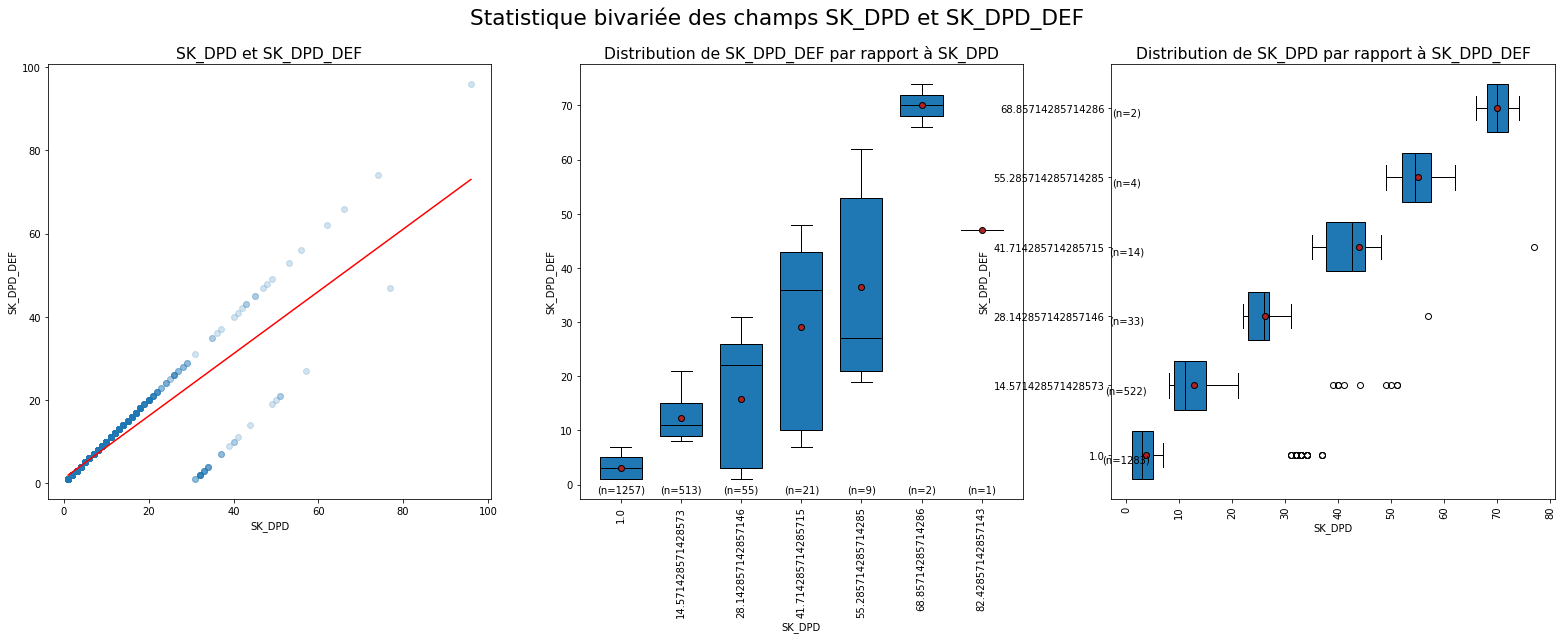

Covariance entre SK_DPD et SK_DPD_DEF : 54.333014360158785 
Covariance débiaisée entre SK_DPD et SK_DPD_DEF : 54.362257102010325 
Coefficient de correlation linéaire entre SK_DPD et SK_DPD_DEF : 0.8708763414458376 
Régression linéaire entre SK_DPD et SK_DPD_DEF: y = 0.7480585076276667x + 1.2078304440100749
Coefficient de détermination entre SK_DPD et SK_DPD_DEF : 0.7584256020900871 


In [1424]:
myDf(dfPosCashBalance[dfPosCashBalance.SK_DPD_DEF != 0]).Stat(['SK_DPD','SK_DPD_DEF'], typeStat='biv')

In [1425]:
print('Nombre de lignes avec le champ vide:')
(dfPosCashBalance[['SK_DPD','SK_DPD_DEF']].isnull()).sum()

Nombre de lignes avec le champ vide:


SK_DPD        0
SK_DPD_DEF    0
dtype: int64

In [1426]:
print('Nombre de lignes avec SK_DPD=0 et SK_DPD_DEF != 0:')
dfPosCashBalance[(dfPosCashBalance.SK_DPD == 0) & (dfPosCashBalance.SK_DPD_DEF != 0)].shape[0]

Nombre de lignes avec SK_DPD=0 et SK_DPD_DEF != 0:


0

In [1427]:
print('Nombre de lignes avec SK_DPD!=0 et SK_DPD_DEF=0:')
dfPosCashBalance[(dfPosCashBalance.SK_DPD != 0) & (dfPosCashBalance.SK_DPD_DEF == 0)].shape[0]

Nombre de lignes avec SK_DPD!=0 et SK_DPD_DEF=0:


2119

In [1428]:
print('Nombre de lignes avec SK_DPD!=0 et SK_DPD_DEF!=0:')
dfPosCashBalance[dfPosCashBalance.SK_DPD != 0].shape[0]

Nombre de lignes avec SK_DPD!=0 et SK_DPD_DEF!=0:


3978

On prend la moyenne des deux

In [1429]:
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: (x.SK_DPD + x.SK_DPD_DEF) / 2, axis=1)

In [1430]:
del dfPosCashBalance['SK_DPD_DEF']

## Statistique univariée

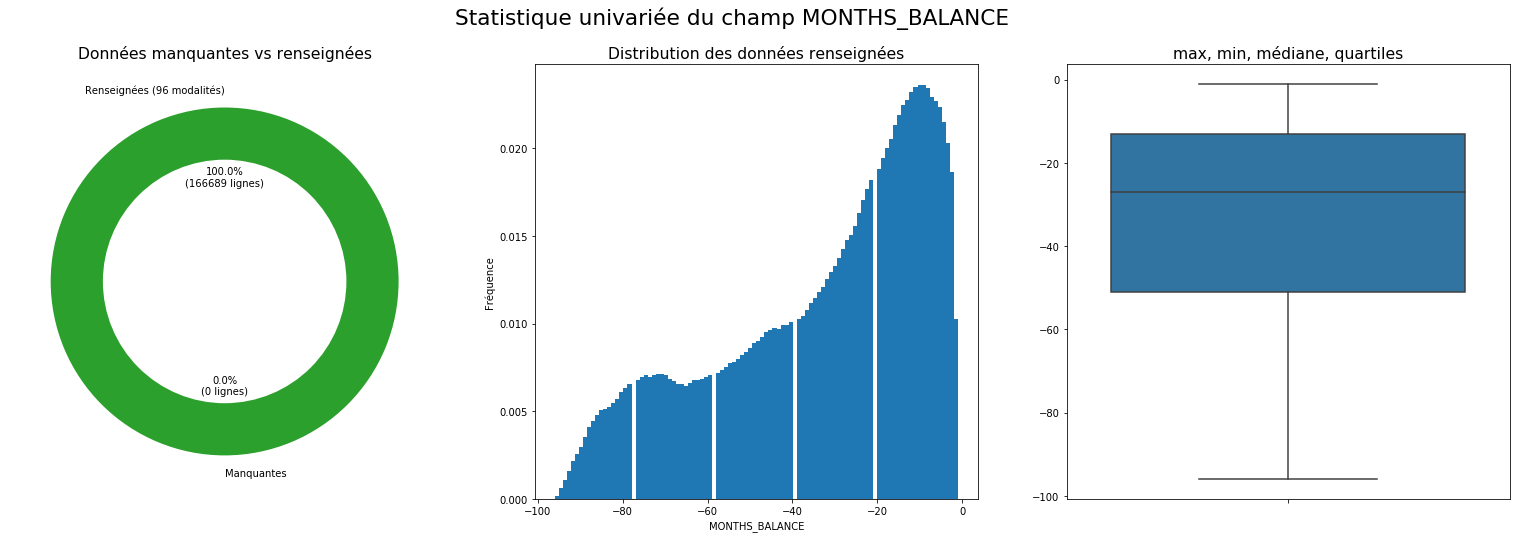

Mesures de position
 - Moyenne: -33.4
 - Médiane: -27.0
Mesures de dispertion
 - Ecart type: 24.63
 - Min: -96
 - Q25: -51.0
 - Q75: -13.0
 - Max: -1
Mesures de forme
 - Skewness (asymétrie): -0.67
 - Kurtosis (applatissement): -0.67


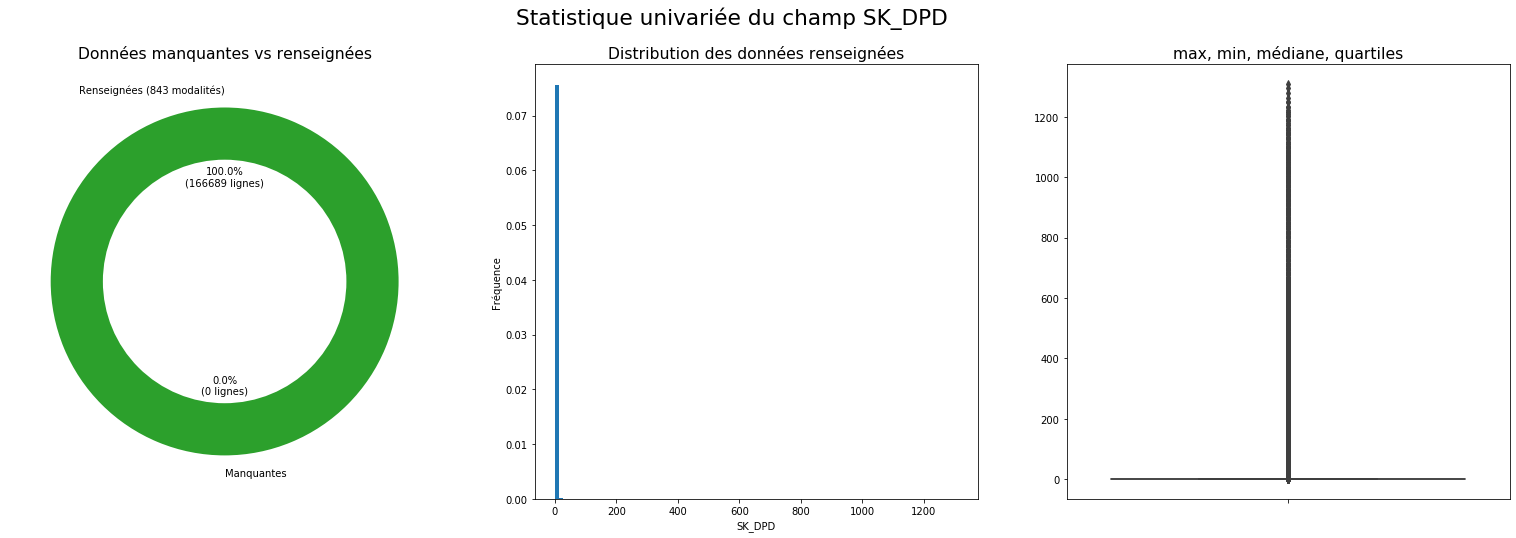

Mesures de position
 - Moyenne: 2.6
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 39.49
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 1310.0
Mesures de forme
 - Skewness (asymétrie): 20.57
 - Kurtosis (applatissement): 479.42


In [1431]:
myDf(dfPosCashBalance).Stat(exclCol=['SK_ID_CURR','SK_ID_PREV'], typeStat='univ', statsNan=True)

### SK_DPD restreint aux valeurs strictement positives

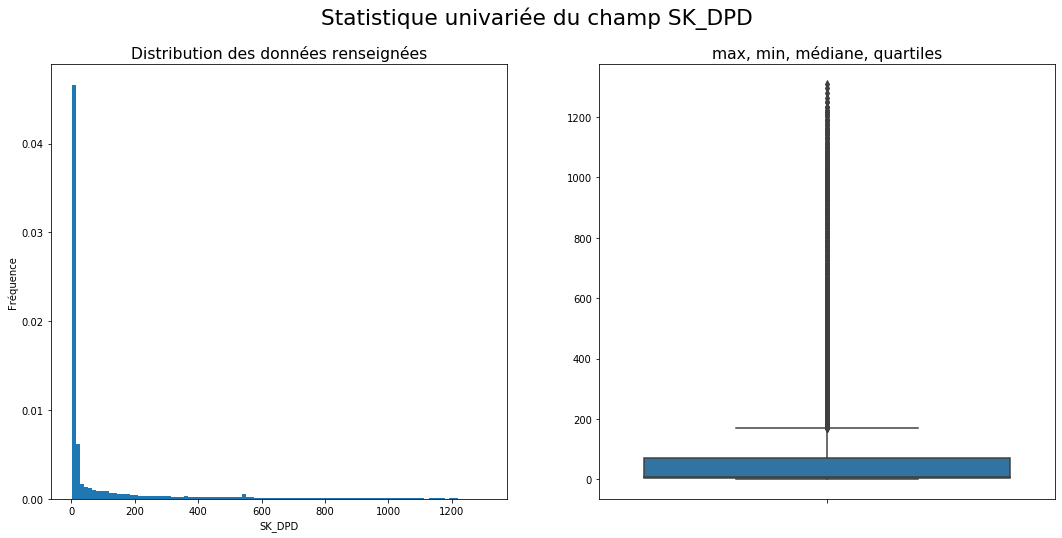

Mesures de position
 - Moyenne: 108.88
 - Médiane: 8.5
Mesures de dispertion
 - Ecart type: 231.87
 - Min: 0.5
 - Q25: 3.0
 - Q75: 69.5
 - Max: 1310.0
Mesures de forme
 - Skewness (asymétrie): 2.79
 - Kurtosis (applatissement): 7.59


In [1432]:
myDf(dfPosCashBalance[dfPosCashBalance.SK_DPD > 0]).Stat('SK_DPD')

# Exploration de CreditCardBalance

In [1433]:
dfCreditCardBalance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     1356439      375115              -3     2337.210   
1     1356439      375115              -1   112450.320   
2     1356439      375115              -8     4438.125   
3     1356439      375115              -7     4471.830   
4     1356439      375115              -2    71368.380   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0               1300.50   
1                   135000                   33750.0              34425.00   
2                   135000                       0.0                450.00   
3                   135000                       0.0               2168.46   
4                    81000                   45000.0              70275.06   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                   1300.50   
1                         0.0                    675.00   
2                         0.0                    450.00   
3                         0.0                   2168.46   
4                         0.0                  25275.06   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 2250.000               50.850                     50.850   
1                 2250.000              132.930                    132.930   
2                 2250.000             2340.045                   2340.045   
3                 2250.000             2250.000                   2250.000   
4                 1113.615             3382.425                   1132.425   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                  2240.820       2329.290              2329.290   
1                104020.065     107432.460            107432.460   
2                  3788.235       3963.465              3963.465   
3                  4324.230       4455.225              4455.225   
4                 69727.995      70022.880             70022.880   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     2                         0.0   
1                       3.0                     4                         0.0   
2                       0.0                     1                         0.0   
3                       0.0                     2                         0.0   
4                       1.0                     9                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  SK_DPD  SK_DPD_DEF  
0                       2.0                       10.0       0           0  
1                       1.0                       12.0       0           0  
2                       1.0                        5.0       0           0  
3                       2.0                        6.0       0           0  
4                       8.0                       11.0       0           0

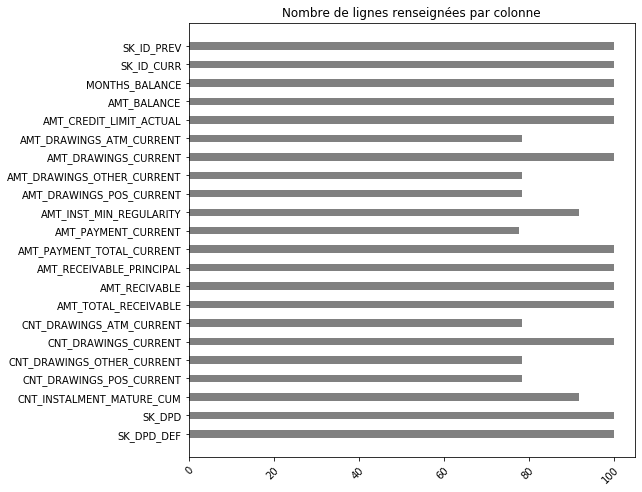

In [1434]:
myDf(dfCreditCardBalance).ColCountLinesChart(typeChart='barh', displayColName=True)

## Recherche de corrélations

### Corrélations entre les montants

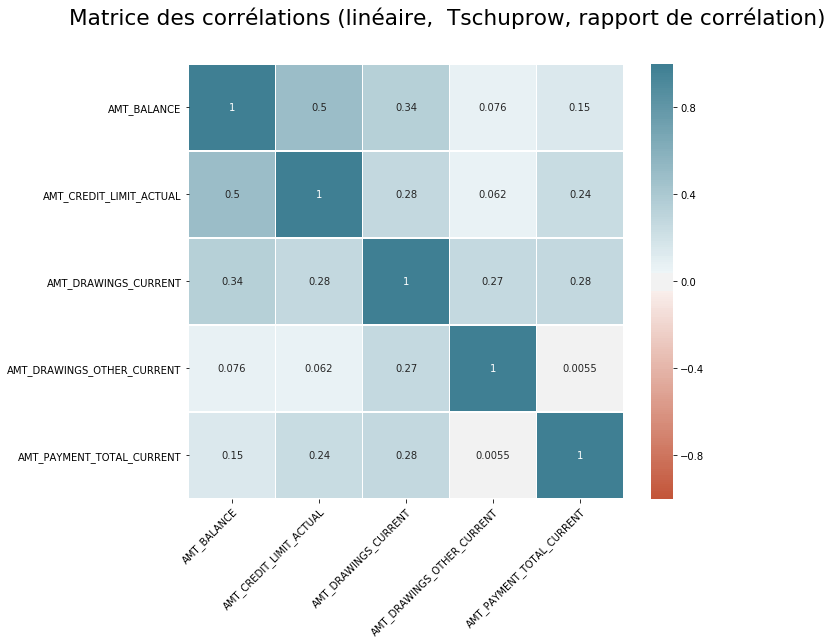

In [1435]:
cols = [
'AMT_BALANCE',
'AMT_CREDIT_LIMIT_ACTUAL',
'AMT_DRAWINGS_ATM_CURRENT',
'AMT_DRAWINGS_CURRENT',
'AMT_DRAWINGS_OTHER_CURRENT',
'AMT_DRAWINGS_POS_CURRENT',
'AMT_INST_MIN_REGULARITY',
'AMT_PAYMENT_CURRENT',
'AMT_PAYMENT_TOTAL_CURRENT',
'AMT_RECEIVABLE_PRINCIPAL',
'AMT_RECIVABLE',
'AMT_TOTAL_RECEIVABLE']


cols = [
'AMT_BALANCE',
'AMT_CREDIT_LIMIT_ACTUAL',
'AMT_DRAWINGS_CURRENT',
'AMT_DRAWINGS_OTHER_CURRENT',
'AMT_PAYMENT_TOTAL_CURRENT']


myDf(dfCreditCardBalance).Stat(cols, typeStat='biv', bivOnlyCorrTable=True)

In [1436]:
del dfCreditCardBalance['AMT_INST_MIN_REGULARITY']
del dfCreditCardBalance['AMT_RECEIVABLE_PRINCIPAL']
del dfCreditCardBalance['AMT_RECIVABLE']
del dfCreditCardBalance['AMT_TOTAL_RECEIVABLE']
del dfCreditCardBalance['AMT_DRAWINGS_POS_CURRENT']
del dfCreditCardBalance['AMT_DRAWINGS_ATM_CURRENT']
del dfCreditCardBalance['AMT_PAYMENT_CURRENT']
del dfCreditCardBalance['AMT_CREDIT_LIMIT_ACTUAL']

### Corrélations entre les counts

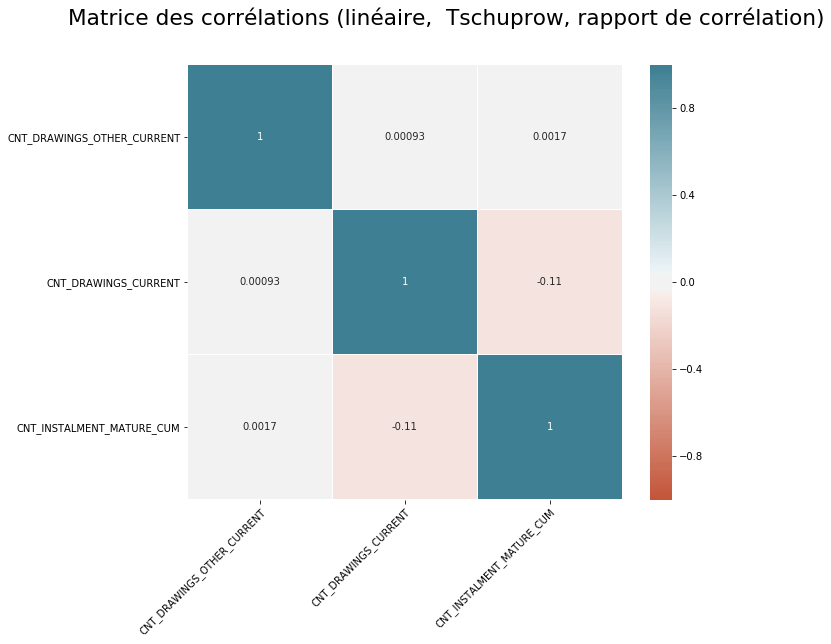

In [1437]:
cols = ['CNT_DRAWINGS_ATM_CURRENT',
'CNT_DRAWINGS_CURRENT',
'CNT_DRAWINGS_OTHER_CURRENT',
'CNT_DRAWINGS_POS_CURRENT',
'CNT_INSTALMENT_MATURE_CUM']

cols = [
'CNT_DRAWINGS_CURRENT',
'CNT_DRAWINGS_OTHER_CURRENT',
'CNT_INSTALMENT_MATURE_CUM']


myDf(dfCreditCardBalance).Stat(cols, typeStat='biv', bivOnlyCorrTable=True)

### Corrélations entre les montants et les counts

In [1438]:
del dfCreditCardBalance['CNT_DRAWINGS_ATM_CURRENT']
del dfCreditCardBalance['CNT_DRAWINGS_POS_CURRENT']

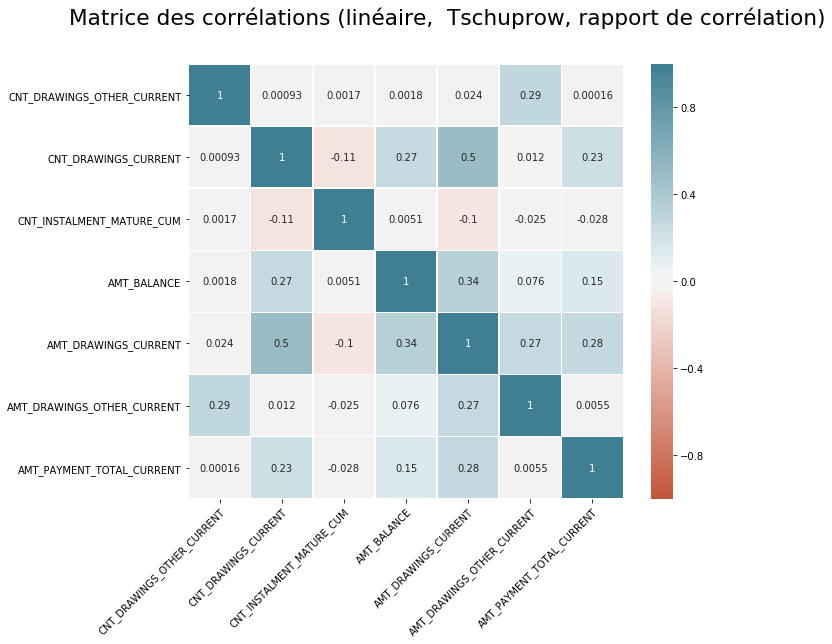

In [1439]:
cols = [
'CNT_DRAWINGS_CURRENT',
'CNT_DRAWINGS_OTHER_CURRENT',
'CNT_INSTALMENT_MATURE_CUM',
'AMT_BALANCE',
'AMT_DRAWINGS_CURRENT',
'AMT_DRAWINGS_OTHER_CURRENT',
'AMT_PAYMENT_TOTAL_CURRENT']

myDf(dfCreditCardBalance).Stat(cols, typeStat='biv', bivOnlyCorrTable=True)

In [1440]:
del dfCreditCardBalance['AMT_DRAWINGS_OTHER_CURRENT']
del dfCreditCardBalance['AMT_DRAWINGS_CURRENT']

## Statistique univariée

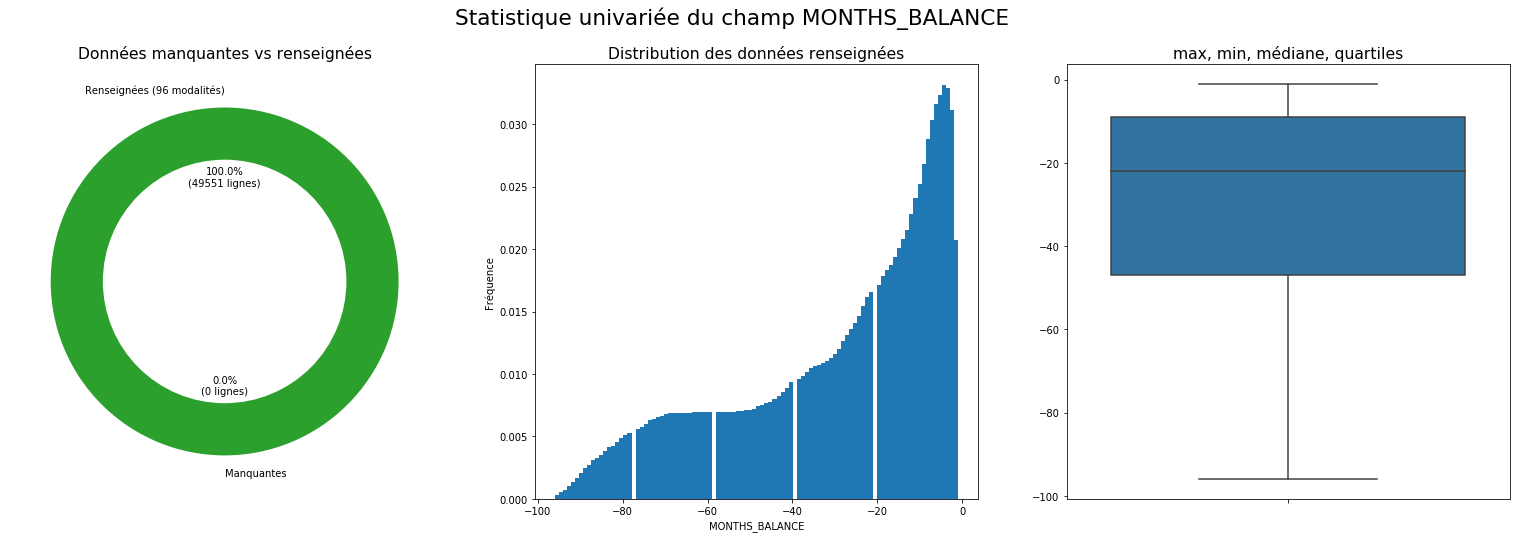

Mesures de position
 - Moyenne: -29.99
 - Médiane: -22.0
Mesures de dispertion
 - Ecart type: 24.44
 - Min: -96
 - Q25: -47.0
 - Q75: -9.0
 - Max: -1
Mesures de forme
 - Skewness (asymétrie): -0.78
 - Kurtosis (applatissement): -0.54


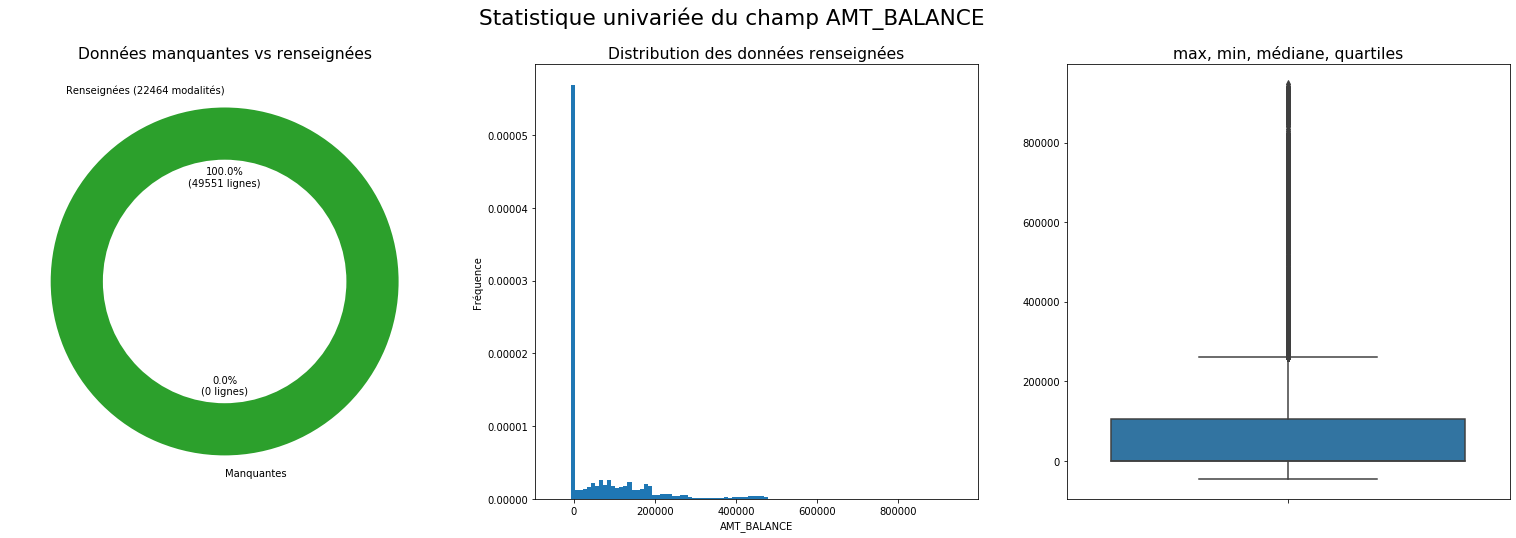

Mesures de position
 - Moyenne: 69145.84
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 121065.25
 - Min: -46203.44
 - Q25: 0.0
 - Q75: 104131.8
 - Max: 947634.98
Mesures de forme
 - Skewness (asymétrie): 2.77
 - Kurtosis (applatissement): 10.3


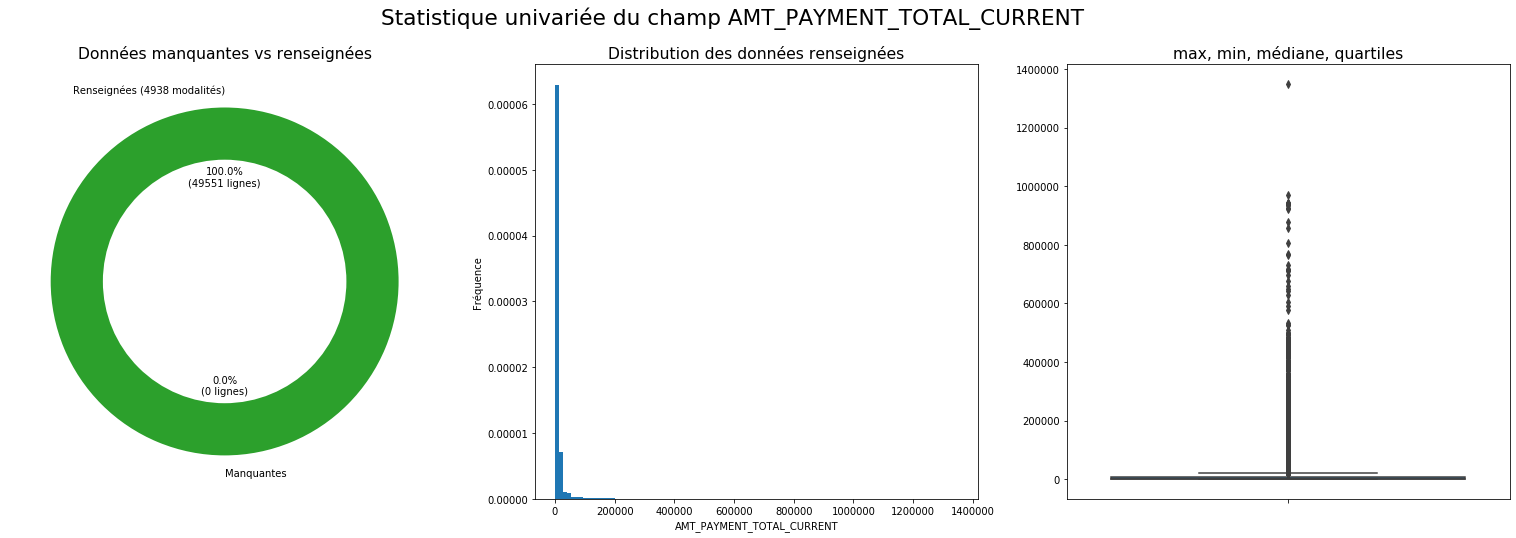

Mesures de position
 - Moyenne: 9154.35
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 36422.68
 - Min: 0.0
 - Q25: 0.0
 - Q75: 8603.86
 - Max: 1350000.0
Mesures de forme
 - Skewness (asymétrie): 12.17
 - Kurtosis (applatissement): 218.97


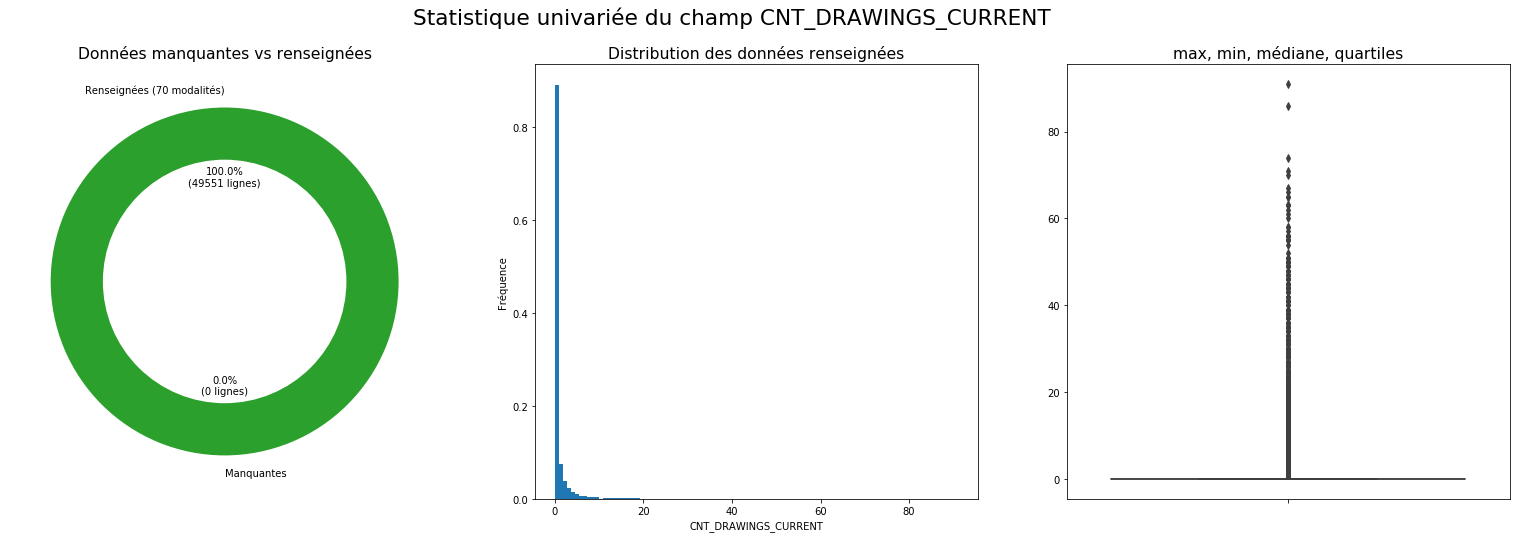

Mesures de position
 - Moyenne: 0.89
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3.58
 - Min: 0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 91
Mesures de forme
 - Skewness (asymétrie): 8.55
 - Kurtosis (applatissement): 103.98


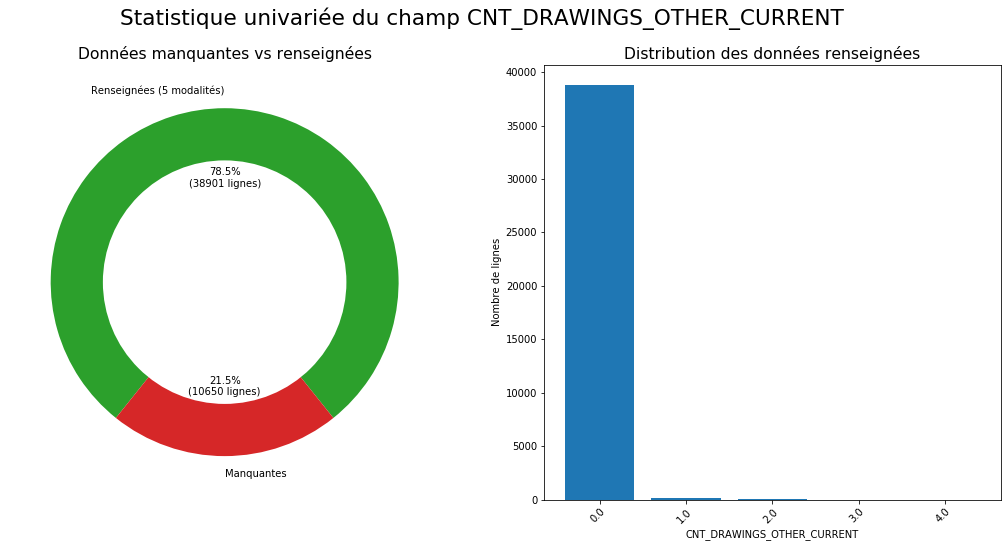

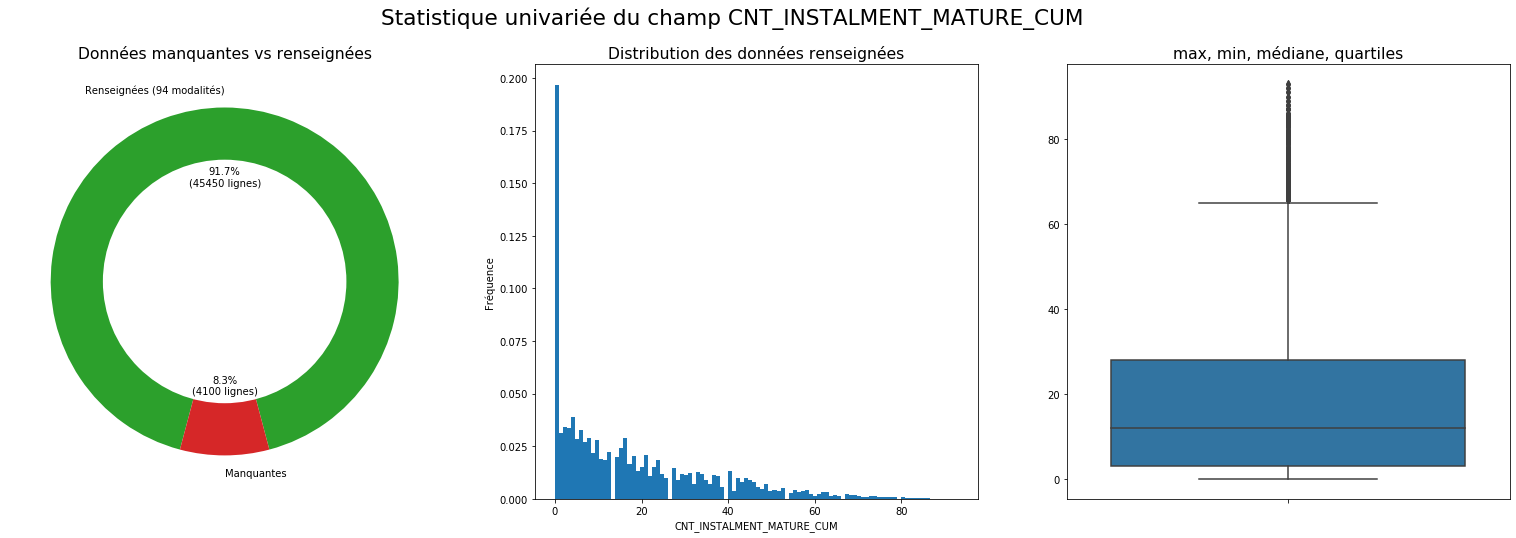

Mesures de position
 - Moyenne: 17.73
 - Médiane: 12.0
Mesures de dispertion
 - Ecart type: 18.09
 - Min: 0.0
 - Q25: 3.0
 - Q75: 28.0
 - Max: 93.0
Mesures de forme
 - Skewness (asymétrie): 1.15
 - Kurtosis (applatissement): 0.77


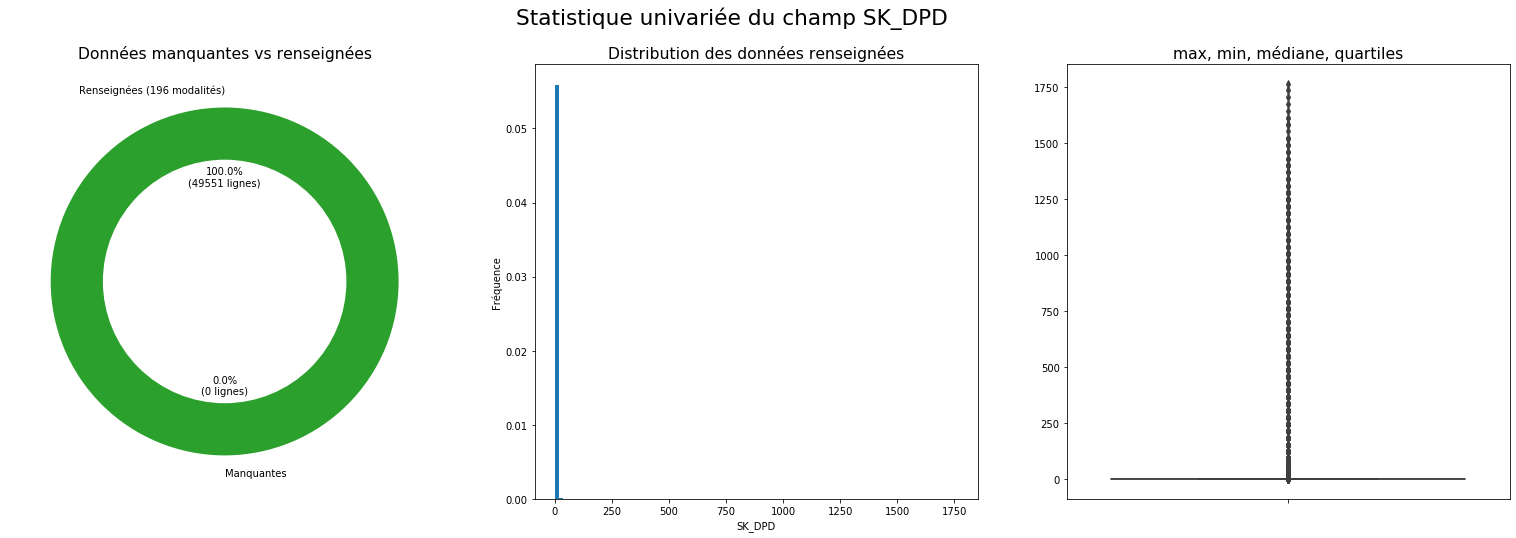

Mesures de position
 - Moyenne: 6.51
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 75.46
 - Min: 0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 1766
Mesures de forme
 - Skewness (asymétrie): 14.15
 - Kurtosis (applatissement): 221.59


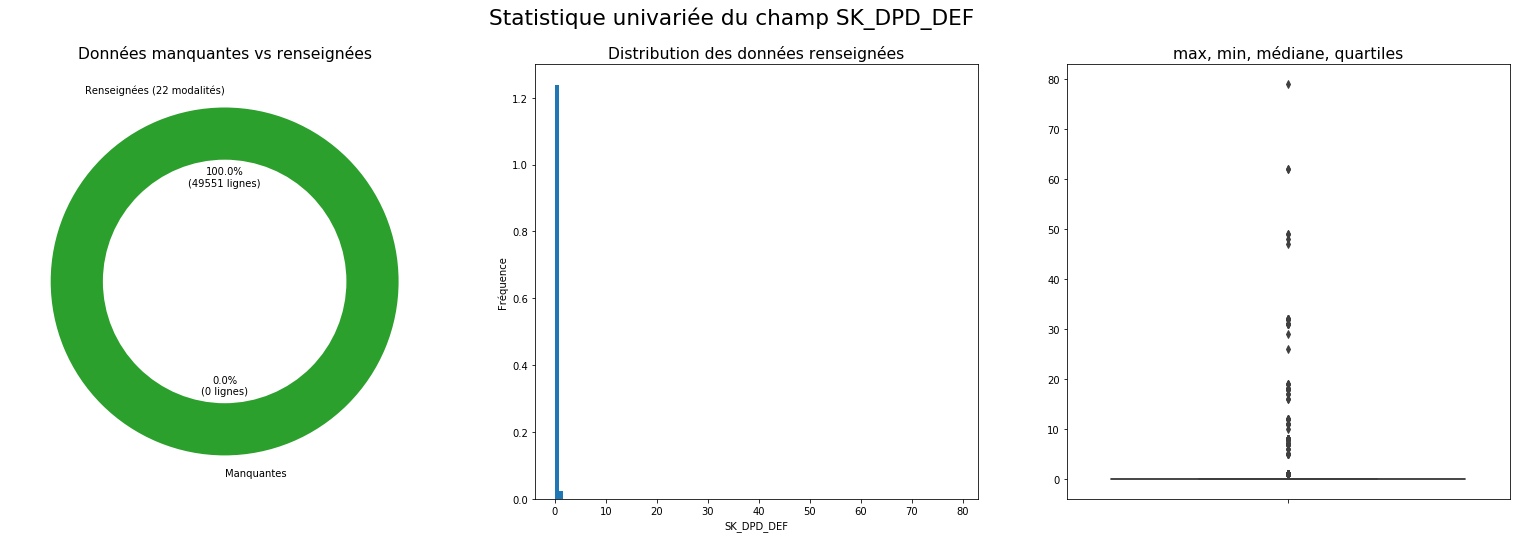

Mesures de position
 - Moyenne: 0.05
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 1.0
 - Min: 0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 79
Mesures de forme
 - Skewness (asymétrie): 41.12
 - Kurtosis (applatissement): 2158.2


In [1441]:
myDf(dfCreditCardBalance).Stat(exclCol=['SK_ID_CURR','SK_ID_PREV'], typeStat='univ', statsNan=True)

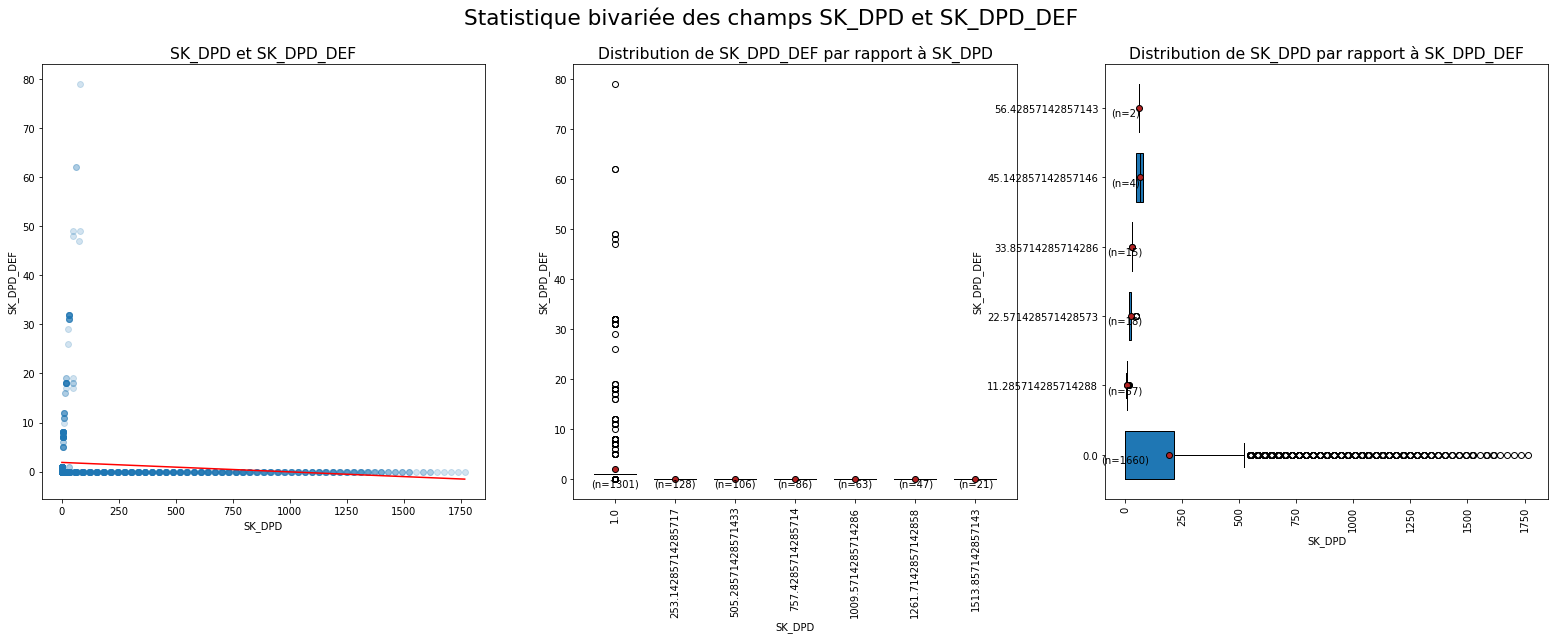

Covariance entre SK_DPD et SK_DPD_DEF : -246.81109499719628 
Covariance débiaisée entre SK_DPD et SK_DPD_DEF : -246.95164801257053 
Coefficient de correlation linéaire entre SK_DPD et SK_DPD_DEF : -0.13526095566736296 
Régression linéaire entre SK_DPD et SK_DPD_DEF: y = -0.001927102848278176x + 1.8683138832509598
Coefficient de détermination entre SK_DPD et SK_DPD_DEF : 0.01829552612804833 


In [1442]:
myDf(dfCreditCardBalance[dfCreditCardBalance.SK_DPD + dfCreditCardBalance.SK_DPD_DEF > 0]).Stat(['SK_DPD','SK_DPD_DEF'], typeStat='biv')

In [1443]:
dfCreditCardBalance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_PAYMENT_TOTAL_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [1444]:
del dfCreditCardBalance['AMT_BALANCE']
del dfCreditCardBalance['AMT_PAYMENT_TOTAL_CURRENT']
del dfCreditCardBalance['CNT_DRAWINGS_CURRENT']
del dfCreditCardBalance['CNT_DRAWINGS_OTHER_CURRENT']
del dfCreditCardBalance['CNT_INSTALMENT_MATURE_CUM']

# Exploration de dfBureau

## Statistiques sur les previous par current application

In [1445]:
nbWithPrevious = dfApplication[dfApplication.SK_ID_CURR.isin(dfBureau.SK_ID_CURR)].shape[0]
nbWithoutPrevious = dfApplication[~dfApplication.SK_ID_CURR.isin(dfBureau.SK_ID_CURR)].shape[0]
print("{} loans sans previous ({}%)".format(nbWithoutPrevious, np.round(100 * nbWithoutPrevious / (nbWithPrevious + nbWithoutPrevious), 1)))

899 loans sans previous (14.6%)


Text(0.5, 1.0, 'Stat nb previous application in other financial institution')

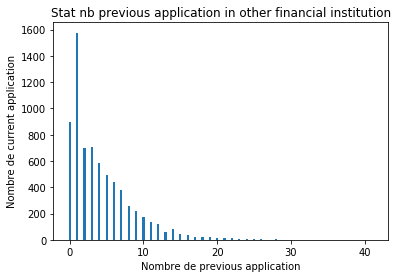

In [1446]:
distrib_nb_previous = dfApplication.merge(dfBureau[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')['SK_ID_CURR'].value_counts().value_counts()
distrib_nb_previous[0] = nbWithoutPrevious
tmp = pd.DataFrame({'nb_previous': pd.Series(distrib_nb_previous.index),
                   'nb_application': distrib_nb_previous.reset_index(drop=True)}).sort_values('nb_previous')
plt.bar(pd.Series(distrib_nb_previous.index), distrib_nb_previous.reset_index(drop=True), width=0.3)
plt.xlabel('Nombre de previous application')
plt.ylabel('Nombre de current application')
plt.title("Stat nb previous application in other financial institution")

## Suppression de variables non pertinentes

### Trop de valeurs manquantes

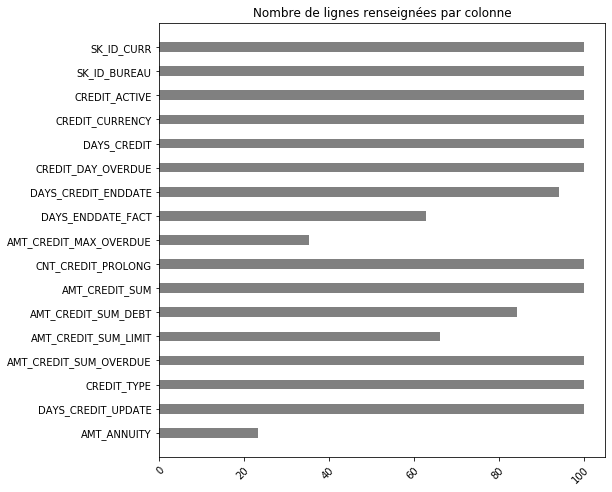

In [1447]:
myDf(dfBureau).ColCountLinesChart(typeChart='barh', displayColName=True)

In [1448]:
del dfBureau['AMT_ANNUITY']

### Trop de valeurs identiques

#### Devise

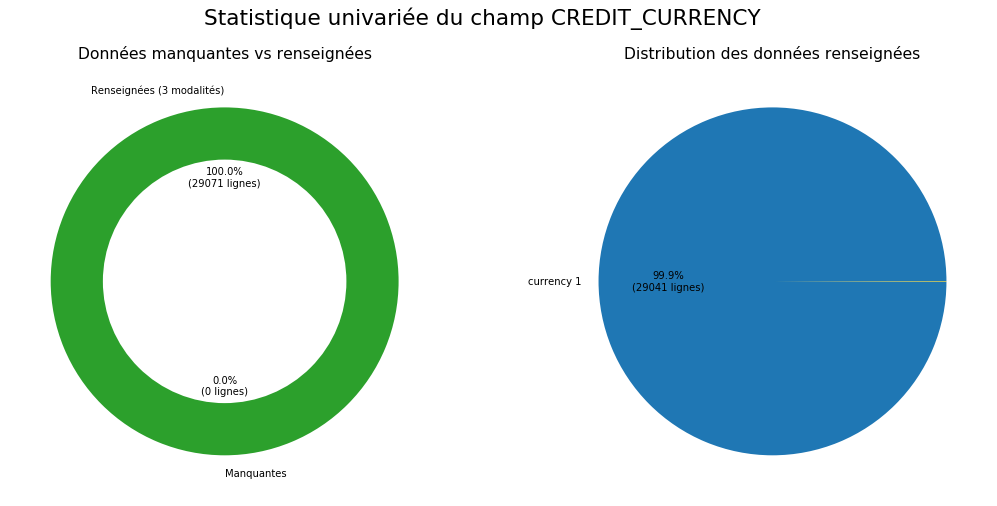

In [1449]:
myDf(dfBureau).Stat('CREDIT_CURRENCY', statsNan=True)

On supprime le champ devise tout en conservant les deux montants

In [1450]:
del dfBureau['CREDIT_CURRENCY']

#### Autres champs

In [1451]:
nb_zero = dfBureau[dfBureau.CNT_CREDIT_PROLONG==0].shape[0]
nb_not_null = dfBureau[~dfBureau.CNT_CREDIT_PROLONG.isnull()].shape[0]
print("CNT_CREDIT_PROLONG: {} sur {} à zéro ({}%)".format(nb_zero, nb_not_null,np.round(nb_zero/nb_not_null*100),1))

CNT_CREDIT_PROLONG: 28878 sur 29071 à zéro (99.0%)


In [1452]:
nb_zero = dfBureau[dfBureau.CREDIT_DAY_OVERDUE==0].shape[0]
nb_not_null = dfBureau[~dfBureau.CREDIT_DAY_OVERDUE.isnull()].shape[0]
print("CREDIT_DAY_OVERDUE: {} sur {} à zéro ({}%)".format(nb_zero, nb_not_null,np.round(nb_zero/nb_not_null*100),1))

CREDIT_DAY_OVERDUE: 28989 sur 29071 à zéro (100.0%)


In [1453]:
nb_zero = dfBureau[dfBureau.AMT_CREDIT_SUM_OVERDUE==0].shape[0]
nb_not_null = dfBureau[~dfBureau.AMT_CREDIT_SUM_OVERDUE.isnull()].shape[0]
print("AMT_CREDIT_SUM_OVERDUE: {} sur {} à zéro ({}%)".format(nb_zero, nb_not_null,np.round(nb_zero/nb_not_null*100),1))

AMT_CREDIT_SUM_OVERDUE: 28993 sur 29071 à zéro (100.0%)


In [1454]:
nb_zero = dfBureau[dfBureau['AMT_CREDIT_SUM_LIMIT']==0].shape[0]
nb_total = dfBureau[~dfBureau['AMT_CREDIT_SUM_LIMIT'].isnull()].shape[0]
print("{} AMT_CREDIT_SUM_LIMIT à zéro sur {} renseignés ({}%)".format(nb_zero,nb_total,np.round(100*nb_zero/nb_total,1)))

17956 AMT_CREDIT_SUM_LIMIT à zéro sur 19233 renseignés (93.4%)


In [1455]:
nb_zero = dfBureau[dfBureau['AMT_CREDIT_MAX_OVERDUE']==0].shape[0]
nb_total = dfBureau[~dfBureau['AMT_CREDIT_MAX_OVERDUE'].isnull()].shape[0]
print("{} AMT_CREDIT_MAX_OVERDUE à zéro sur {} renseignés ({}%)".format(nb_zero,nb_total,np.round(100*nb_zero/nb_total,1)))

8151 AMT_CREDIT_MAX_OVERDUE à zéro sur 10302 renseignés (79.1%)


In [1456]:
del dfBureau['CNT_CREDIT_PROLONG']
del dfBureau['CREDIT_DAY_OVERDUE']
del dfBureau['AMT_CREDIT_SUM_OVERDUE']
#del dfBureau['AMT_CREDIT_SUM_LIMIT']
#del dfBureau['AMT_CREDIT_MAX_OVERDUE']

## Recherche de corrélations

### Champs days

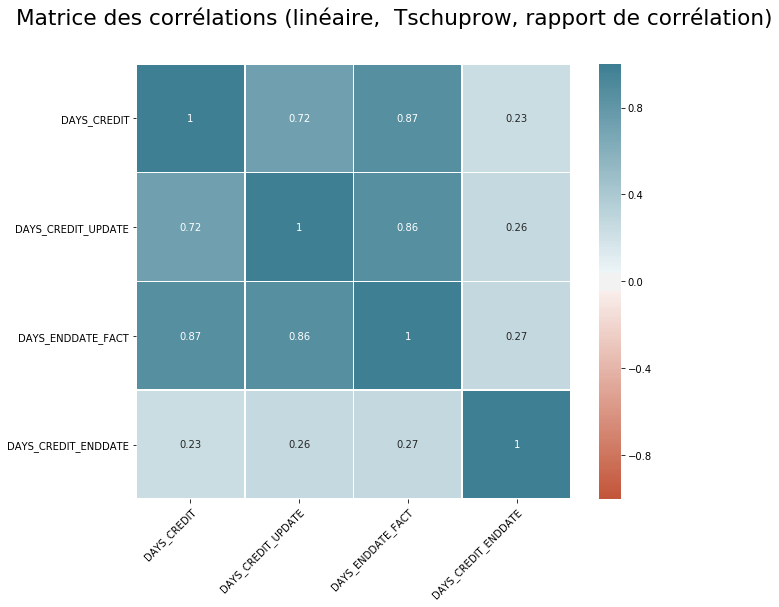

In [1457]:
myDf(dfBureau).Stat(['DAYS_CREDIT','DAYS_CREDIT_UPDATE','DAYS_ENDDATE_FACT','DAYS_CREDIT_ENDDATE'], typeStat='biv', bivOnlyCorrTable=True)

In [1458]:
print('Nombre de lignes avec le champ vide:')
(dfBureau[['DAYS_CREDIT','DAYS_CREDIT_UPDATE','DAYS_ENDDATE_FACT']].isnull()).sum()

Nombre de lignes avec le champ vide:


DAYS_CREDIT               0
DAYS_CREDIT_UPDATE        0
DAYS_ENDDATE_FACT     10769
dtype: int64

In [1459]:
del dfBureau['DAYS_CREDIT_UPDATE']
del dfBureau['DAYS_ENDDATE_FACT']

### Champs amount

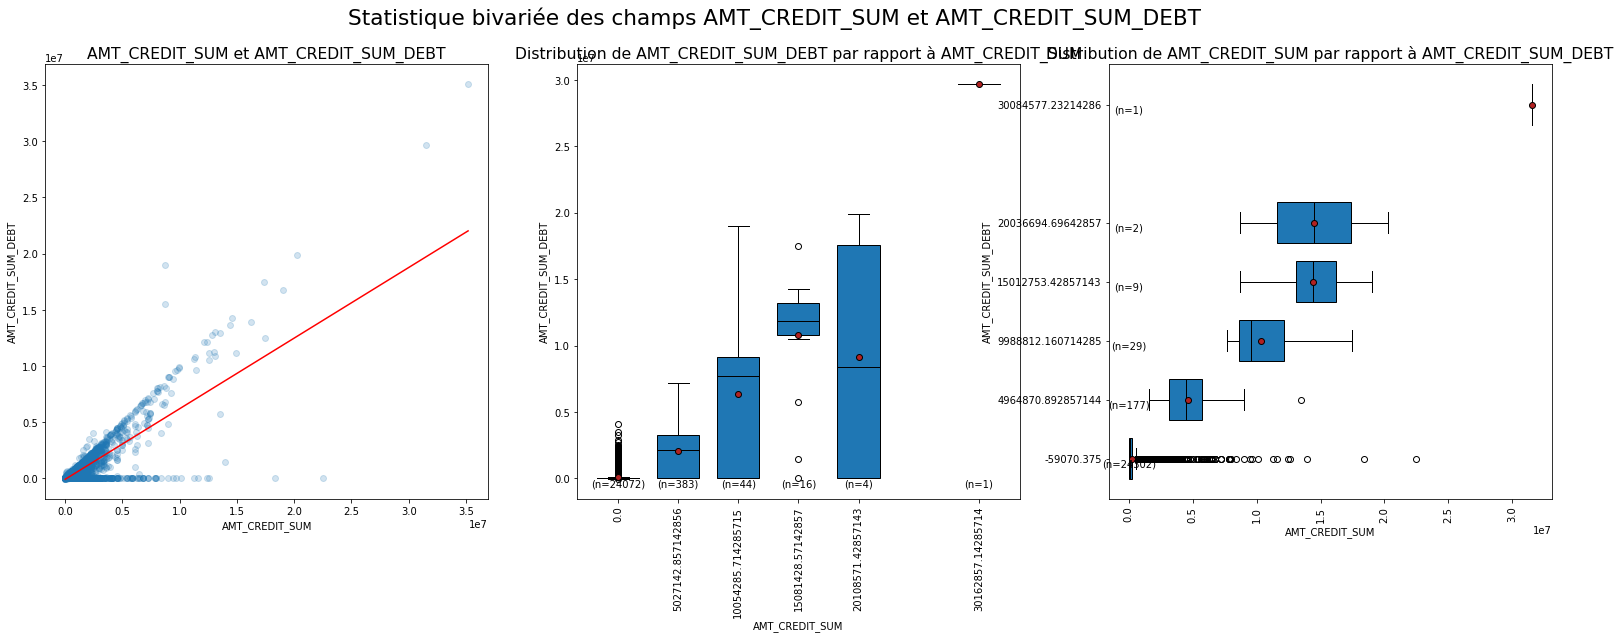

Covariance entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 508311911847.615 
Covariance débiaisée entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 508332642349.72943 
Coefficient de correlation linéaire entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 0.8087405837607027 
Régression linéaire entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT: y = 0.6281366918644833x + -76719.08580998691
Coefficient de détermination entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 0.6540613318216022 


In [1460]:
#del dfBureau['AMT_CREDIT_SUM_LIMIT']
#del dfBureau['AMT_CREDIT_MAX_OVERDUE']
myDf(dfBureau).Stat(['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT'], typeStat='biv')

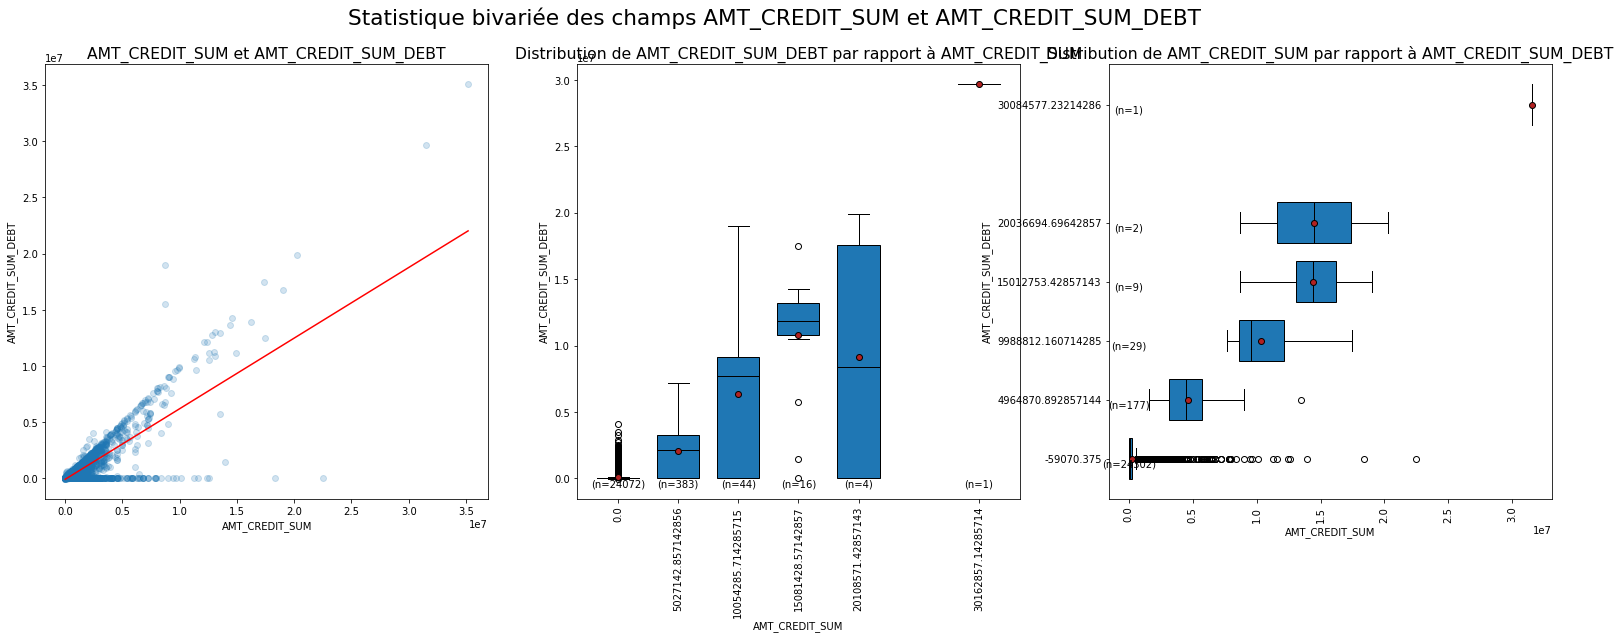

Covariance entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 508311911847.615 
Covariance débiaisée entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 508332642349.72943 
Coefficient de correlation linéaire entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 0.8087405837607027 
Régression linéaire entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT: y = 0.6281366918644833x + -76719.08580998691
Coefficient de détermination entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 0.6540613318216022 


In [1461]:
myDf(dfBureau).Stat(['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT'], typeStat='biv')

In [1462]:
print('Nombre de lignes avec le champ vide:')
(dfBureau[['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT']].isnull()).sum()

Nombre de lignes avec le champ vide:


AMT_CREDIT_SUM            0
AMT_CREDIT_SUM_DEBT    4550
dtype: int64

In [1463]:
del dfBureau['AMT_CREDIT_SUM_DEBT']

### Autres champs

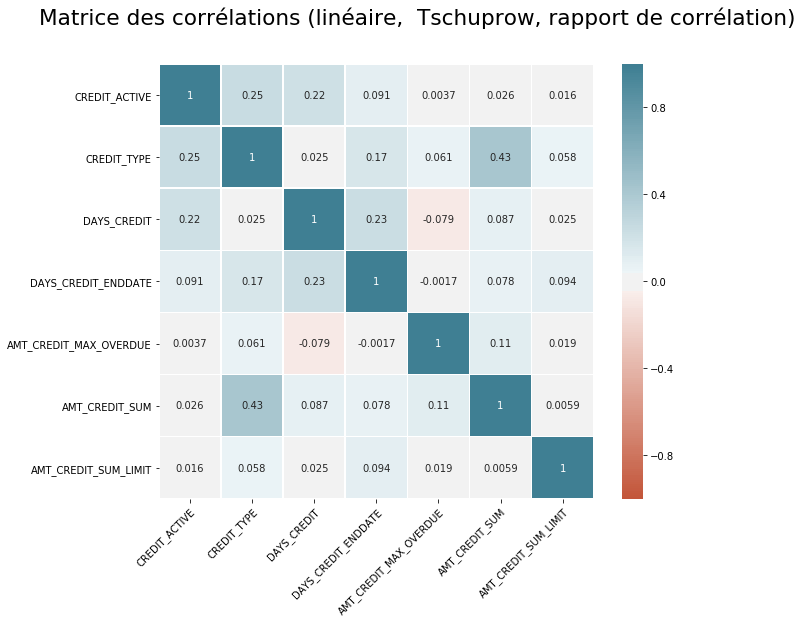

In [1464]:
myDf(dfBureau).Stat(exclCol=['SK_ID_CURR','SK_ID_BUREAU'], typeStat='biv', bivOnlyCorrTable=True)

## Statistique univariée

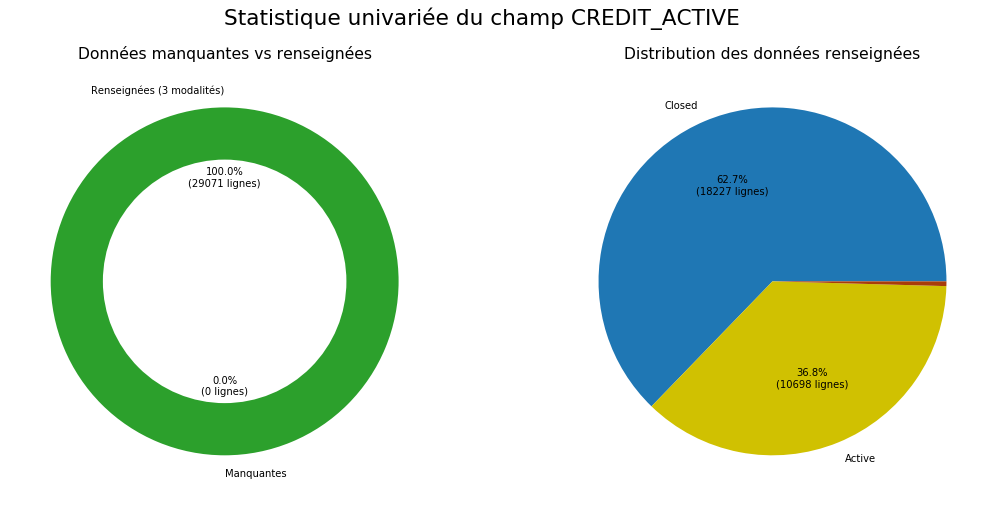

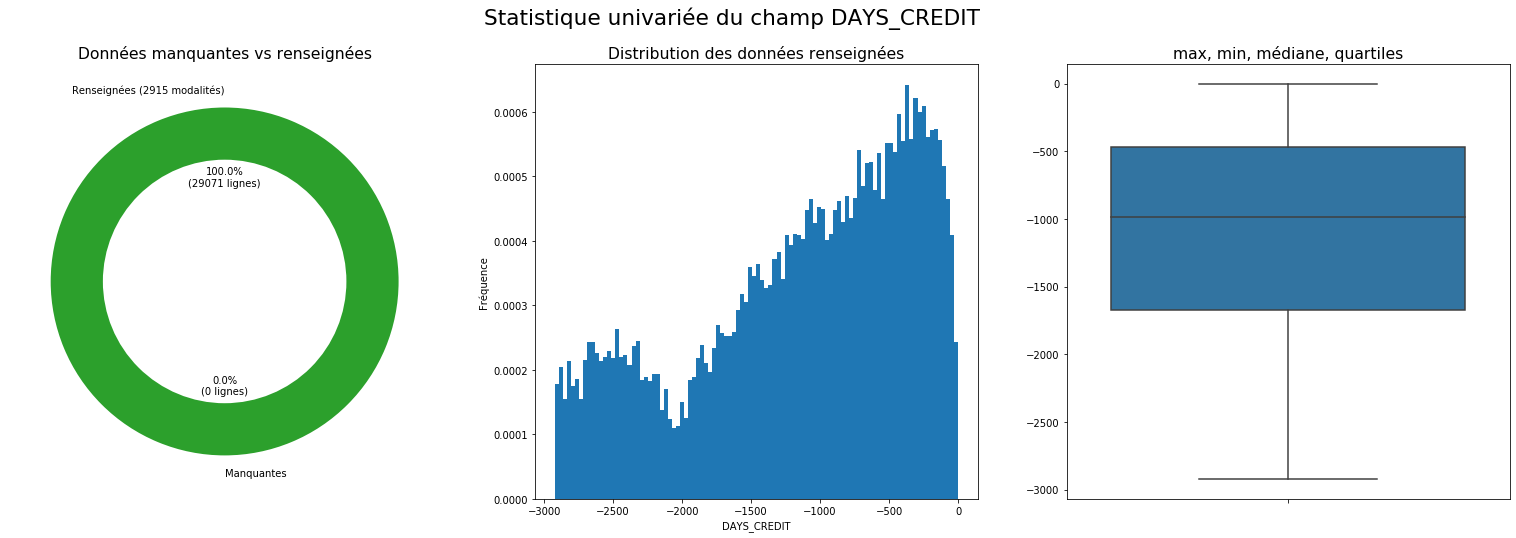

Mesures de position
 - Moyenne: -1140.38
 - Médiane: -987.0
Mesures de dispertion
 - Ecart type: 797.85
 - Min: -2922
 - Q25: -1670.0
 - Q75: -467.0
 - Max: -2
Mesures de forme
 - Skewness (asymétrie): -0.58
 - Kurtosis (applatissement): -0.75


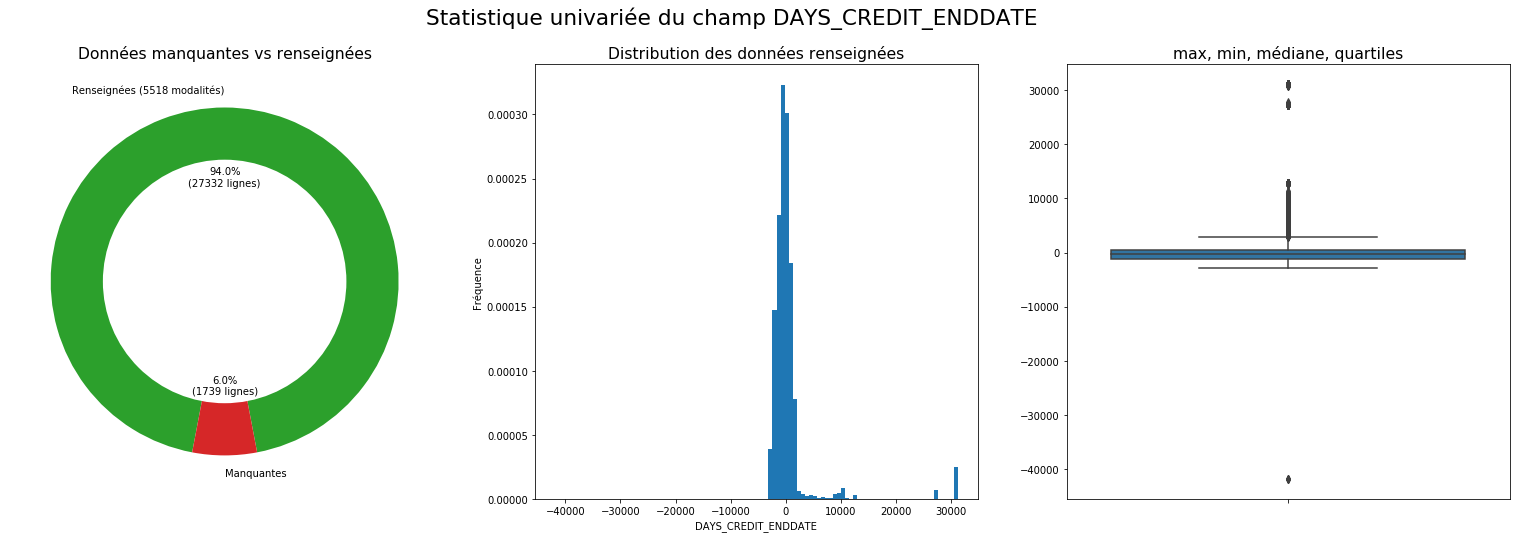

Mesures de position
 - Moyenne: 499.07
 - Médiane: -323.5
Mesures de dispertion
 - Ecart type: 4941.97
 - Min: -41874.0
 - Q25: -1135.0
 - Q75: 484.0
 - Max: 31198.0
Mesures de forme
 - Skewness (asymétrie): 5.09
 - Kurtosis (applatissement): 28.86


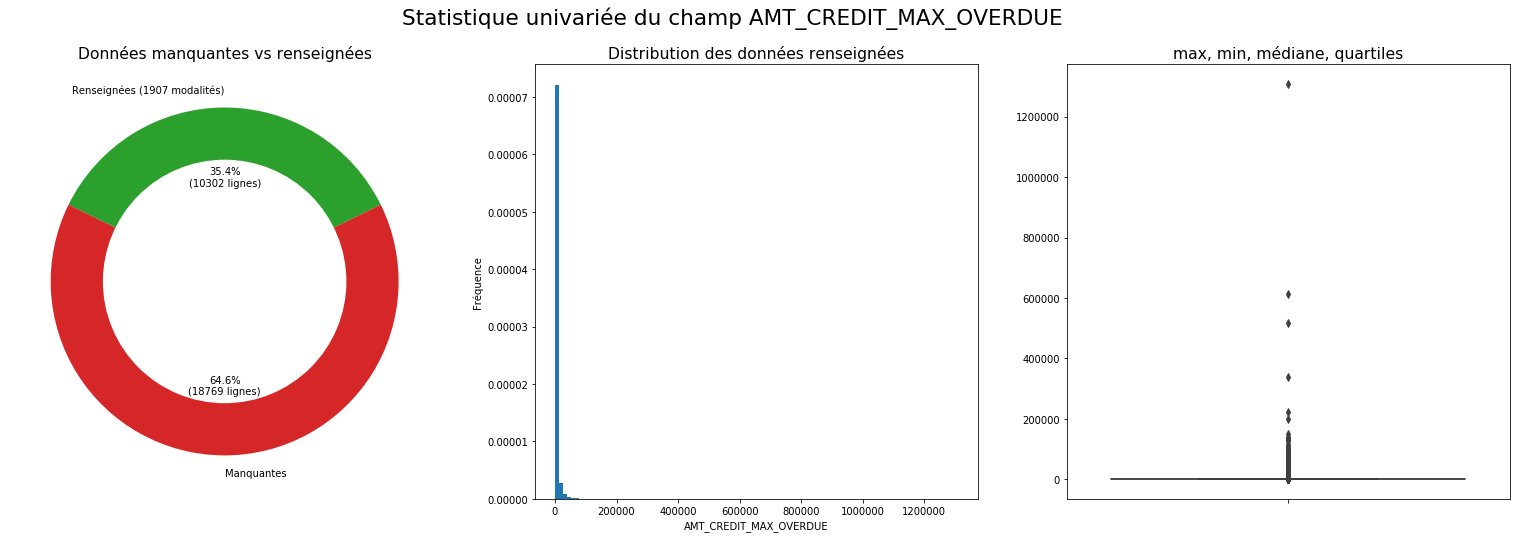

Mesures de position
 - Moyenne: 2689.49
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 17723.1
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 1309014.0
Mesures de forme
 - Skewness (asymétrie): 46.89
 - Kurtosis (applatissement): 3086.77


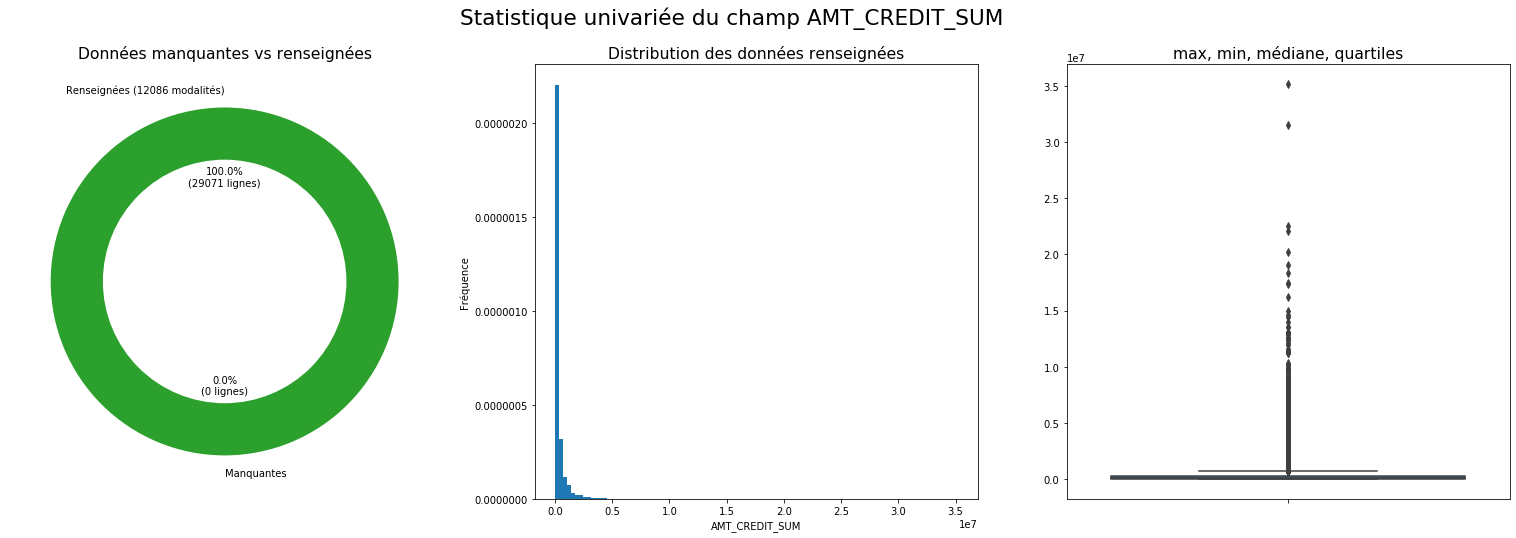

Mesures de position
 - Moyenne: 356984.06
 - Médiane: 126324.0
Mesures de dispertion
 - Ecart type: 904313.2
 - Min: 0.0
 - Q25: 51772.5
 - Q75: 308783.7
 - Max: 35190000.0
Mesures de forme
 - Skewness (asymétrie): 11.1
 - Kurtosis (applatissement): 227.42


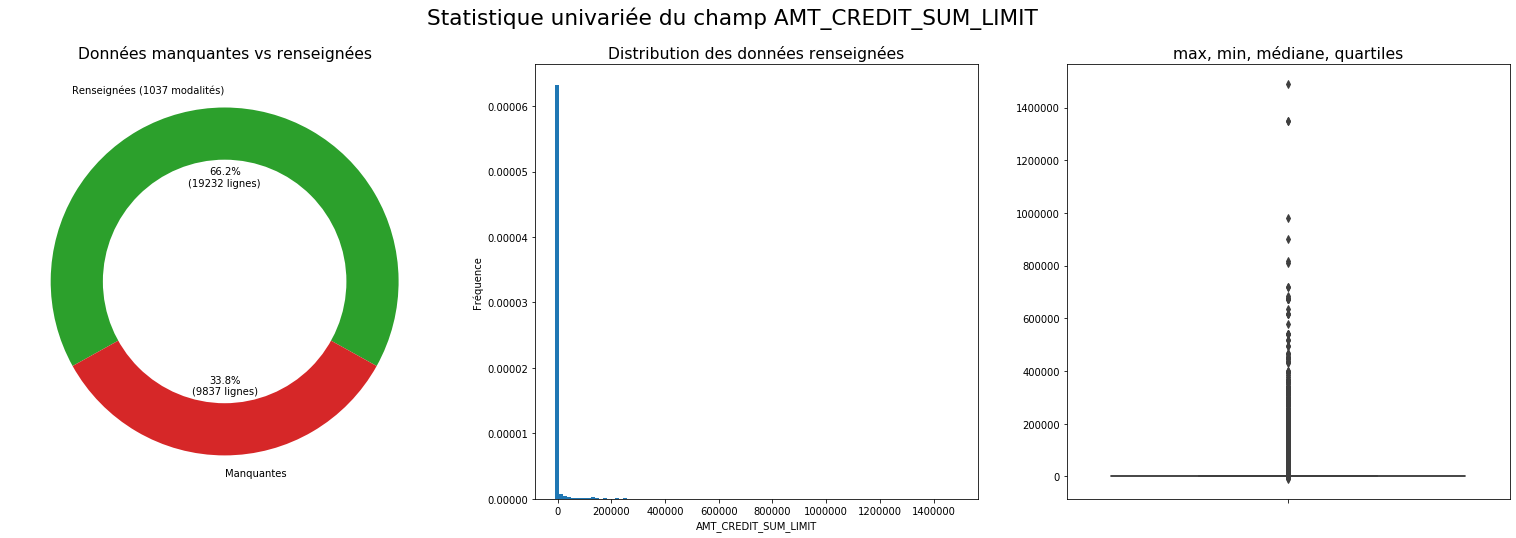

Mesures de position
 - Moyenne: 6016.17
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 43116.99
 - Min: -10266.08
 - Q25: 0.0
 - Q75: 0.0
 - Max: 1490490.32
Mesures de forme
 - Skewness (asymétrie): 13.61
 - Kurtosis (applatissement): 278.55


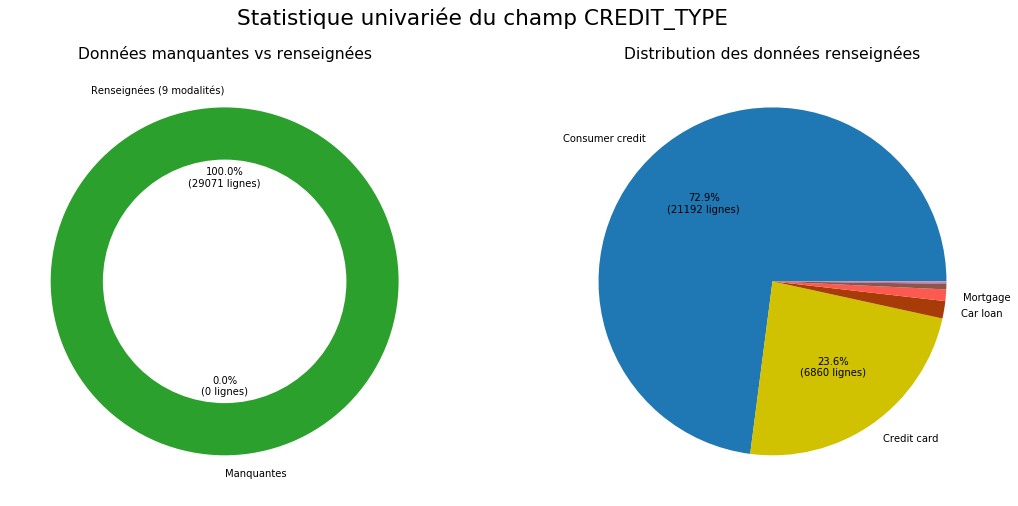

In [1465]:
myDf(dfBureau).Stat(typeStat='univ', statsNan=True, exclCol=['SK_ID_BUREAU','SK_ID_CURR'])

## Gestion des outliers

In [1466]:
dfBureau = dfBureau[((dfBureau.DAYS_CREDIT_ENDDATE > -10000) & (dfBureau.DAYS_CREDIT_ENDDATE < 20000)) | dfBureau.DAYS_CREDIT_ENDDATE.isnull()]

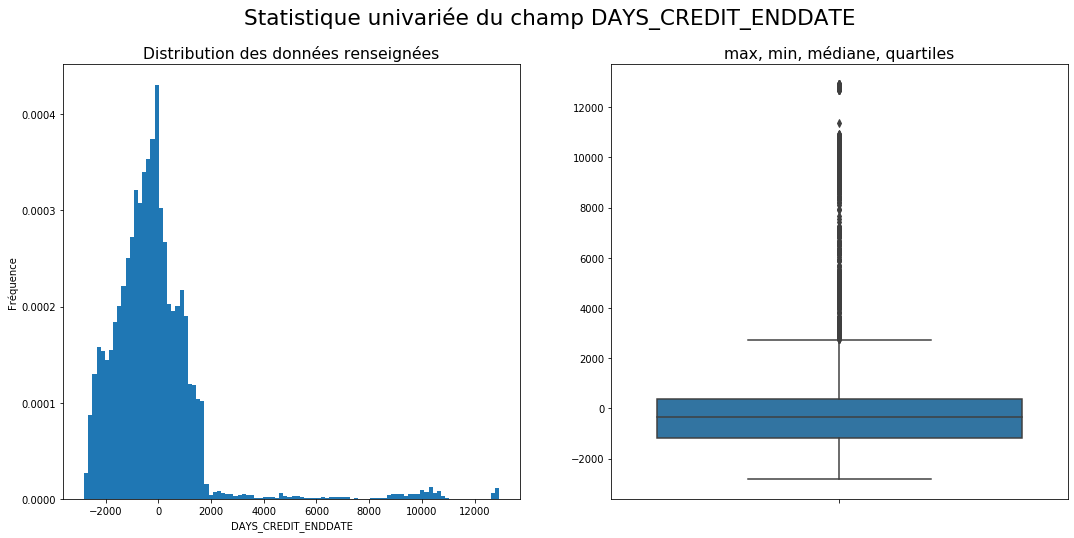

Mesures de position
 - Moyenne: -196.03
 - Médiane: -357.0
Mesures de dispertion
 - Ecart type: 1819.94
 - Min: -2816.0
 - Q25: -1158.0
 - Q75: 390.5
 - Max: 12934.0
Mesures de forme
 - Skewness (asymétrie): 3.46
 - Kurtosis (applatissement): 18.3


In [1467]:
myDf(dfBureau).Stat('DAYS_CREDIT_ENDDATE')

# Exploration de Bureau Balance

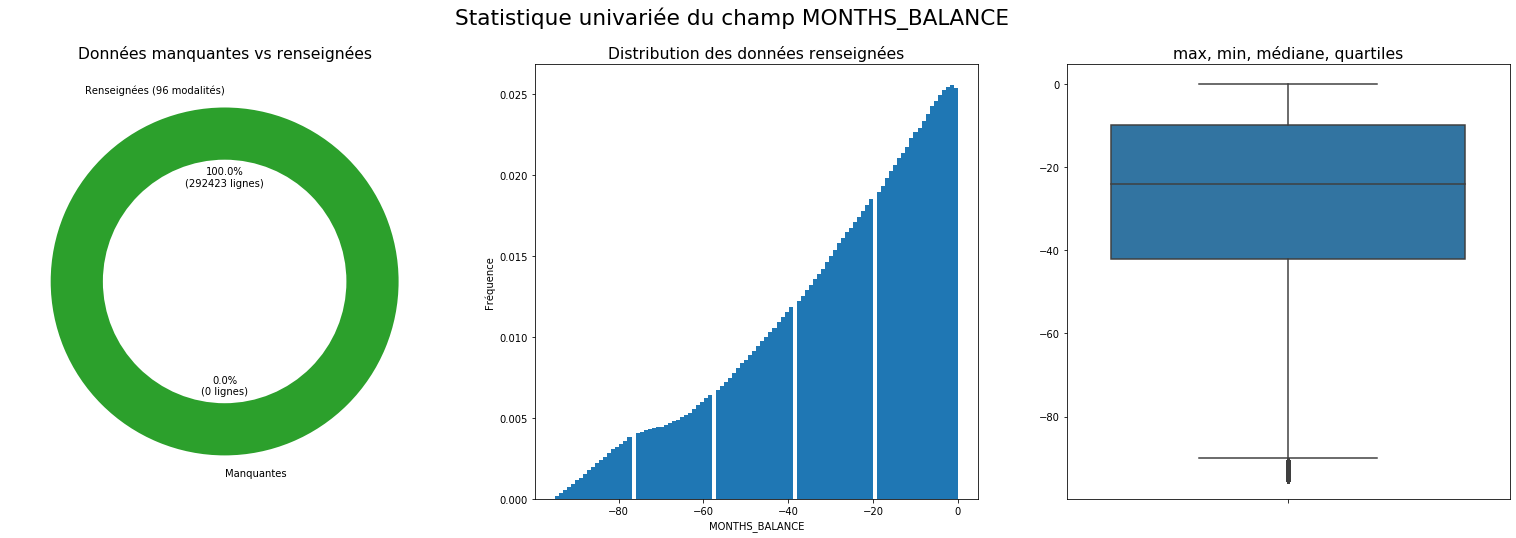

Mesures de position
 - Moyenne: -28.45
 - Médiane: -24.0
Mesures de dispertion
 - Ecart type: 22.05
 - Min: -95
 - Q25: -42.0
 - Q75: -10.0
 - Max: 0
Mesures de forme
 - Skewness (asymétrie): -0.78
 - Kurtosis (applatissement): -0.21


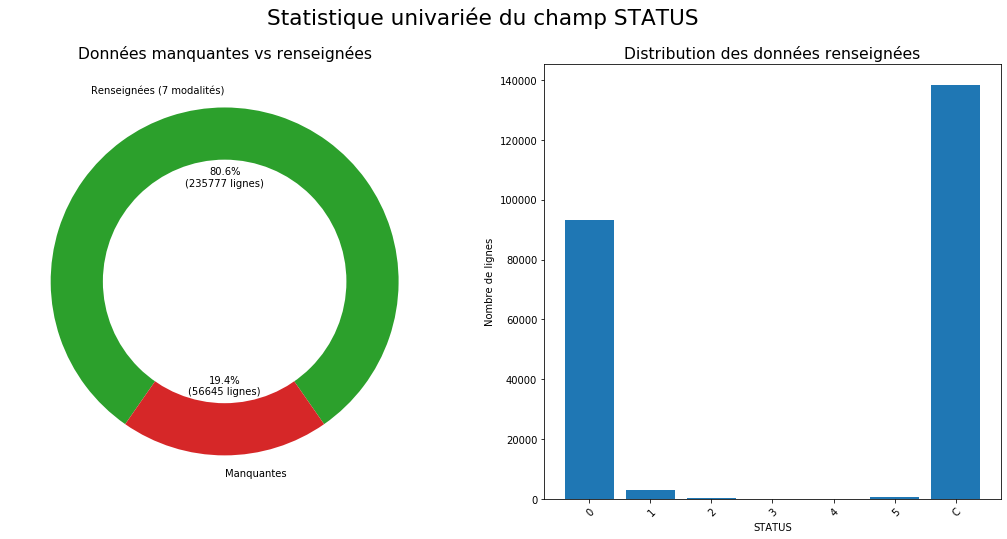

In [1468]:
myDf(dfBureauBalance).Stat(['MONTHS_BALANCE','STATUS'], typeStat='univ', statsNan=True)

# Feature engineering

## Feature engineering sur Application Train

### Passage au log de AMT_INCOME_TOTAL

In [1469]:
dfApplication['AMT_INCOME_TOTAL_LOG'] = dfApplication.apply(lambda x: np.log(x.AMT_INCOME_TOTAL), axis=1)

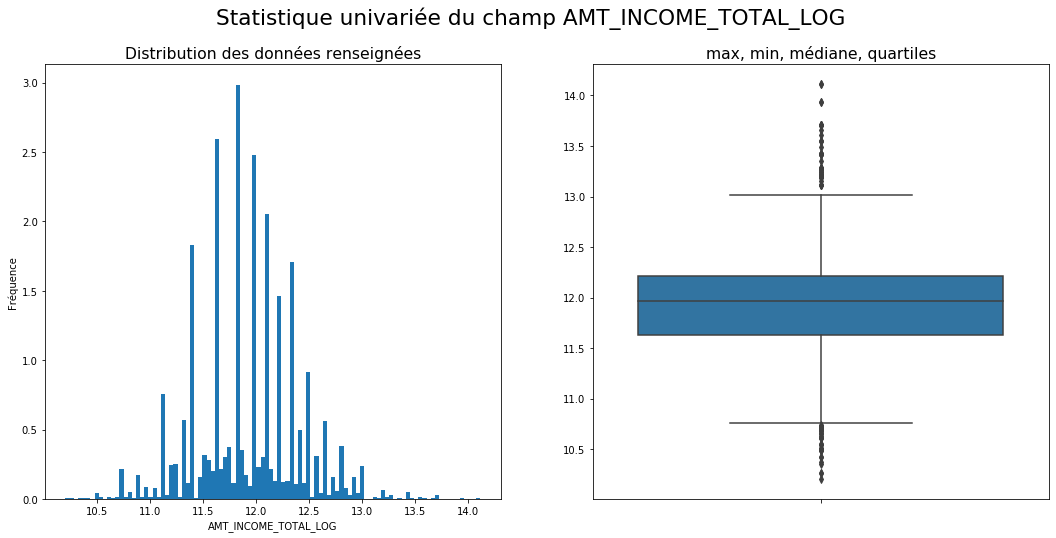

Mesures de position
 - Moyenne: 11.92
 - Médiane: 11.97
Mesures de dispertion
 - Ecart type: 0.49
 - Min: 10.2
 - Q25: 11.63
 - Q75: 12.22
 - Max: 14.12
Mesures de forme
 - Skewness (asymétrie): 0.12
 - Kurtosis (applatissement): 0.48


In [1470]:
myDf(dfApplication).Stat('AMT_INCOME_TOTAL_LOG')

In [1471]:
del dfApplication['AMT_INCOME_TOTAL'] 

### Feature engineering sur NAME_EDUCATION_TYPE et NAME_FAMILY_STATUS

In [1472]:
dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Academic degree'].index, "NAME_EDUCATION_TYPE"] = 1
dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Higher education'].index, "NAME_EDUCATION_TYPE"] = 2
dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Incomplete higher'].index, "NAME_EDUCATION_TYPE"] = 3
dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Secondary / secondary special'].index, "NAME_EDUCATION_TYPE"] = 4
dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Lower secondary'].index, "NAME_EDUCATION_TYPE"] = 5

dfApplication['NAME_EDUCATION_TYPE'] = dfApplication['NAME_EDUCATION_TYPE'].astype(float)

dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Married'].index, "SINGLE_FLAG"] = 0
dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Civil marriage'].index, "SINGLE_FLAG"] = 0
dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Single / not married'].index, "SINGLE_FLAG"] = 1
dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Separated'].index, "SINGLE_FLAG"] = 1
dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Widow'].index, "SINGLE_FLAG"] = 1
dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Unknown'].index, "SINGLE_FLAG"] = 1
del dfApplication['NAME_FAMILY_STATUS']

dfApplication['SINGLE_FLAG'] = dfApplication['SINGLE_FLAG'].astype(float)

## Feature engineering sur des variables communes à Bureau et PreviousApplication

### Days credit et Days decision

In [1473]:
df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','DAYS_CREDIT']]
df1.columns = ['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']
df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']]
dfDays = pd.concat([df1,df2])

In [1474]:
dfDays.isnull().any()

SK_ID_CURR       False
SK_ID_PREV       False
DAYS_DECISION    False
dtype: bool

In [1475]:
#https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering
grp = dfDays[['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_DECISION']].groupby(by = ['SK_ID_CURR'])
grp1 = grp.apply(lambda x: x.sort_values(['DAYS_DECISION'], ascending = False)).reset_index(drop = True)#rename(index = str, columns = {'DAYS_CREDIT': 'DAYS_CREDIT_DIFF'})
grp1['DAYS_DECISION1'] = grp1['DAYS_DECISION']*-1
grp1['DAYS_DIFF'] = grp1.groupby(by = ['SK_ID_CURR'])['DAYS_DECISION1'].diff()
grp1['DAYS_DIFF'] = grp1['DAYS_DIFF'].fillna(0).astype('uint32')
del grp1['DAYS_DECISION1'], grp1['DAYS_DECISION'], grp1['SK_ID_CURR']
dfDays = dfDays.merge(grp1, left_on='SK_ID_PREV', right_on='SK_ID_PREV')
del dfDays['DAYS_DECISION']
del dfDays['SK_ID_PREV']
dfDays = dfDays.groupby('SK_ID_CURR').mean().reset_index(drop=False)
dfDays['DAYS_DIFF'] = dfDays['DAYS_DIFF'].astype(float)

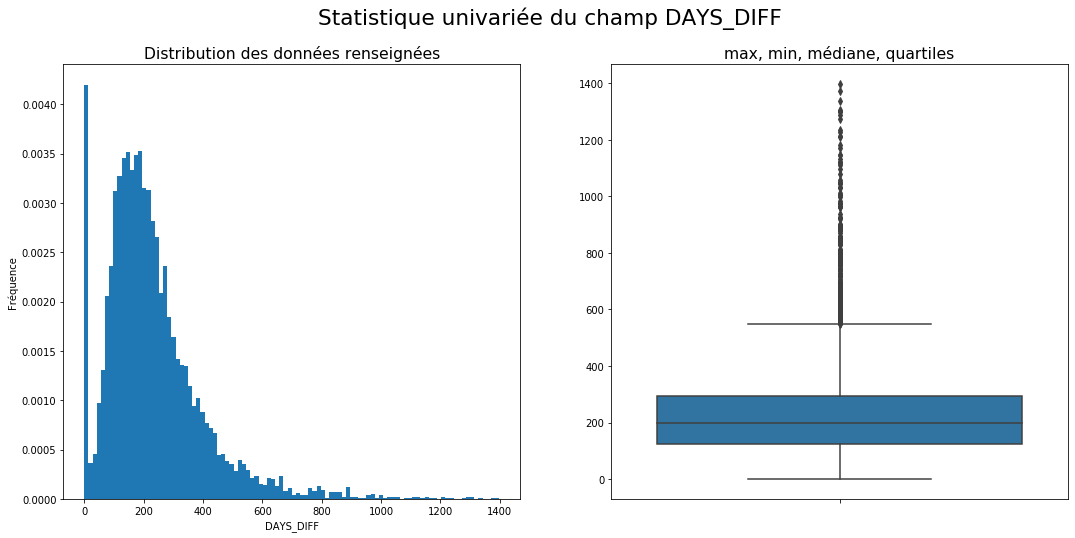

Mesures de position
 - Moyenne: 230.98
 - Médiane: 197.09
Mesures de dispertion
 - Ecart type: 168.94
 - Min: 0.0
 - Q25: 125.11
 - Q75: 295.03
 - Max: 1398.0
Mesures de forme
 - Skewness (asymétrie): 1.91
 - Kurtosis (applatissement): 6.34


In [1476]:
myDf(dfDays).Stat('DAYS_DIFF')

### Champs amount

#### Création d'une variable montant moyen logarithmique

Passage au log des montants

In [1477]:
dfPreviousApplication['AMT_CREDIT_LOG'] = dfPreviousApplication.apply(lambda x: np.log(x.AMT_CREDIT+1), axis=1)
dfBureau['AMT_CREDIT_SUM_LOG'] = dfBureau.apply(lambda x: np.log(x.AMT_CREDIT_SUM+1), axis=1)

Concaténation

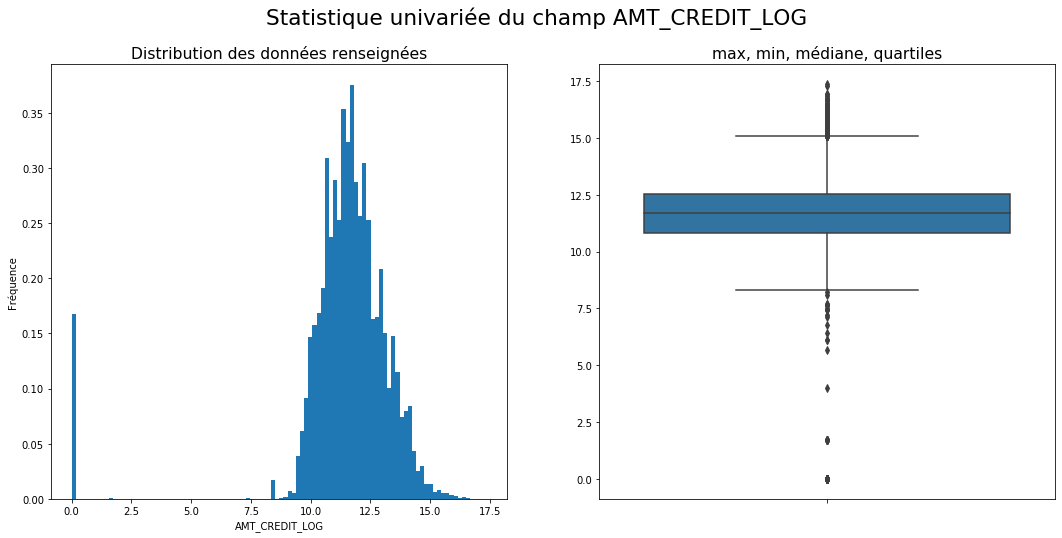

Mesures de position
 - Moyenne: 11.47
 - Médiane: 11.68
Mesures de dispertion
 - Ecart type: 2.33
 - Min: 0.0
 - Q25: 10.82
 - Q75: 12.52
 - Max: 17.38
Mesures de forme
 - Skewness (asymétrie): -3.32
 - Kurtosis (applatissement): 14.46


In [1478]:
df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','AMT_CREDIT_SUM_LOG']]
df1.columns = ['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT_LOG']
df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT_LOG']]
dfAmtLog = pd.concat([df1,df2])
myDf(dfAmtLog).Stat('AMT_CREDIT_LOG')

Moyenne

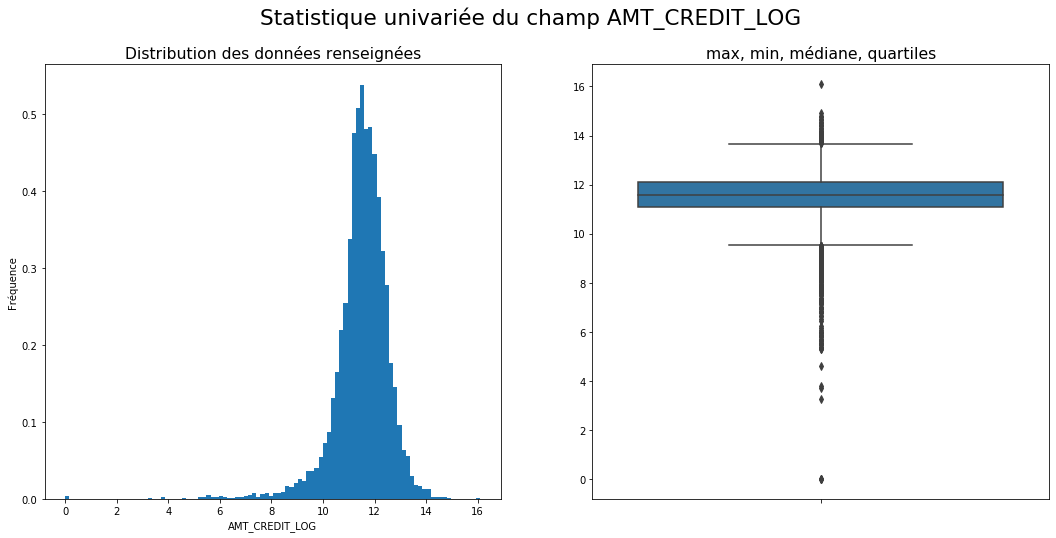

Mesures de position
 - Moyenne: 11.5
 - Médiane: 11.58
Mesures de dispertion
 - Ecart type: 1.08
 - Min: 0.0
 - Q25: 11.07
 - Q75: 12.11
 - Max: 16.11
Mesures de forme
 - Skewness (asymétrie): -2.14
 - Kurtosis (applatissement): 13.97


In [1479]:
del dfAmtLog['SK_ID_PREV']
dfAmtLogMean = dfAmtLog.groupby('SK_ID_CURR').mean().reset_index(drop=False)
myDf(dfAmtLogMean).Stat('AMT_CREDIT_LOG')

#### Création d'une variable écart type logarithmique des montants 

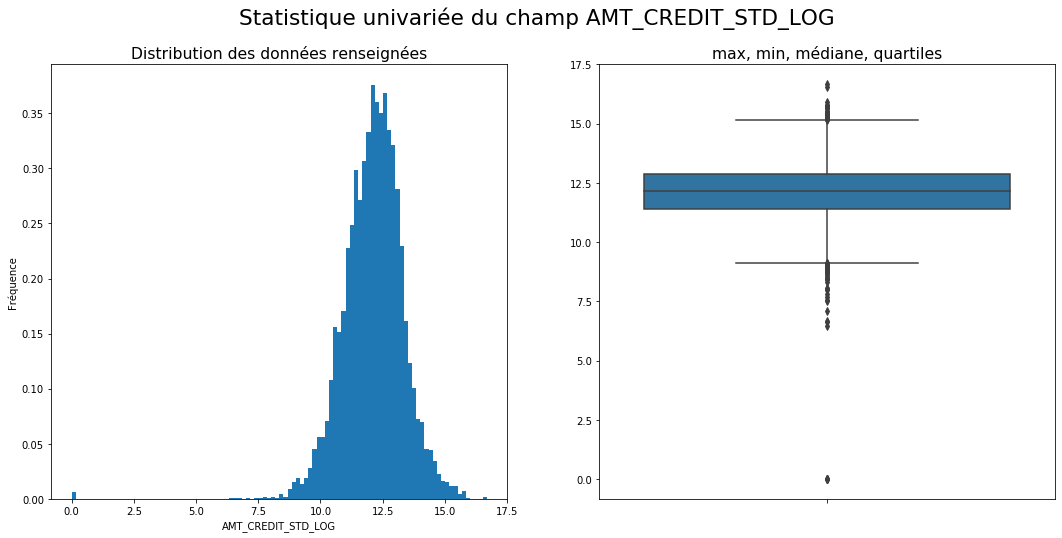

Mesures de position
 - Moyenne: 12.12
 - Médiane: 12.18
Mesures de dispertion
 - Ecart type: 1.22
 - Min: 0.0
 - Q25: 11.38
 - Q75: 12.89
 - Max: 16.68
Mesures de forme
 - Skewness (asymétrie): -1.13
 - Kurtosis (applatissement): 10.1


In [1480]:
df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','AMT_CREDIT_SUM']]
df1.columns = ['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT']
df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT']]
dfAmt = pd.concat([df1,df2])
del dfAmt['SK_ID_PREV']
dfAmtStdLog = dfAmt.groupby('SK_ID_CURR').std().reset_index(drop=False).rename(columns = {'AMT_CREDIT': 'AMT_CREDIT_STD'})
dfAmtStdLog['AMT_CREDIT_STD_LOG'] = dfAmtStdLog.apply(lambda x: np.log(1+x.AMT_CREDIT_STD), axis=1)
del dfAmtStdLog['AMT_CREDIT_STD']
myDf(dfAmtStdLog).Stat('AMT_CREDIT_STD_LOG')

#### Visualisation d'une variable écart type des montants logarithmique (non conservée)

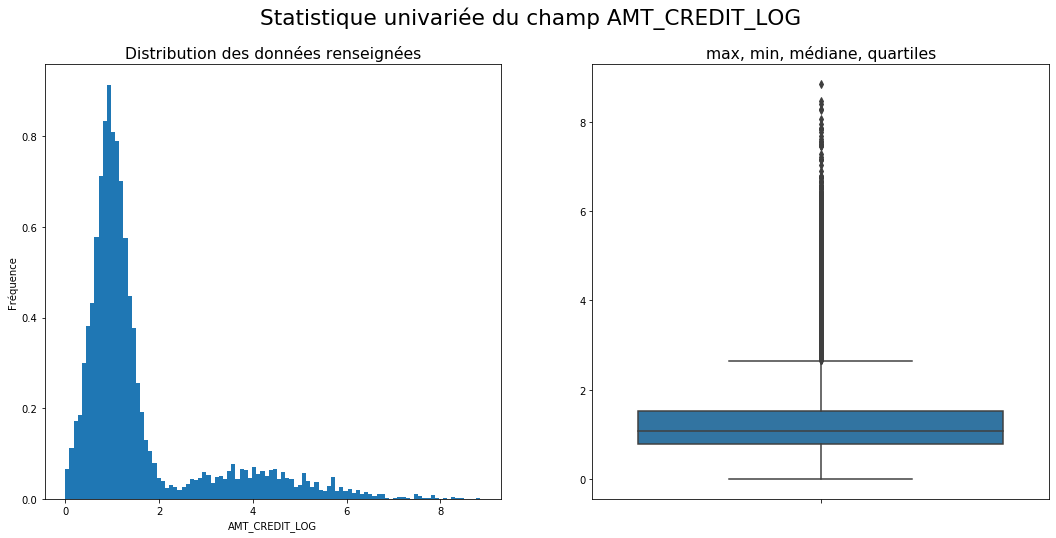

Mesures de position
 - Moyenne: 1.57
 - Médiane: 1.08
Mesures de dispertion
 - Ecart type: 1.41
 - Min: 0.0
 - Q25: 0.78
 - Q75: 1.53
 - Max: 8.85
Mesures de forme
 - Skewness (asymétrie): 1.95
 - Kurtosis (applatissement): 3.3


In [1481]:
myDf(dfAmtLog.groupby('SK_ID_CURR').std().reset_index(drop=False)).Stat('AMT_CREDIT_LOG')

In [1482]:
del dfBureau['AMT_CREDIT_SUM_LOG']

In [1483]:
del dfPreviousApplication['AMT_CREDIT_LOG']

## Feature engineering sur PreviousApplication

### Feature engineering sur NAME_YIELD_GROUP

In [1484]:
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'high'].index, "NAME_YIELD_GROUP"] = 3
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'middle'].index, "NAME_YIELD_GROUP"] = 2
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'low_normal'].index, "NAME_YIELD_GROUP"] = 1
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'low_action'].index, "NAME_YIELD_GROUP"] = 1
dfPreviousApplication['NAME_YIELD_GROUP'] = dfPreviousApplication['NAME_YIELD_GROUP'].astype(float) 

### Feature engineering sur NAME_SELLER_INDUSTRY

#### NameSellerIndustry avec le plus gros montant cumulé par client

In [1485]:
tmp0 = dfPreviousApplication[~dfPreviousApplication.NAME_SELLER_INDUSTRY.isnull()].reset_index(drop=False)
tmp1 = tmp0[['SK_ID_CURR','NAME_SELLER_INDUSTRY','AMT_CREDIT']].groupby(['SK_ID_CURR','NAME_SELLER_INDUSTRY']).sum().reset_index(drop=False)
tmp2 = tmp1[['SK_ID_CURR','AMT_CREDIT']].groupby(['SK_ID_CURR']).max().reset_index(drop=False)
tmp3 = tmp1.merge(tmp2, left_on=['SK_ID_CURR','AMT_CREDIT'], right_on=['SK_ID_CURR','AMT_CREDIT'])
tmp3.head(5)

SK_ID_CURR  NAME_SELLER_INDUSTRY  AMT_CREDIT
0      100032  Consumer electronics     42255.0
1      100283  Consumer electronics    106074.0
2      100304              Industry    118633.5
3      100400              Clothing    380803.5
4      100436  Consumer electronics     74245.5

Nombre de clients qui ressortent avec plusieurs lignes: on en sélectionne une au hasard

In [1486]:
x = tmp3.SK_ID_CURR.value_counts()
len(x[x>1])

0

Pour les clients avec plusieurs seller_industry préférés, on en sélectionne un au hasard en se basant sur l'index

In [1487]:
tmp4 = tmp3.reset_index(drop=False)[['SK_ID_CURR','index']].groupby('SK_ID_CURR').max().reset_index(drop=False)
tmp3 = tmp3.reset_index(drop=False)
tmp3 = tmp3.merge(tmp4, left_on=['SK_ID_CURR','index'], right_on=['SK_ID_CURR','index'])
dfPreviousApplicationMainSellerIndustry = tmp3[['SK_ID_CURR','NAME_SELLER_INDUSTRY']]
dfPreviousApplicationMainSellerIndustry.columns = ['SK_ID_CURR','MAIN_SELLER_INDUSTRY']

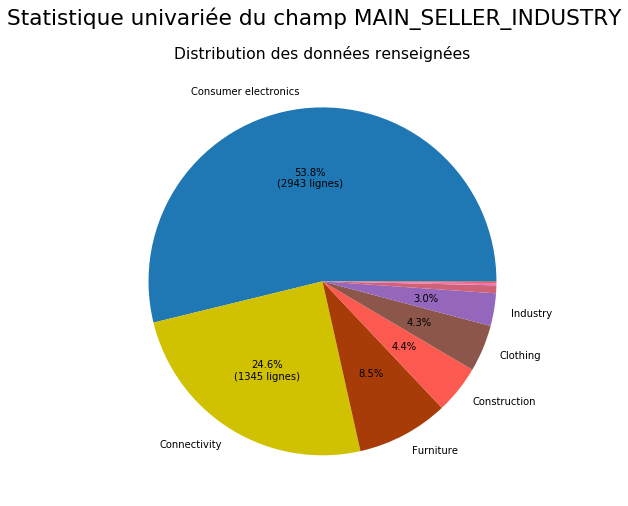

In [1488]:
myDf(dfPreviousApplicationMainSellerIndustry).Stat('MAIN_SELLER_INDUSTRY')

#### Nombre de type de seller industry par client

In [1489]:
dfPreviousApplicationNbSellerIndustry = dfPreviousApplication[['SK_ID_CURR','NAME_SELLER_INDUSTRY']].drop_duplicates().groupby('SK_ID_CURR').count().reset_index(drop=False)
dfPreviousApplicationNbSellerIndustry.columns = ['SK_ID_CURR','NB_SELLER_INDUSTRY']

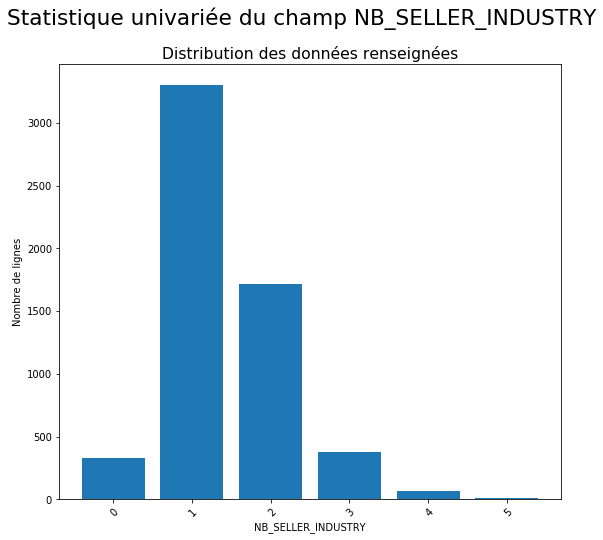

In [1490]:
myDf(dfPreviousApplicationNbSellerIndustry).Stat('NB_SELLER_INDUSTRY')

#### Merge avec dfPreviousApplication

In [1491]:
dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationMainSellerIndustry, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationNbSellerIndustry, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
del dfPreviousApplication['NAME_SELLER_INDUSTRY']

### Création d'une variable nombre de previous application

In [1492]:
dfNbPreviousApplication = pd.DataFrame(dfPreviousApplication.groupby('SK_ID_CURR').size(), columns=['NB_PREVIOUS']).reset_index(drop=False)
dfPreviousApplication = dfPreviousApplication.merge(dfNbPreviousApplication, left_on='SK_ID_CURR', right_on='SK_ID_CURR')

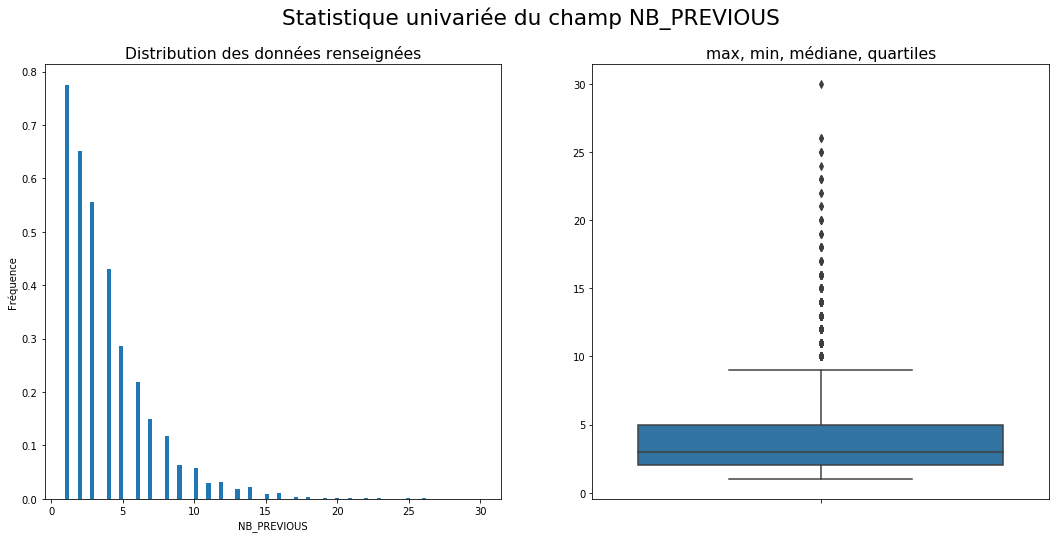

Mesures de position
 - Moyenne: 3.86
 - Médiane: 3.0
Mesures de dispertion
 - Ecart type: 3.13
 - Min: 1
 - Q25: 2.0
 - Q75: 5.0
 - Max: 30
Mesures de forme
 - Skewness (asymétrie): 2.08
 - Kurtosis (applatissement): 6.85


In [1493]:
myDf(dfNbPreviousApplication).Stat('NB_PREVIOUS')

In [1494]:
del dfPreviousApplication['AMT_CREDIT']

### Autres feature engineering sur PreviousApplication

In [1495]:
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS == 'Approved'].index, "NAME_CONTRACT_STATUS"] = 1
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS == 'Refused'].index, "NAME_CONTRACT_STATUS"] = 0
dfPreviousApplication['NAME_CONTRACT_STATUS'] = dfPreviousApplication['NAME_CONTRACT_STATUS'].astype(float)

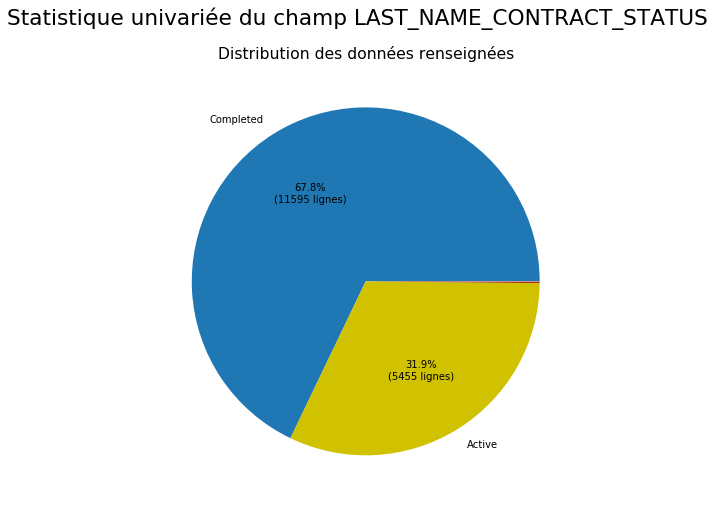

In [1496]:
myDf(dfPreviousApplication).Stat('LAST_NAME_CONTRACT_STATUS')

In [1497]:
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.LAST_NAME_CONTRACT_STATUS == 'Completed'].index, "LAST_NAME_CONTRACT_STATUS_TMP"] = 0
dfPreviousApplication.at[dfPreviousApplication[(dfPreviousApplication.LAST_NAME_CONTRACT_STATUS != 'Completed') & (~dfPreviousApplication.LAST_NAME_CONTRACT_STATUS.isnull())].index, "LAST_NAME_CONTRACT_STATUS_TMP"] = 1
dfPreviousApplication['LAST_NAME_CONTRACT_STATUS'] = dfPreviousApplication['LAST_NAME_CONTRACT_STATUS_TMP']
del dfPreviousApplication['LAST_NAME_CONTRACT_STATUS_TMP']
dfPreviousApplication['LAST_NAME_CONTRACT_STATUS'] = dfPreviousApplication['LAST_NAME_CONTRACT_STATUS'].astype(float)

In [328]:
dfXSell = dfPreviousApplication[dfPreviousApplication.NAME_PRODUCT_TYPE == 'x-sell'][['SK_ID_CURR']].drop_duplicates()
dfXSell['X_SELL'] = 1
dfPreviousApplication = dfPreviousApplication.merge(dfXSell, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfPreviousApplication['X_SELL'] = dfPreviousApplication.apply(lambda x: np.where(x.X_SELL==1,1,0), axis=1)
dfPreviousApplication.X_SELL = dfPreviousApplication.X_SELL.astype(float)
del dfPreviousApplication['NAME_PRODUCT_TYPE']

## Feature engineering sur Bureau

### Transformation de CREDIT_ACTIVE

On considère que les status Sold et Bad debt correspondent à de crédits actifs (comme dans https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering)

In [329]:
tmp = dfBureau[['CREDIT_ACTIVE','DAYS_CREDIT_ENDDATE']]
tmp = tmp[~tmp.DAYS_CREDIT_ENDDATE.isnull()]
tmp = tmp[tmp.DAYS_CREDIT_ENDDATE != 0]
tmp['DAYS_CREDIT_ENDDATE'] = tmp['DAYS_CREDIT_ENDDATE'] / abs(tmp['DAYS_CREDIT_ENDDATE'])
tmp.groupby(['CREDIT_ACTIVE','DAYS_CREDIT_ENDDATE']).size()

CREDIT_ACTIVE  DAYS_CREDIT_ENDDATE
Active         -1.0                    1311
                1.0                    7666
Closed         -1.0                   15656
                1.0                    1947
Sold           -1.0                      75
                1.0                      33
dtype: int64

In [330]:
dfBureau['CREDIT_ACTIVE'] = dfBureau.apply(lambda x: np.where(x.CREDIT_ACTIVE == 'Active', 1, 0), axis=1)

In [331]:
dfBureau.CREDIT_ACTIVE = dfBureau.CREDIT_ACTIVE.astype(float)

### Feature engineering sur CREDIT_TYPE

#### Type de crédit avec le plus gros montant cumulé par client

In [332]:
tmp0 = dfBureau[~dfBureau.CREDIT_TYPE.isnull()].reset_index(drop=False)
tmp1 = tmp0[['SK_ID_CURR','CREDIT_TYPE','AMT_CREDIT_SUM']].groupby(['SK_ID_CURR','CREDIT_TYPE']).sum().reset_index(drop=False)
tmp2 = tmp1[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(['SK_ID_CURR']).max().reset_index(drop=False)
tmp3 = tmp1.merge(tmp2, left_on=['SK_ID_CURR','AMT_CREDIT_SUM'], right_on=['SK_ID_CURR','AMT_CREDIT_SUM'])
tmp3.head(5)

SK_ID_CURR      CREDIT_TYPE  AMT_CREDIT_SUM
0      100032  Consumer credit      1271160.00
1      100283  Consumer credit       152581.50
2      100304      Credit card      1377000.00
3      100400  Consumer credit       355010.67
4      100436      Credit card       891000.00

Clients qui ressortent avec plusieurs lignes: on en sélectionne une au hasard

In [333]:
x = tmp3.SK_ID_CURR.value_counts()
len(x[x>1])

6

In [334]:
tmp4 = tmp3.reset_index(drop=False)[['SK_ID_CURR','index']].groupby('SK_ID_CURR').max().reset_index(drop=False)
tmp3 = tmp3.reset_index(drop=False)
tmp3 = tmp3.merge(tmp4, left_on=['SK_ID_CURR','index'], right_on=['SK_ID_CURR','index'])
dfBureauMainCreditType = tmp3[['SK_ID_CURR','CREDIT_TYPE']]
dfBureauMainCreditType.columns = ['SK_ID_CURR','MAIN_CREDIT_TYPE']

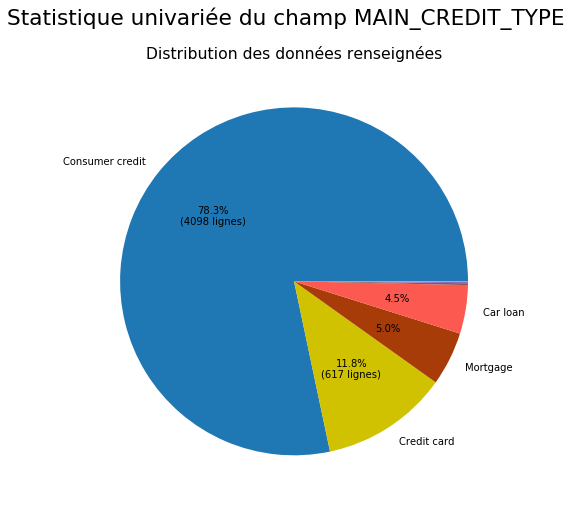

In [335]:
myDf(dfBureauMainCreditType).Stat('MAIN_CREDIT_TYPE')

#### Nombre de type de crédits par client

In [336]:
dfBureauNbCreditType = dfBureau[['SK_ID_CURR','CREDIT_TYPE']].drop_duplicates().groupby('SK_ID_CURR').count().reset_index(drop=False)
dfBureauNbCreditType.columns = ['SK_ID_CURR','NB_CREDIT_TYPE']

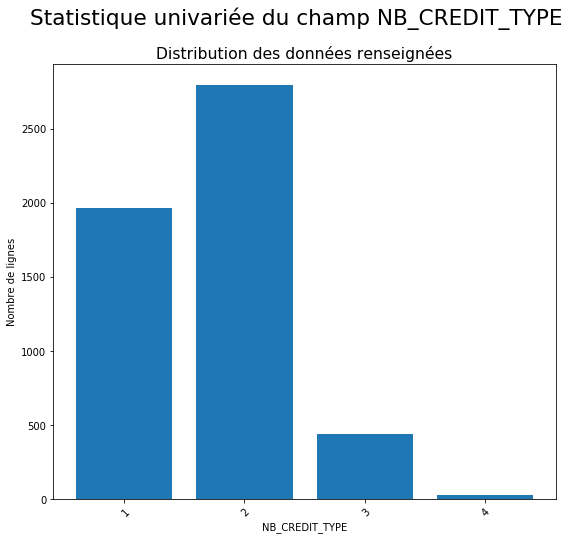

In [337]:
myDf(dfBureauNbCreditType).Stat('NB_CREDIT_TYPE')

#### Merge avec dfBureau

In [338]:
dfBureau = dfBureau.merge(dfBureauMainCreditType, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfBureau = dfBureau.merge(dfBureauNbCreditType, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
del dfBureau['CREDIT_TYPE']

### Création d'une variable nombre de bureau

In [339]:
dfNbBureau = pd.DataFrame(dfBureau.groupby('SK_ID_CURR').size(), columns=['NB_BUREAU']).reset_index(drop=False)
dfBureau = dfBureau.merge(dfNbBureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR')

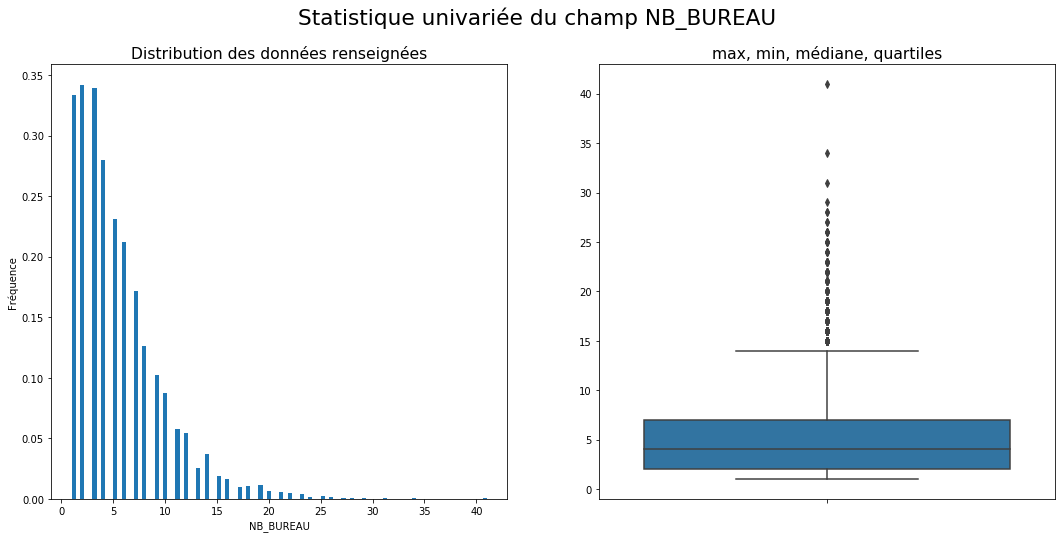

Mesures de position
 - Moyenne: 5.43
 - Médiane: 4.0
Mesures de dispertion
 - Ecart type: 4.24
 - Min: 1
 - Q25: 2.0
 - Q75: 7.0
 - Max: 41
Mesures de forme
 - Skewness (asymétrie): 1.72
 - Kurtosis (applatissement): 4.52


In [340]:
myDf(dfNbBureau).Stat('NB_BUREAU')

In [341]:
del dfBureau['AMT_CREDIT_SUM']

## Fearture engineering sur Installment Payment

In [342]:
dfInstallmentsPayments = dfInstallmentsPayments[dfInstallmentsPayments.AMT_INSTALMENT != 0]

### Nombre d'installment par client

In [343]:
dfInstallmentsPaymentsCount = pd.DataFrame(dfInstallmentsPayments.groupby('SK_ID_CURR').size(), columns=['NB_INSTALLMENT']).reset_index(drop=False)
dfInstallmentsPaymentsCount.head(3)

SK_ID_CURR  NB_INSTALLMENT
0      100032               7
1      100283              16
2      100304               7

### Différence entre les montants et dates effectifs et prévues (positifs et négatifs)

In [344]:
a=time.time()
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT'] = dfInstallmentsPayments.apply(lambda x: x.DAYS_INSTALMENT - x.DAYS_ENTRY_PAYMENT, axis=1)
b=time.time()
print(b-a)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT'] = dfInstallmentsPayments.apply(lambda x: (x.AMT_INSTALMENT - x.AMT_PAYMENT)/x.AMT_INSTALMENT, axis=1)
c=time.time()
print(c-b)
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_DAYS_INSTALLMENT_PAYMENT>0,x.DIFF_DAYS_INSTALLMENT_PAYMENT,0), axis=1)
d=time.time()
print(d-c)
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_DAYS_INSTALLMENT_PAYMENT<0,x.DIFF_DAYS_INSTALLMENT_PAYMENT,0), axis=1)
e=time.time()
print(e-d)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_AMT_INSTALLMENT_PAYMENT>0,x.DIFF_AMT_INSTALLMENT_PAYMENT,0), axis=1)
f=time.time()
print(f-e)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_AMT_INSTALLMENT_PAYMENT<0,x.DIFF_AMT_INSTALLMENT_PAYMENT,0), axis=1)
g=time.time()
print(g-f)


4.138780832290649
5.732511281967163
13.624327182769775
19.464071035385132
19.614649772644043
19.686797618865967


On applique un facteur temporel afin de diminuer l'impact des installments anciens

In [345]:
a=time.time()
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_DAYS_INSTALLMENT_PAYMENT_POS / np.sqrt(1-x.DAYS_ENTRY_PAYMENT), axis=1)
b=time.time()
print(b-a)
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_DAYS_INSTALLMENT_PAYMENT_NEG / np.sqrt(1-x.DAYS_ENTRY_PAYMENT), axis=1)
c=time.time()
print(c-b)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_AMT_INSTALLMENT_PAYMENT_POS / np.sqrt(1-x.DAYS_ENTRY_PAYMENT), axis=1)
d=time.time()
print(d-c)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_AMT_INSTALLMENT_PAYMENT_NEG / np.sqrt(1-x.DAYS_ENTRY_PAYMENT), axis=1)
e=time.time()
print(e-d)

5.7644476890563965
5.734905242919922
5.668141603469849
5.609195947647095


In [346]:
del dfInstallmentsPayments['SK_ID_PREV']
del dfInstallmentsPayments['DAYS_INSTALMENT']
del dfInstallmentsPayments['DAYS_ENTRY_PAYMENT']
del dfInstallmentsPayments['AMT_INSTALMENT']
del dfInstallmentsPayments['AMT_PAYMENT']
del dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT']
del dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT']

On somme par client

In [347]:
dfInstallmentsPayments = dfInstallmentsPayments.groupby('SK_ID_CURR').sum().reset_index(drop=False)

On divise par le nombre d'installments

In [348]:
dfInstallmentsPayments = dfInstallmentsPayments.merge(dfInstallmentsPaymentsCount, right_on='SK_ID_CURR', left_on='SK_ID_CURR')
dfInstallmentsPayments

SK_ID_CURR  DIFF_DAYS_INSTALLMENT_PAYMENT_POS  \
0         100032                           8.704712   
1         100283                           7.783872   
2         100304                          11.858687   
3         100400                          13.808045   
4         100436                          48.454385   
...          ...                                ...   
5768      455855                           4.205249   
5769      455898                          68.534988   
5770      455925                           5.285606   
5771      455987                          24.879263   
5772      456242                          39.233848   

      DIFF_DAYS_INSTALLMENT_PAYMENT_NEG  DIFF_AMT_INSTALLMENT_PAYMENT_POS  \
0                             -0.248851                          0.026698   
1                              0.000000                          0.000000   
2                              0.000000                          0.000000   
3                              0.000000                          0.000000   
4                              0.000000                          0.000000   
...                                 ...                               ...   
5768                           0.000000                          0.000000   
5769                          -3.674871                          0.364200   
5770                           0.000000                          0.000000   
5771                          -0.692590                          0.219206   
5772                          -0.345547                          0.000000   

      DIFF_AMT_INSTALLMENT_PAYMENT_NEG  NB_INSTALLMENT  
0                             0.000000               7  
1                             0.000000              16  
2                            -1.247525               7  
3                             0.000000              19  
4                             0.000000              41  
...                                ...             ...  
5768                          0.000000              13  
5769                         -0.870953             182  
5770                          0.000000               6  
5771                          0.000000             127  
5772                          0.000000              52  

[5773 rows x 6 columns]

In [349]:
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_DAYS_INSTALLMENT_PAYMENT_POS / x.NB_INSTALLMENT, axis=1)
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_DAYS_INSTALLMENT_PAYMENT_NEG / x.NB_INSTALLMENT, axis=1)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_AMT_INSTALLMENT_PAYMENT_POS / x.NB_INSTALLMENT, axis=1)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_AMT_INSTALLMENT_PAYMENT_NEG / x.NB_INSTALLMENT, axis=1)

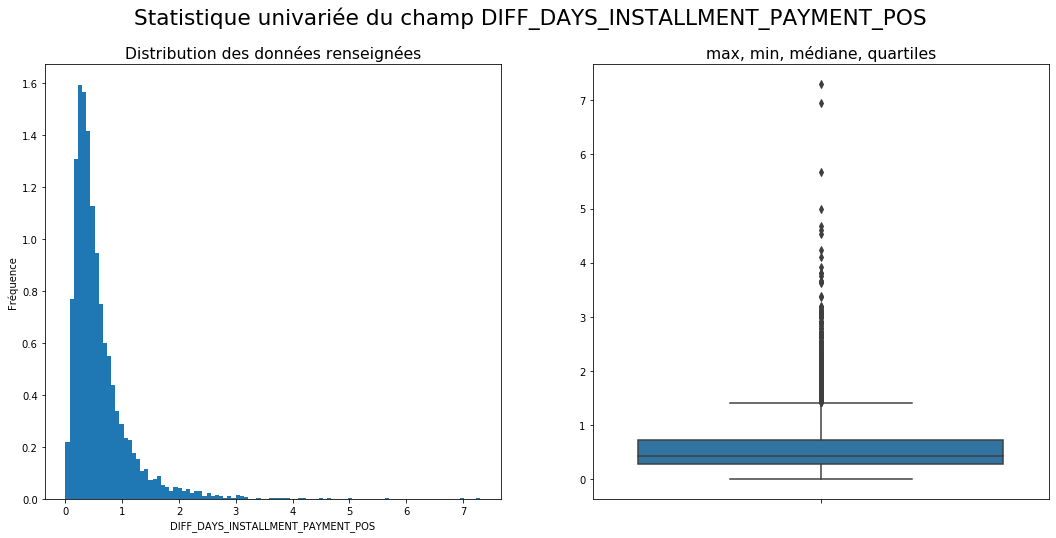

Mesures de position
 - Moyenne: 0.59
 - Médiane: 0.43
Mesures de dispertion
 - Ecart type: 0.52
 - Min: 0.0
 - Q25: 0.27
 - Q75: 0.73
 - Max: 7.31
Mesures de forme
 - Skewness (asymétrie): 3.17
 - Kurtosis (applatissement): 18.96


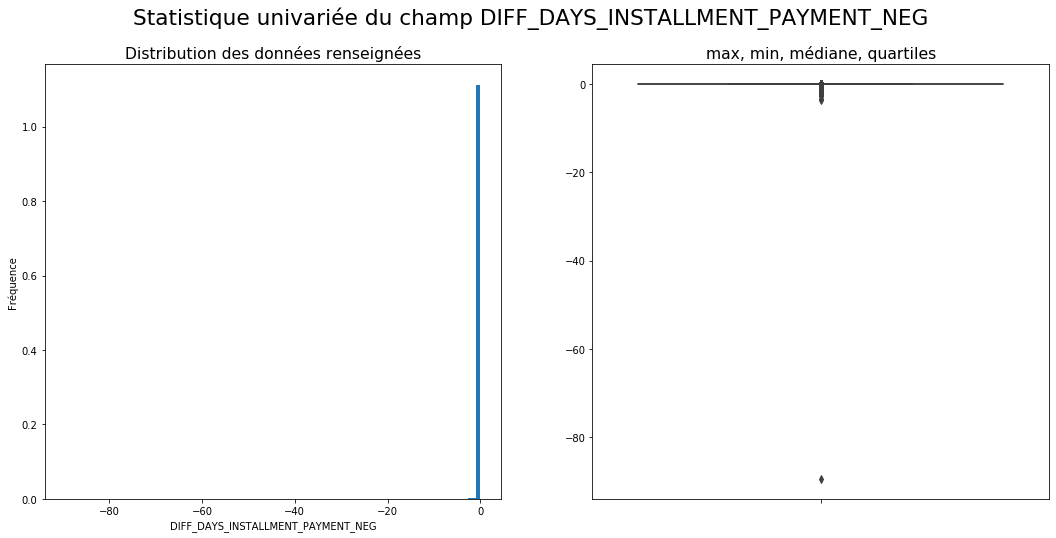

Mesures de position
 - Moyenne: -0.05
 - Médiane: -0.0
Mesures de dispertion
 - Ecart type: 1.19
 - Min: -89.42
 - Q25: -0.02
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -74.33
 - Kurtosis (applatissement): 5601.23


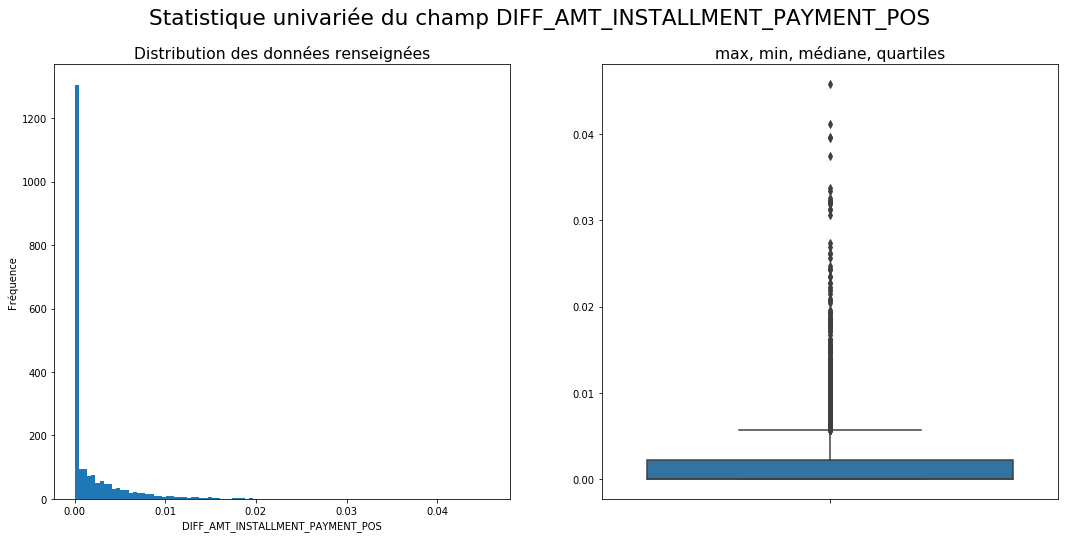

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 0.05
Mesures de forme
 - Skewness (asymétrie): 3.87
 - Kurtosis (applatissement): 22.7


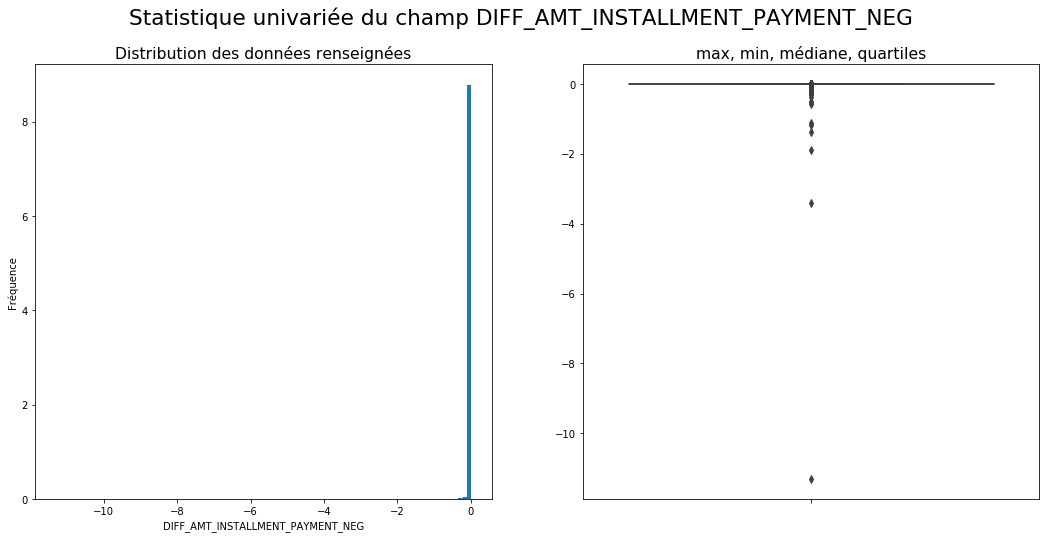

Mesures de position
 - Moyenne: -0.01
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.16
 - Min: -11.31
 - Q25: 0.0
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -61.8
 - Kurtosis (applatissement): 4215.09


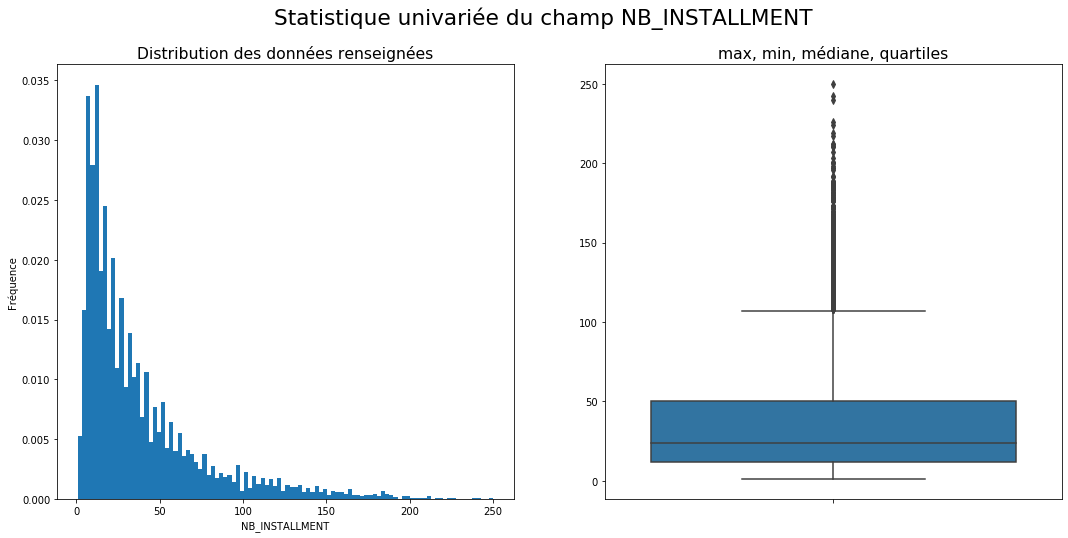

Mesures de position
 - Moyenne: 37.69
 - Médiane: 24.0
Mesures de dispertion
 - Ecart type: 37.19
 - Min: 1
 - Q25: 12.0
 - Q75: 50.0
 - Max: 250
Mesures de forme
 - Skewness (asymétrie): 1.9
 - Kurtosis (applatissement): 3.88


In [350]:
myDf(dfInstallmentsPayments).Stat(exclCol='SK_ID_CURR', typeStat='univ')

## Feature engineering sur Pos Cash Balance

In [351]:
dfPosCashBalanceCount = pd.DataFrame(dfPosCashBalance.groupby('SK_ID_CURR').size(), columns=['NB_POS_CASH_BALANCE']).reset_index(drop=False)
dfPosCashBalanceCount.head(3)

SK_ID_CURR  NB_POS_CASH_BALANCE
0      100032                    7
1      100283                   17
2      100304                    5

In [352]:
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: x.SK_DPD / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
del dfPosCashBalance['MONTHS_BALANCE']
del dfPosCashBalance['SK_ID_PREV']

In [353]:
dfPosCashBalance = dfPosCashBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)

In [354]:
dfPosCashBalance = dfPosCashBalance.merge(dfPosCashBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [355]:
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: x.SK_DPD / x.NB_POS_CASH_BALANCE, axis=1)

In [356]:
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)

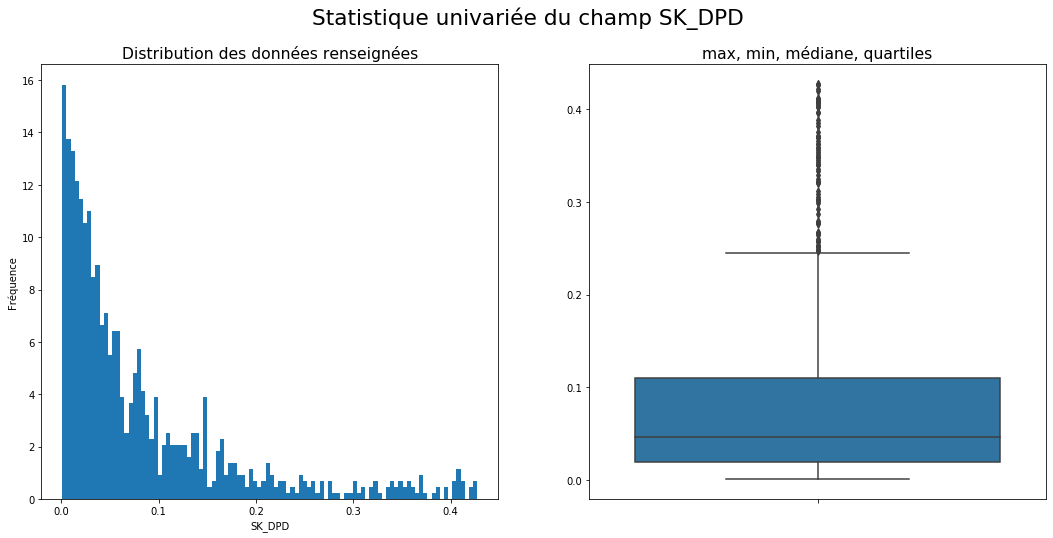

Mesures de position
 - Moyenne: 0.08
 - Médiane: 0.05
Mesures de dispertion
 - Ecart type: 0.09
 - Min: 0.0
 - Q25: 0.02
 - Q75: 0.11
 - Max: 0.43
Mesures de forme
 - Skewness (asymétrie): 1.85
 - Kurtosis (applatissement): 3.11


In [357]:
myDf(dfPosCashBalance[dfPosCashBalance.SK_DPD != 0]).Stat('SK_DPD')

In [358]:
dfPosCashBalance = dfPosCashBalance.rename(columns={'SK_DPD':'SK_DPD_POS_CASH'})

## Feature engineering sur Credit Card Balance

In [359]:
dfCreditCardBalanceCount = pd.DataFrame(dfCreditCardBalance.groupby('SK_ID_CURR').size(), columns=['NB_CREDIT_CARD_BALANCE']).reset_index(drop=False)
dfCreditCardBalanceCount.head(3)

SK_ID_CURR  NB_CREDIT_CARD_BALANCE
0      100437                      13
1      100478                      13
2      100534                       9

In [360]:
dfCreditCardBalance['SK_DPD'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
dfCreditCardBalance['SK_DPD_DEF'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD_DEF / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
del dfCreditCardBalance['MONTHS_BALANCE']
del dfCreditCardBalance['SK_ID_PREV']

In [361]:
dfCreditCardBalance = dfCreditCardBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)

In [362]:
dfCreditCardBalance = dfCreditCardBalance.merge(dfCreditCardBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [363]:
dfCreditCardBalance['SK_DPD'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD / x.NB_CREDIT_CARD_BALANCE, axis=1)
dfCreditCardBalance['SK_DPD_DEF'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD_DEF / x.NB_CREDIT_CARD_BALANCE, axis=1)

In [364]:
dfCreditCardBalance['SK_DPD'] = dfCreditCardBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfCreditCardBalance['SK_DPD_DEF'] = dfCreditCardBalance.apply(lambda x: np.log(1+x.SK_DPD_DEF), axis=1)

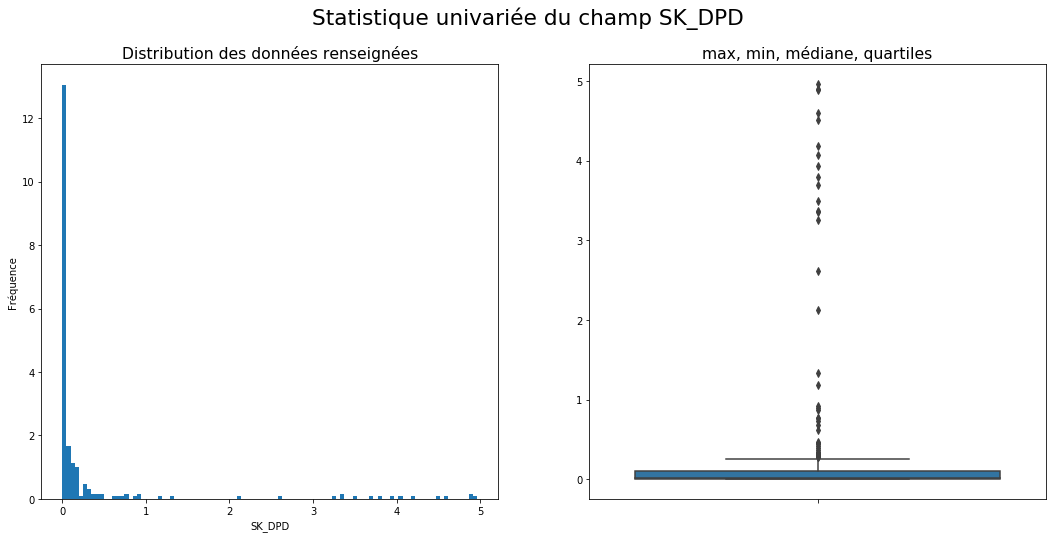

Mesures de position
 - Moyenne: 0.32
 - Médiane: 0.02
Mesures de dispertion
 - Ecart type: 0.94
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.11
 - Max: 4.96
Mesures de forme
 - Skewness (asymétrie): 3.72
 - Kurtosis (applatissement): 12.84


In [365]:
myDf(dfCreditCardBalance[dfCreditCardBalance.SK_DPD != 0]).Stat('SK_DPD')

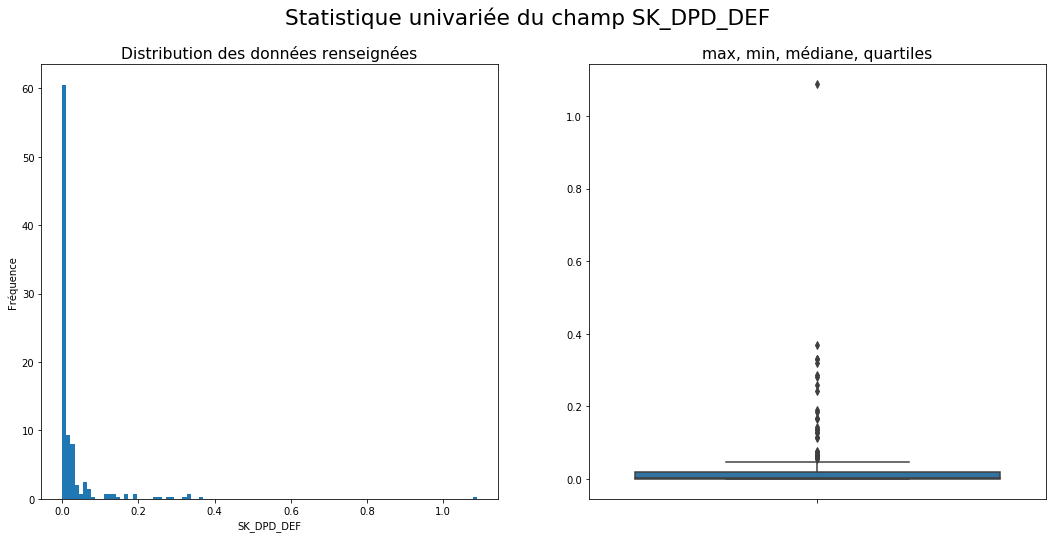

Mesures de position
 - Moyenne: 0.03
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.09
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.02
 - Max: 1.09
Mesures de forme
 - Skewness (asymétrie): 7.7
 - Kurtosis (applatissement): 80.36


In [366]:
myDf(dfCreditCardBalance[dfCreditCardBalance.SK_DPD != 0]).Stat('SK_DPD_DEF')

In [367]:
dfCreditCardBalance = dfCreditCardBalance.rename(columns={'SK_DPD':'SK_DPD_CRED_CARD'})
dfCreditCardBalance = dfCreditCardBalance.rename(columns={'SK_DPD_DEF':'SK_DPD_DEF_CRED_CARD'})

## Feature engineering sur Bureau Balance

#### Création d'une variable iniquant le niveau de DPD (day past due) du client sur Bureau

On récupère le SK_ID_CURR

In [368]:
dfBureauBalance = dfBureauBalance.merge(dfBureau[['SK_ID_CURR','SK_ID_BUREAU']], left_on=['SK_ID_BUREAU'], right_on=['SK_ID_BUREAU'])

On compte le nombre de ligne par client

In [369]:
dfBureauBalanceCount = pd.DataFrame(dfBureauBalance.groupby('SK_ID_CURR').size(), columns=['NB_BUREAU_BALANCE']).reset_index(drop=False)
dfBureauBalanceCount.head(3)

SK_ID_CURR  NB_BUREAU_BALANCE
0      100032                 76
1      100283                 98
2      100437                123

On ne conserve que les lignes avec un DPD (day past due) positif

In [370]:
del dfBureauBalance['SK_ID_BUREAU']
dfBureauBalance = dfBureauBalance[dfBureauBalance.STATUS.isin(['1','2','3','4','5'])]
dfBureauBalance['STATUS'] = dfBureauBalance['STATUS'].astype('int')

On applique un facteur temporel afin de diminuer l'impact des DPD anciens

In [371]:
dfBureauBalance['STATUS_BUREAU_DPD'] = dfBureauBalance.apply(lambda x: x.STATUS / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
del dfBureauBalance['STATUS']
del dfBureauBalance['MONTHS_BALANCE']

On somme par SK_ID_CURR

In [372]:
dfBureauDPD = dfBureauBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)[['SK_ID_CURR','STATUS_BUREAU_DPD']]

On divise par le nombre de lignes

In [373]:
dfBureauDPD = dfBureauDPD.merge(dfBureauBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
#dfBureauDPD['STATUS_DPD'] = dfBureauDPD.apply(lambda x: x.STATUS_DPD / x.NB_BUREAU_BALANCE, axis=1)

On ajoute les SK_ID_CURR sans DPD

In [374]:
dfBureauNoDPD = myDf(dfBureau).WhereNotExists(dfBureauDPD, left_on=['SK_ID_CURR'], right_on=['SK_ID_CURR'])[['SK_ID_CURR']].drop_duplicates()
dfBureauNoDPD['STATUS_BUREAU_DPD'] = 0

In [375]:
dfBureauDPD = pd.concat([dfBureauDPD,dfBureauNoDPD])

/home/pierre/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


On passe au log

In [376]:
dfBureauDPD['STATUS_BUREAU_DPD'] = dfBureauDPD.apply(lambda x: np.log(1+x.STATUS_BUREAU_DPD), axis=1)

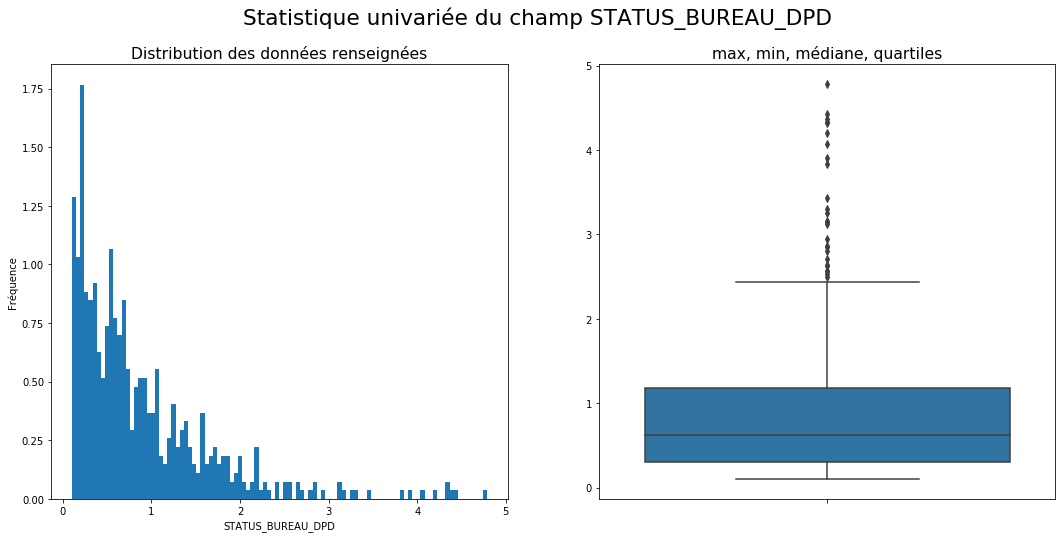

Mesures de position
 - Moyenne: 0.87
 - Médiane: 0.63
Mesures de dispertion
 - Ecart type: 0.78
 - Min: 0.1
 - Q25: 0.31
 - Q75: 1.18
 - Max: 4.79
Mesures de forme
 - Skewness (asymétrie): 1.97
 - Kurtosis (applatissement): 4.93


In [377]:
myDf(dfBureauDPD[dfBureauDPD.STATUS_BUREAU_DPD>0]).Stat('STATUS_BUREAU_DPD')

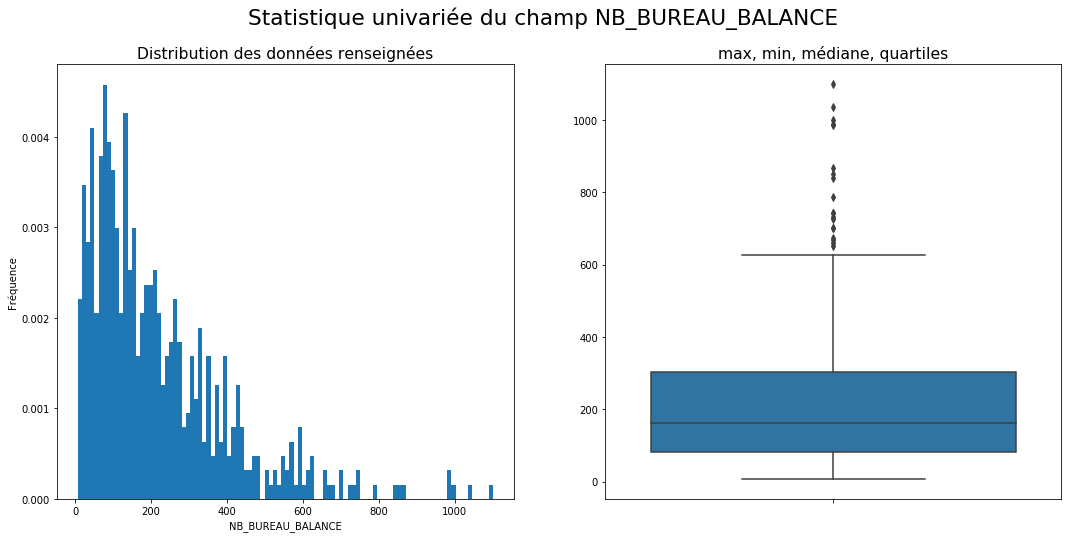

Mesures de position
 - Moyenne: 215.93
 - Médiane: 161.0
Mesures de dispertion
 - Ecart type: 181.74
 - Min: 7.0
 - Q25: 82.75
 - Q75: 303.0
 - Max: 1100.0
Mesures de forme
 - Skewness (asymétrie): 1.63
 - Kurtosis (applatissement): 3.35


In [378]:
myDf(dfBureauDPD).Stat('NB_BUREAU_BALANCE')

# Création d'un dataframe avec une ligne par SK_ID_CURR

## Transformation de dfPreviousApplication

In [379]:
categorical_col = list(dfPreviousApplication.select_dtypes(include=['object']).columns)
categorical_col.append('SK_ID_CURR')
categorical_col
#numerical_col = dfPreviousApplication.select_dtypes(include=['int64', 'float64']).columns

['MAIN_SELLER_INDUSTRY', 'SK_ID_CURR']

In [380]:
del dfPreviousApplication['SK_ID_PREV']

In [381]:
dfPreviousApplicationCat = dfPreviousApplication[categorical_col].drop_duplicates()
dfPreviousApplicationNum = dfPreviousApplication.groupby('SK_ID_CURR').mean().reset_index(drop=False)
dfPreviousApplication = dfPreviousApplicationNum.merge(dfPreviousApplicationCat, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
dfPreviousApplication

SK_ID_CURR  RATE_DOWN_PAYMENT  NAME_CONTRACT_STATUS  DAYS_DECISION  \
0         100032           0.424597              1.000000   -1497.000000   
1         100283           0.159610              1.000000   -1668.000000   
2         100304           0.000000              1.000000    -143.000000   
3         100400           0.034755              1.000000    -653.000000   
4         100436           0.000000              1.000000    -918.000000   
...          ...                ...                   ...            ...   
5799      455855           0.101244              1.000000   -1208.500000   
5800      455898           0.225812              0.714286   -1707.285714   
5801      455925           0.422268              1.000000    -289.000000   
5802      455987           0.319753              0.750000   -1949.250000   
5803      456242           0.035169              1.000000    -447.000000   

      NAME_YIELD_GROUP  NFLAG_INSURED_ON_APPROVAL  LAST_NAME_CONTRACT_STATUS  \
0             2.000000                   0.000000                        1.0   
1             2.000000                   0.500000                        1.0   
2             1.000000                   0.000000                        1.0   
3             1.333333                   0.000000                        1.0   
4             1.500000                   0.666667                        1.0   
...                ...                        ...                        ...   
5799          2.500000                   0.500000                        1.0   
5800          2.000000                   0.600000                        1.0   
5801          2.000000                   0.000000                        1.0   
5802          2.000000                   0.500000                        1.0   
5803          1.666667                   0.250000                        1.0   

      NB_SELLER_INDUSTRY  NB_PREVIOUS  X_SELL  MAIN_SELLER_INDUSTRY  
0                    1.0          1.0     0.0  Consumer electronics  
1                    1.0          2.0     0.0  Consumer electronics  
2                    1.0          1.0     0.0              Industry  
3                    2.0          3.0     0.0              Clothing  
4                    1.0          4.0     1.0  Consumer electronics  
...                  ...          ...     ...                   ...  
5799                 2.0          2.0     1.0          Connectivity  
5800                 2.0          7.0     1.0  Consumer electronics  
5801                 1.0          1.0     0.0  Consumer electronics  
5802                 2.0          8.0     1.0              Industry  
5803                 2.0          4.0     0.0  Consumer electronics  

[5804 rows x 11 columns]

### Merge avec les tables balances

In [382]:
dfPreviousApplication = dfPreviousApplication.merge(dfCreditCardBalance, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
dfPreviousApplication = dfPreviousApplication.merge(dfPosCashBalance, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
dfPreviousApplication = dfPreviousApplication.merge(dfInstallmentsPayments, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')

## Transformation de dfBureau

### On isole les variables catégorielles

In [383]:
dfBureau.dtypes

SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE             float64
DAYS_CREDIT                 int64
DAYS_CREDIT_ENDDATE       float64
AMT_CREDIT_MAX_OVERDUE    float64
AMT_CREDIT_SUM_LIMIT      float64
MAIN_CREDIT_TYPE           object
NB_CREDIT_TYPE              int64
NB_BUREAU                   int64
dtype: object

In [384]:
categorical_ix = list(dfBureau.select_dtypes(include=['object', 'bool']).columns)
categorical_ix.append('SK_ID_CURR')
categorical_ix
dfBureauCat = dfBureau[categorical_ix].drop_duplicates()

### On moyenne les variables numériques

In [385]:
del dfBureau['SK_ID_BUREAU']
dfBureauNum = dfBureau.groupby('SK_ID_CURR').mean().reset_index(drop=False)

### Merge des variables numériques et catégorielles

In [386]:
dfBureau = dfBureauNum.merge(dfBureauCat, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
dfBureau.head()

SK_ID_CURR  CREDIT_ACTIVE  DAYS_CREDIT  DAYS_CREDIT_ENDDATE  \
0      100032       0.250000 -1071.000000          -525.250000   
1      100283       0.000000 -1625.000000         -1379.500000   
2      100304       0.090909 -1802.454545         -1288.100000   
3      100400       0.142857 -1592.000000         -1222.428571   
4      100436       0.500000 -1734.000000          -264.500000   

   AMT_CREDIT_MAX_OVERDUE  AMT_CREDIT_SUM_LIMIT  NB_CREDIT_TYPE  NB_BUREAU  \
0                   0.000                   0.0             1.0        4.0   
1                     NaN                   NaN             1.0        2.0   
2                   0.414               90000.0             2.0       11.0   
3                   0.000                   0.0             2.0        7.0   
4                     NaN                   NaN             1.0        2.0   

  MAIN_CREDIT_TYPE  
0  Consumer credit  
1  Consumer credit  
2      Credit card  
3  Consumer credit  
4      Credit card

### Merge avec BureauBalance

In [387]:
dfBureau = dfBureau.merge(dfBureauDPD, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
dfBureau

SK_ID_CURR  CREDIT_ACTIVE  DAYS_CREDIT  DAYS_CREDIT_ENDDATE  \
0         100032       0.250000 -1071.000000          -525.250000   
1         100283       0.000000 -1625.000000         -1379.500000   
2         100304       0.090909 -1802.454545         -1288.100000   
3         100400       0.142857 -1592.000000         -1222.428571   
4         100436       0.500000 -1734.000000          -264.500000   
...          ...            ...          ...                  ...   
5229      455855       0.500000  -827.000000          -672.000000   
5230      455898       0.500000 -1597.000000           153.250000   
5231      455925       0.000000 -1065.000000           762.000000   
5232      455987       0.000000 -2064.000000         -1339.666667   
5233      456242       1.000000  -491.000000           509.000000   

      AMT_CREDIT_MAX_OVERDUE  AMT_CREDIT_SUM_LIMIT  NB_CREDIT_TYPE  NB_BUREAU  \
0                      0.000                   0.0             1.0        4.0   
1                        NaN                   NaN             1.0        2.0   
2                      0.414               90000.0             2.0       11.0   
3                      0.000                   0.0             2.0        7.0   
4                        NaN                   NaN             1.0        2.0   
...                      ...                   ...             ...        ...   
5229                   0.000                   0.0             2.0        2.0   
5230                     NaN                   0.0             2.0        4.0   
5231                     NaN                   0.0             1.0        1.0   
5232                6007.500                   0.0             1.0        3.0   
5233                     NaN                   0.0             1.0        1.0   

     MAIN_CREDIT_TYPE  NB_BUREAU_BALANCE  STATUS_BUREAU_DPD  
0     Consumer credit                NaN           0.000000  
1     Consumer credit                NaN           0.000000  
2         Credit card                NaN           0.000000  
3     Consumer credit                NaN           0.000000  
4         Credit card                NaN           0.000000  
...               ...                ...                ...  
5229      Credit card                NaN           0.000000  
5230      Credit card              211.0           0.519565  
5231  Consumer credit                NaN           0.000000  
5232  Consumer credit                NaN           0.000000  
5233      Credit card                NaN           0.000000  

[5234 rows x 11 columns]

## Merge final

In [388]:
dfApplication = dfApplication.merge(dfAmtLogMean, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
dfApplication = dfApplication.merge(dfAmtStdLog, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
dfApplication = dfApplication.merge(dfDays, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
dfApplication = dfApplication.merge(dfPreviousApplication, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
dfApplication = dfApplication.merge(dfBureau, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')

In [389]:
print(dfApplication.shape)
print('-')
print(dfApplication.dtypes)
tmp = dfApplication.isnull().sum()
print('-')
print(tmp[tmp>0])

(6150, 60)
-
SK_ID_CURR                             int64
TARGET                                 int64
NAME_CONTRACT_TYPE                    object
CODE_GENDER                           object
FLAG_OWN_CAR                          object
FLAG_OWN_REALTY                       object
CNT_CHILDREN                           int64
AMT_CREDIT                           float64
NAME_INCOME_TYPE                      object
NAME_EDUCATION_TYPE                  float64
NAME_HOUSING_TYPE                     object
DAYS_BIRTH                             int64
DAYS_EMPLOYED                          int64
OCCUPATION_TYPE                       object
REGION_RATING_CLIENT                   int64
ORGANIZATION_TYPE                     object
EXT_SOURCE_2                         float64
EXT_SOURCE_3                         float64
APARTMENTS_MODE                      float64
YEARS_BEGINEXPLUATATION_MODE         float64
WALLSMATERIAL_MODE                    object
OBS_30_CNT_SOCIAL_CIRCLE             float

In [ ]:
myDf(dfFinal).Stat(typeStat='biv', exclCol='SK_ID_CURR', bivOnlyCorrTable=True, multivHeatAnnot=False)

In [873]:
print(dfFinal.shape)
print('-')
print(dfFinal.dtypes)
tmp = dfFinal.isnull().sum()
print('-')
print(tmp[tmp>0])

(30751, 53)
-
SK_ID_CURR                             int64
TARGET                                 int64
NAME_CONTRACT_TYPE                   float64
CODE_GENDER                          float64
FLAG_OWN_CAR                         float64
FLAG_OWN_REALTY                      float64
CNT_CHILDREN                           int64
AMT_CREDIT                           float64
NAME_INCOME_TYPE                     float64
NAME_HOUSING_TYPE                    float64
DAYS_BIRTH                             int64
DAYS_EMPLOYED                          int64
OCCUPATION_TYPE                      float64
REGION_RATING_CLIENT                   int64
EXT_SOURCE_2                         float64
EXT_SOURCE_3                         float64
APARTMENTS_MODE                      float64
YEARS_BEGINEXPLUATATION_MODE         float64
WALLSMATERIAL_MODE                   float64
OBS_30_CNT_SOCIAL_CIRCLE             float64
DEF_30_CNT_SOCIAL_CIRCLE             float64
AMT_REQ_CREDIT_BUREAU_WEEK           floa

In [161]:
len(dfApplication)

6150

In [163]:
dfApplication.NAME_EDUCATION_TYPE.unique()

array(['Lower secondary', 'Secondary / secondary special',
       'Higher education', 'Incomplete higher', 'Academic degree'],
      dtype=object)

In [15]:
list_DPD = list(dfBureauBalanceOri[dfBureauBalanceOri.STATUS.isin(['1','2','3','4','5'])].SK_ID_BUREAU.unique())
dfBureauBalanceOri = dfBureauBalanceOri[~dfBureauBalanceOri.SK_ID_BUREAU.isin([5001710])]
dfBureauBalanceOri[dfBureauBalanceOri.SK_ID_BUREAU.isin(list_DPD)].sort_values(['SK_ID_BUREAU','MONTHS_BALANCE']).head(100)

SK_ID_BUREAU  MONTHS_BALANCE STATUS
2109039        5001718             -38      X
2109038        5001718             -37      0
2109037        5001718             -36      0
2109036        5001718             -35      0
2109035        5001718             -34      0
2109034        5001718             -33      0
2109033        5001718             -32      0
2109032        5001718             -31      0
2109031        5001718             -30      X
2109030        5001718             -29      0
2109029        5001718             -28      X
2109028        5001718             -27      0
2109027        5001718             -26      0
2109026        5001718             -25      0
2109025        5001718             -24      0
2109024        5001718             -23      0
2109023        5001718             -22      0
2109022        5001718             -21      X
2109021        5001718             -20      0
2109020        5001718             -19      0
2109019        5001718             -18      0
2109018        5001718             -17      X
2109017        5001718             -16      X
2109016        5001718             -15      X
2109015        5001718             -14      0
2109014        5001718             -13      X
2109013        5001718             -12      1
2109012        5001718             -11      X
2109011        5001718             -10      0
2109010        5001718              -9      X
2109009        5001718              -8      1
2109008        5001718              -7      0
2109007        5001718              -6      0
2109006        5001718              -5      0
2109005        5001718              -4      0
2109004        5001718              -3      0
2109003        5001718              -2      C
2109002        5001718              -1      C
2109001        5001718               0      C
25508853       5001720             -35      0
25508852       5001720             -34      0
25508851       5001720             -33      0
25508850       5001720             -32      0
25508849       5001720             -31      0
25508848       5001720             -30      0
25508847       5001720             -29      0
25508846       5001720             -28      0
25508845       5001720             -27      0
25508844       5001720             -26      0
25508843       5001720             -25      0
25508842       5001720             -24      0
25508841       5001720             -23      0
25508840       5001720             -22      0
25508839       5001720             -21      0
25508838       5001720             -20      0
25508837       5001720             -19      0
25508836       5001720             -18      0
25508835       5001720             -17      0
25508834       5001720             -16      0
25508833       5001720             -15      1
25508832       5001720             -14      0
25508831       5001720             -13      1
25508830       5001720             -12      0
25508829       5001720             -11      0
25508828       5001720             -10      0
25508827       5001720              -9      0
25508826       5001720              -8      0
25508825       5001720              -7      1
25508824       5001720              -6      1
25508823       5001720              -5      0
25508822       5001720              -4      1
25508821       5001720              -3      1
25508820       5001720              -2      0
25508819       5001720              -1      0
25508818       5001720               0      1
25509024       5001722             -85      0
25509023       5001722             -84      0
25509022       5001722             -83      0
25509021       5001722             -82      0
25509020       5001722             -81      0
25509019       5001722             -80      0
25509018       5001722             -79      0
25509017       5001722             -78      0
25509016       5001722             -77      0
25509015       5001722             -76      0
25509014       5001722             -75      0
25509013

In [88]:
dfCreditCardBalance4Analysis.merge(dfInstallmentsPayments4Analysis, left_on=['SK_ID_PREV','SK_ID_CURR'], right_on=['SK_ID_PREV','SK_ID_CURR'])

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0          1079071      171320              -6   353451.645   
1          1079071      171320              -5   347929.335   
2          1079071      171320              -3   335538.270   
3          1079071      171320              -2   329464.845   
4          2332604      155018              -6        0.000   
...            ...         ...             ...          ...   
564958     2537297      177502              -3        0.000   
564959     2537297      177502              -3        0.000   
564960     2440389      171073              -2    50159.700   
564961     2440389      171073              -2    50159.700   
564962     2440389      171073              -2    50159.700   

        AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
0                        585000                   67500.0   
1                        585000                       0.0   
2                        585000                       0.0   
3                        585000                       0.0   
4                        180000                       0.0   
...                         ...                       ...   
564958                   450000                       0.0   
564959                   450000                       0.0   
564960                   135000                       0.0   
564961                   135000                       0.0   
564962                   135000                       0.0   

        AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
0                   67500.00                         0.0   
1                       0.00                         0.0   
2                       0.00                         0.0   
3                       0.00                         0.0   
4                       0.00                         0.0   
...                      ...                         ...   
564958                  0.00                         0.0   
564959                  0.00                         0.0   
564960               6936.75                         0.0   
564961               6936.75                         0.0   
564962               6936.75                         0.0   

        AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  \
0                           0.00                14684.175   
1                           0.00                17918.190   
2                           0.00                17351.595   
3                           0.00                17013.510   
4                           0.00                    0.000   
...                          ...                      ...   
564958                      0.00                12018.420   
564959                      0.00                12018.420   
564960                   6936.75                 2271.645   
564961                   6936.75                 2271.645   
564962                   6936.75                 2271.645   

        AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 15750.000                  15750.000   
1                 18000.000                  18000.000   
2                 18000.000                  18000.000   
3                 18000.000                  18000.000   
4                     0.000                      0.000   
...                     ...                        ...   
564958           253649.565                 251399.565   
564959           253649.565                 251399.565   
564960             4770.000                   2480.715   
564961             4770.000                   2480.715   
564962             4770.000                   2480.715   

        AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     345433.860     351881.145            351881.145   
1                     340363.845     347929.335            347929.335   
2                     329031.720     335538.270            335538.270   
3                     322270.470     329464.845            329464.845   
4 

In [89]:
myDf(dfCreditCardBalance4Analysis).WhereNotExists(dfInstallmentsPayments4Analysis, right_on=['SK_ID_PREV','SK_ID_CURR'], left_on=['SK_ID_PREV','SK_ID_CURR'])

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0          2582071      363914              -1    63975.555   
1          2582071      363914             -84    27577.890   
2          2582071      363914              -7    65159.235   
3          2582071      363914             -55    67630.410   
4          2582071      363914             -58    66873.915   
...            ...         ...             ...          ...   
350487     2099868      433632              -1        0.000   
350488     1596609      254171              -4        0.000   
350489     2293273      378800              -1        0.000   
350490     1201672      299059              -1        0.000   
350491     1113515      292464              -7        0.000   

        AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
0                         45000                    2250.0   
1                         67500                       0.0   
2                         45000                       0.0   
3                         67500                       0.0   
4                         67500                    2250.0   
...                         ...                       ...   
350487                        0                       0.0   
350488                   135000                       0.0   
350489                        0                       0.0   
350490                    45000                       NaN   
350491                        0                       0.0   

        AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
0                     2250.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                     2250.0                         0.0   
...                      ...                         ...   
350487                   0.0                         0.0   
350488                   0.0                         0.0   
350489                   0.0                         0.0   
350490                   0.0                         NaN   
350491                   0.0                         0.0   

        AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  \
0                            0.0                   2250.0   
1                            0.0                   3375.0   
2                            0.0                   2250.0   
3                            0.0                   3375.0   
4                            0.0                   3375.0   
...                          ...                      ...   
350487                       0.0                      0.0   
350488                       0.0                    130.5   
350489                       0.0                      0.0   
350490                       NaN                      0.0   
350491                       0.0                      0.0   

        AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                  2250.000                   2250.000   
1                  4500.000                   4500.000   
2                  2250.000                   2250.000   
3                  4500.000                   4500.000   
4                  9000.000                   9000.000   
...                     ...                        ...   
350487                0.135                      0.135   
350488             6336.540                   6336.540   
350489                0.000                      0.000   
350490                  NaN                      0.000   
350491                0.000                      0.000   

        AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                      60175.080      64875.555             64875.555   
1                      26125.020      27577.890             27577.890   
2                      60301.170      65609.235             65609.235   
3                      65479.995      67630.410             67630.410   
4 

In [ ]:
dfPreviousApplication4Analysis.merge(dfCreditCardBalance4Analysis, right_on=['SK_ID_PREV','SK_ID_CURR'], left_on=['SK_ID_PREV','SK_ID_CURR'])

In [70]:
dfInstallmentsPaymentsOri.sort_values(['SK_ID_CURR','SK_ID_PREV','NUM_INSTALMENT_NUMBER','NUM_INSTALMENT_VERSION']).head(100)

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
1478621     1369693      100001                     1.0   
2568722     1369693      100001                     1.0   
3458712     1369693      100001                     1.0   
2624024     1369693      100001                     2.0   
1761012     1851984      100001                     1.0   
3774071     1851984      100001                     1.0   
3435373     1851984      100001                     1.0   
2144879     1038818      100002                     1.0   
2163032     1038818      100002                     1.0   
1675768     1038818      100002                     1.0   
3343696     1038818      100002                     1.0   
2841063     1038818      100002                     1.0   
1807424     1038818      100002                     1.0   
3594829     1038818      100002                     1.0   
210205      1038818      100002                     1.0   
607863      1038818      100002                     1.0   
2646927     1038818      100002                     1.0   
2785201     1038818      100002                     1.0   
504426      1038818      100002                     1.0   
699804      1038818      100002                     1.0   
740300      1038818      100002                     1.0   
1703436     1038818      100002                     1.0   
185679      1038818      100002                     1.0   
916044      1038818      100002                     1.0   
1390511     1038818      100002                     1.0   
442432      1038818      100002                     2.0   
2627835     1810518      100003                     1.0   
13709       1810518      100003                     1.0   
446588      1810518      100003                     1.0   
1687015     1810518      100003                     1.0   
1206007     1810518      100003                     1.0   
3421285     1810518      100003                     1.0   
1179410     1810518      100003                     2.0   
3060457     2396755      100003                     1.0   
1532400     2396755      100003                     1.0   
2771895     2396755      100003                     1.0   
480811      2396755      100003                     1.0   
620125      2396755      100003                     1.0   
3164200     2396755      100003                     1.0   
1001994     2396755      100003                     1.0   
2004439     2396755      100003                     1.0   
570555      2396755      100003                     1.0   
1475983     2396755      100003                     1.0   
1519746     2396755      100003                     1.0   
1139956     2396755      100003                     1.0   
1479922     2636178      100003                     1.0   
1923162     2636178      100003                     1.0   
1872725     2636178      100003                     1.0   
1868790     2636178      100003                     1.0   
1233145     2636178      100003                     1.0   
2201984     2636178      100003                     1.0   
3254507     1564014      100004                     1.0   
1263941     1564014      100004                     1.0   
3582086     1564014      100004                     2.0   
900094      2495675      100005                     1.0   
2816997     2495675      100005                     1.0   
1547855     2495675      100005                     1.0   
477244      2495675      100005                     1.0   
1721281     2495675      100005                     1.0   
3023701     2495675      100005                     1.0   
2690085     2495675      100005                     1.0   
3247738     2495675      100005                     1.0   
996531      2495675      100005                     2.0   
681160      2078043      100006                     2.0   
3181368     2190416      100006                     1.0   
2008485     2190416      100006                     1.0   
100902      2190416      100006                     1.0 

In [73]:
dfPosCashBalanceOri.NAME_CONTRACT_STATUS.value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [69]:
dfPosCashBalanceOri.sort_values(['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE']).head(100)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
7167007     1369693      100001             -57             4.0   
8789081     1369693      100001             -56             4.0   
7823681     1369693      100001             -55             4.0   
4704415     1369693      100001             -54             4.0   
2197888     1369693      100001             -53             4.0   
1261679     1851984      100001             -96             4.0   
1891462     1851984      100001             -95             4.0   
8531326     1851984      100001             -94             4.0   
4928574     1851984      100001             -93             4.0   
8473918     1038818      100002             -19            24.0   
2012884     1038818      100002             -18            24.0   
5258607     1038818      100002             -17            24.0   
1216849     1038818      100002             -16            24.0   
9849444     1038818      100002             -15            24.0   
7403606     1038818      100002             -14            24.0   
513222      1038818      100002             -13            24.0   
9228061     1038818      100002             -12            24.0   
8701895     1038818      100002             -11            24.0   
7601963     1038818      100002             -10            24.0   
9510102     1038818      100002              -9            24.0   
9514583     1038818      100002              -8            24.0   
9517658     1038818      100002              -7            24.0   
7606684     1038818      100002              -6            24.0   
6543835     1038818      100002              -5            24.0   
7714429     1038818      100002              -4            24.0   
9792215     1038818      100002              -3            24.0   
9793374     1038818      100002              -2            24.0   
6626366     1038818      100002              -1            24.0   
1278613     1810518      100003             -25            12.0   
4887970     1810518      100003             -24            12.0   
1248580     1810518      100003             -23            12.0   
6413902     1810518      100003             -22            12.0   
2945913     1810518      100003             -21            12.0   
3969672     1810518      100003             -20            12.0   
4887765     1810518      100003             -19            12.0   
5467865     1810518      100003             -18             7.0   
7873195     2396755      100003             -77            12.0   
3580739     2396755      100003             -76            12.0   
9123271     2396755      100003             -75            12.0   
5329936     2396755      100003             -74            12.0   
4358911     2396755      100003             -73            12.0   
1827209     2396755      100003             -72            12.0   
2163474     2396755      100003             -71            12.0   
2457763     2396755      100003             -70            12.0   
3683547     2396755      100003             -69            12.0   
2582345     2396755      100003             -68            12.0   
1822464     2396755      100003             -67            12.0   
152816      2396755      100003             -66            12.0   
9469094     2636178      100003             -28             6.0   
8372804     2636178      100003             -27             6.0   
5210589     2636178      100003             -26             6.0   
6887574     2636178      100003             -25             6.0   
4197913     2636178      100003             -24             6.0   
367237      2636178      100003             -23             6.0   
8371562     2636178      100003             -22             6.0   
6030254     2636178      100003             -21             6.0   
5208748     1564014      100004             -27             4.0   
6400437     1564014      100004             -26             4.0   
1834190     1564014      100004             -25         

In [38]:
dfCreditCardBalanceOri = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv',",")


In [56]:
dfCreditCardBalanceOri.NAME_CONTRACT_STATUS.value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

In [67]:
tmp = dfCreditCardBalanceOri
list_status = tmp[tmp.NAME_CONTRACT_STATUS.isin(['Completed'])].SK_ID_PREV
tmp = tmp[tmp.SK_ID_PREV.isin(list_status)]
list_status = tmp[tmp.NAME_CONTRACT_STATUS.isin(['Sent proposal'])].SK_ID_PREV
tmp = dfCreditCardBalanceOri[dfCreditCardBalanceOri.SK_ID_PREV.isin(list_status)]
cols = ['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE','AMT_BALANCE','AMT_CREDIT_LIMIT_ACTUAL','AMT_PAYMENT_CURRENT','NAME_CONTRACT_STATUS','SK_DPD','SK_DPD_DEF']
tmp.sort_values(['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'])[cols].head(100)

SK_ID_CURR  SK_ID_PREV  MONTHS_BALANCE  AMT_BALANCE  \
3647651      105317     1347689             -71        0.000   
1890770      105317     1347689             -70    67659.030   
2791799      105317     1347689             -69    65670.480   
2168677      105317     1347689             -68    63668.700   
2810464      105317     1347689             -67    66043.800   
3579391      105317     1347689             -66    65410.380   
3343700      105317     1347689             -65    73119.915   
606744       105317     1347689             -64    72359.505   
2587246      105317     1347689             -63    74939.085   
1554188      105317     1347689             -62    67475.205   
1176200      105317     1347689             -61    73487.970   
1063371      105317     1347689             -60    72756.675   
3355088      105317     1347689             -59    66401.235   
3149740      105317     1347689             -58    71455.905   
1180056      105317     1347689             -57    69624.045   
516718       105317     1347689             -56    67777.515   
2711269      105317     1347689             -55    70308.135   
751223       105317     1347689             -54    64776.555   
1841503      105317     1347689             -53    67346.910   
1805477      105317     1347689             -52    67131.045   
2458911      105317     1347689             -51    70416.495   
1872979      105317     1347689             -50    69710.985   
698374       105317     1347689             -49    67865.310   
1672205      105317     1347689             -48    65950.605   
35844        105317     1347689             -47    64023.300   
3736553      105317     1347689             -46    62020.260   
1453190      105317     1347689             -45    60000.615   
1852223      105317     1347689             -44    72772.740   
1792286      105317     1347689             -43    71959.545   
22788        105317     1347689             -42    65597.805   
2958493      105317     1347689             -41    67937.445   
3030996      105317     1347689             -40    73942.605   
2104148      105317     1347689             -39    69823.125   
43522        105317     1347689             -38    67976.775   
502222       105317     1347689             -37    70613.910   
2119389      105317     1347689             -36    64188.450   
455906       105317     1347689             -35    62216.325   
3334845      105317     1347689             -34    70408.800   
348372       105317     1347689             -33    63996.030   
1723478      105317     1347689             -32    73360.665   
2094799      105317     1347689             -31      512.280   
1043629      105317     1347689             -30        0.000   
1865815      105317     1347689             -29        0.000   
624831       105317     1347689             -28        0.000   
2168943      105317     1347689             -27        0.000   
283395       105317     1347689             -26        0.000   
829399       105317     1347689             -25        0.000   
3118703      105317     1347689             -24        0.000   
2803393      105317     1347689             -23        0.000   
2976135      105317     1347689             -22        0.000   
2741141      105317     1347689             -21        0.000   
2825656      105317     1347689             -20        0.000   
3452704      105317     1347689             -19        0.000   
3606727      105317     1347689             -18        0.000   
2167651      105317     1347689             -17        0.000   
1916933      105317     1347689             -16        0.000   
3795180      105317     1347689             -15        0.000   
569301       105317     1347689             -14        0.000   
812303       105317     1347689             -13        0.000   
3042394      105317     1347689             -12        0.000   
2706512      105317     1347689             -11        0.000   
3568224      105317     1347689          

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64


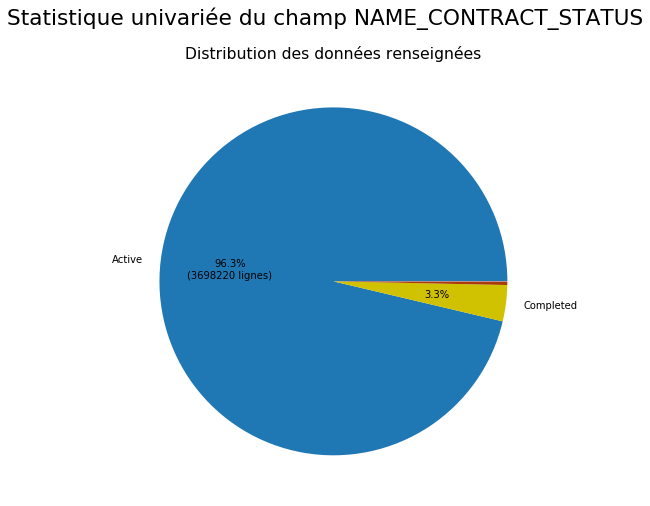

In [54]:
tmp = dfCreditCardBalanceOri
print(tmp.NAME_CONTRACT_STATUS.value_counts())
myDf(tmp).Stat('NAME_CONTRACT_STATUS')